## Import Libraries

Code cell below needed due to version incompatibility of numpy and ttpy (due to collab defaults). When prompted to uninstall numpy, write 'Y' in the output prompt. Once the cell finishes running, the runtime needs to be restarted and the other cells besides this one can be run without error.

In [3]:
!pip install pylatexenc
!pip uninstall numpy
!pip install --upgrade numpy==1.23

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136820 sha256=b41d390614dad8326c048cccb2617226cc9248f942eb942117c522a057732777
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
Found existing installation: numpy 1.23.0
Uninstalling numpy-1.23.0:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.23.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.s

In [5]:
#!pip install ttpy # this may not be up to date compared to the repository
# !pip install git+https://github.com/oseledets/ttpy.git@refs/pull/87/head
# As soon as #87 is merged you can drop @... suffix and run.

# This is the preferred way to install ttpy.
!pip install git+https://github.com/oseledets/ttpy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oseledets/ttpy.git to /tmp/pip-req-build-wfe3ff_c
  Running command git clone --filter=blob:none --quiet https://github.com/oseledets/ttpy.git /tmp/pip-req-build-wfe3ff_c
  Resolved https://github.com/oseledets/ttpy.git to commit a50d5e0ce2a033a4b1aa703715cb85d715b9b34a
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ttpy: filename=ttpy-1.2.0-cp310-cp310-linux_x86_64.whl size=3546104 sha256=31dcc766596c491d9204eae1688dfb12003bd3d910c672ec15c80b5b63688a6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qml972ec/wheels/0f/9c/16/16342a640cb36d2dad60b14dea6a8e40d25a21802581aee13c
Successfully built ttpy


In [7]:
from __future__ import print_function, absolute_import, division
import sys
sys.path.append('../')

import numpy as np
from numpy import linalg as LA
from scipy.integrate import solve_ivp

import math, tt
import tt.ksl
import time

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt
import networkx as nx
import scipy.special as sp

## **Hands-On Tutorial on Tensor Trains** 

The goal of this tutorial is to get a quick start into the [TT-Toolbox](https://github.com/oseledets/ttpy) for fast multilinear algebra computations. Here, we introduce the basic routines for multidimensional array operations in TT-format with examples, incluiding a presentation based on the quick start document developed by Ivan Oseledets, Sergey Dolgov, Vladimir Kazeev, Olga Lebedeva, Thomas Mach, and developments at Yale by the Batista group.



### **What is a tensor train?**

The TT-format of a tensor **A** is defined, as follows:

$A(l_1, l_2, \dots, l_d) = \sum_{\alpha_1=1}^{r_1} \cdots \sum_{\alpha_{d-1}=1}^{r_{d-1}} G_1(l_1,\alpha_1) G_2(\alpha_1,l_2,\alpha_2) \cdots G_d(\alpha_{d-1},l_d),$

or more concisely $A(l_1, l_2, \dots, l_d) 
= G_1(l_1) \times G_2(l_2) \times \cdots \times G_d(l_d),$ where $G_k(l_k)$ are $r_{k-1} \times r_k$ matrices, and $r_0 = r_d = 1$, as represented in the following diagram:

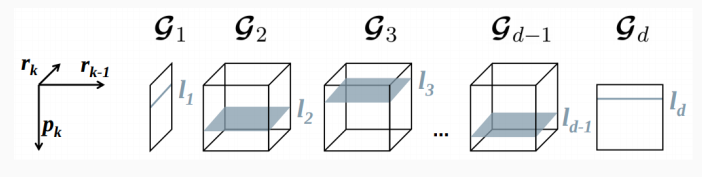

The approximation in this format is known to be stable and can be obtained by iterative [QR](https://en.wikipedia.org/wiki/QR_decomposition) or [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) decompositions. Matrices can also be represented in TT-format, analogously, so matrix-by-vector products can be performed by multiplication of tensor trains.

A vector of length $n_1 \dots n_d$ is said to be in the TT-format, if it has low TT-ranks considered as $d$-dimensional array (in MATLAB it is just a single call to the `reshape' function. Matrices acting on such vectors have size $M \times N$, where $N =\prod_{k=1}^d n_k$. 

For simplicity, assume they are square so each element of such matrix can be indexed by $i_1, \dots, i_d, j_1,\dots j_d$, where multiindex $i_k$, $k = 1, \dots, d$ corresponds to
rows, and $j_k$, $k = 1, \dots, d$ --to columns of the matrix. The matrix $M$ is said to be in the TT-format if

$M(i_1, \dots,i_d, j_1 \dots, j_d) = M_1(i_1, j_1) M_2(i_2, j_2) \dots M_d(i_d, j_d),$

and $M_k(i_k,j_k)$ is an $r_{k-1} \times r_k$ matrix.

Therefore, the TT-Toolbox has two main classes: **tt_tensor** and **tt_matrix**, where tt_tensor is a TT-representation of a d-dimensional array (i.e., a tensor product of vectors), and tt_matrix is the TT-representation of a d-level matrix (i.e., a tensor product of matrices).

The class tt_tensor contains the following attributes:
                                    
1. tt.core:  cores of the TT-decomposition stored in one “long” 1D array (i.e., core: is an ndarray flatten (Fortran-ordered) that stores the TT cores sequentially. To get a list of three-dimensional cores use "tt.vector.to_list(my_tensor)")

2. tt.d:  dimensionality of the tensor
3. tt.n:  mode sizes of the tensor
4. tt.r:  ranks of the TT decomposition of the tensor
5. tt.ps:  markers for position of the k-the core in array tt.core: if ps=tt.ps, then k-core can be obtained as follows:


### **Basic Routines**


#### **tt_tensor class**

**1. tt.tensor(y,eps)**: constructs TT-tensor from full array y with accuracy eps

In [8]:
y = np.array([[1,2], [3,4]])
tty=tt.tensor(y,eps=1e-14); print("tty=",tty)

tty= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=1 



**Attributes of tensor train tty:**

**2. tty.n**: returns the array of mode dimensions of tty

In [9]:
array_mode_dimensions=tty.n; print("mode dimensions of tty =",array_mode_dimensions)

mode dimensions of tty = [2 2]


**3. tty.r**: returns the array of core ranks

In [10]:
array_core_ranks=tty.r; print("core ranks of tty =",array_core_ranks)

core ranks of tty = [1 2 1]


**4. tty.erank**: returns effective rank of the TT-tensor

In [11]:
print("effective rank of tty", tty.erank)

effective rank of tty 2.0


**5. tty.d**: returns the dimensionality (number of cores) of tty

In [12]:
dimensionality=tty.d; print("dimensionality of tty=",dimensionality)

dimensionality of tty= 2


**6. tty.core**:  returns the array of cores 

In [13]:
print("1d flatten cores of tty =", tty.core)

1d flatten cores of tty = [-2.21087956 -4.99780755 -0.33468131  0.14805293 -0.57604844  0.81741556
 -0.81741556 -0.57604844]


**7. r=tty.r[k]**: returns the k-th rank of the TT-decomposition, and all ranks if k is not specified

In [14]:
print("rank 1 of tty =", tty.r[1])
print("all ranks of tty =", tty.r)

rank 1 of tty = 2
all ranks of tty = [1 2 1]


**8. tty.ps** returns the indices of each core

In [15]:
print("indices_of_cores of tty=",tty.ps);

indices_of_cores of tty= [1 5 9]


**9. tty.core[ps[k]:ps[k+1]-1]**: returns the entry values of core k corresponding to the indices of the k-th core

In [16]:
k=1; ps=tty.ps; print("k-th_core=", tty.core[ps[k]:ps[k+1]-1]);

k-th_core= [ 0.81741556 -0.81741556 -0.57604844]


**10. tty.full()** converts TT-tensor tty to a full array

In [17]:
y=tty.full(); print("y=",y)

y= [[1. 2.]
 [3. 4.]]


**11. tty.round(eps)**  approximates the TT-tensor tty by another TT-tensor ttny with smaller ranks

In [18]:
ttny=tty.round(1e-2); print("ttny=",ttny)

ttny= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=1 



**12. tt.rand(n,d,r)**: builds a d-dimensional TT of random numbers (from a Normal distribution), with dimension d, ranks r, and mode sizes n, where n and r can be arrays of integers defining n and r for each mode, or single integers (then all dimensions and ranks are the same).

---



In [19]:
tty=tt.rand(5,2,3); print("tty=",tty)

tty= This is a 2-dimensional tensor 
r(0)=1, n(0)=5 
r(1)=3, n(1)=5 
r(2)=1 



**13. tt=tt.ones(n,d)** generates a tt of ones with mode sizes n, dimension d of all ones

In [20]:
n=2; d=3;ttones=tt.ones(n,d); print("ttones=",ttones)

ttones= This is a 3-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=1, n(1)=2 
r(2)=1, n(2)=2 
r(3)=1 



**14. tty.norm()**: returns Frobenius norm of the TT-tensor.

In [21]:
print("norm of tty=",tty.norm())

norm of tty= 6.877180037884967


**15. elem=tty[i1,i2,...,id]**:  computes element of the TT-tensor in position i1,i2,...,id.

In [22]:
print("tensor element tty[1,1]=",tty[1,1])

tensor element tty[1,1]= 0.48138411204638804


**16. elem=tty[ind]**: where ind is an integer array of length d return element of the TT-tensor in the position specified by multiindex ind.


In [23]:
ind=np.array([1,1]); print("tensor element tty[1,1]=",tty[ind])

tensor element tty[1,1]= 0.48138411204638804


**17. tty.diag(tty)**: constructs a diagonal TT-matrix from TT-tensor, or takes diagonal of a TT-matrix.

In [24]:
ttm=tt.diag(tty); print("ttm=",ttm)

ttm= This is a 2-dimensional matrix 
r(0)=1, n(0)=5, m(0)=5 
r(1)=3, n(1)=5, m(1)=5 
r(2)=1 



**18. tt.kron(tt1,tt2)**: compute the outer product of tt1 and tt2, thus generating a train where the number of dimensions equals the sum of the number of dimensions of the two input tensors trains. For TT-matrices it computes their Kronecker product in TT-format.

In [25]:
y1 = np.array([1,2]); tty1 = tt.tensor(y1); 
y2 = np.array([3,4]); tty2 = tt.tensor(y2);
tty= tt.kron(tty1,tty2)

**19. Binary operations** tt1 . tt2, where '.' can be '+', '-' or '*'

In [26]:
tts=ttny+tty; print("tts=",tts)
ttp=ttny*tty; print("ttp=",ttp)
# tt12=tty1*tty2; print("ttp=",tt12) # bug for tensors with one core

tts= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=3, n(1)=2 
r(2)=1 

ttp= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=1 



**20. tt.dot(tt1,tt2)**: returns the dot (scalar) product of tensor trains tt1 and tt2

In [27]:
tt1=tty; tt2=tty; print("dot product=", tt.dot(tt1,tt2))

dot product= 125.0


#### **tt_matrix class**

**21. tt.matrix(y,eps)** constructs TT-matrix from full array

In [28]:
y = np.array([[1,2], [4,5], [4,5]]); ttmy=tt.matrix(y,eps=1e-14); ttmy=tt.kron(ttmy,ttmy); print("ttmy=",ttmy)

ttmy= This is a 2-dimensional matrix 
r(0)=1, n(0)=3, m(0)=2 
r(1)=1, n(1)=3, m(1)=2 
r(2)=1 



**22. ttmy.full()**  converts TT-matrix ttmy to a full square matrix

In [29]:
y=ttmy.full(); print("y=",y)

y= [[ 1.  2.  2.  4.]
 [ 4.  5.  8. 10.]
 [ 4.  5.  8. 10.]
 [ 4.  8.  5. 10.]
 [16. 20. 20. 25.]
 [16. 20. 20. 25.]
 [ 4.  8.  5. 10.]
 [16. 20. 20. 25.]
 [16. 20. 20. 25.]]


**23. ttmy.n** returns array of n mode dimensions of (nxm) ttmy (i.e., # of rows)

In [30]:
print("n modes of ttmy", ttmy.n)

n modes of ttmy [3 3]


**24. ttmy.m** returns array of m mode dimensions of (nxm) ttmy (i.e., # of columns)

In [31]:
print("m modes of ttmy", ttmy.m)

m modes of ttmy [2 2]


**25. ttmy.tt.r** returns array of ranks of ttmy

In [32]:
print("ranks of ttmy", ttmy.tt.r)

ranks of ttmy [1 1 1]


**26. ttmy.tt.d** returns dimensionality of ttmy (# of cores)

In [33]:
print("dimensionality of ttmy", ttmy.tt.d)


dimensionality of ttmy 2


**27. ttmy.tt.ps** returns the indices of cores of ttmy

In [34]:
print("indices of cores of ttmy", ttmy.tt.ps)

indices of cores of ttmy [ 1  7 13]


**28. ttmy.tt.core** returns the array of cores of ttmy

In [35]:
print("cores of ttmy", ttmy.tt.core)

cores of ttmy [1. 4. 4. 2. 5. 5. 1. 4. 4. 2. 5. 5.]


**29. matvec(A,b)** returns matrix-by-vector multiplication where A is a tt_matrix and b is a tt_tensor of appropriate sizes

In [36]:
A=ttmy;b=tty; print("A*b=",tt.matvec(A,b))

A*b= This is a 2-dimensional tensor 
r(0)=1, n(0)=3 
r(1)=1, n(1)=3 
r(2)=1 



**30. A * B** returns matrix-by-matrix product where A and B have tt_matrix format

In [37]:
B=A; print("A*B=",A*B)

A*B= This is a 2-dimensional matrix 
r(0)=1, n(0)=3, m(0)=2 
r(1)=1, n(1)=3, m(1)=2 
r(2)=1 



**31. tt=tt.eye(n,d)** generates a tt of ones with mode sizes n, dimension d of all ones

In [38]:
n=2; d=3;tteye=tt.eye(n,d); print("tteye=",tteye)

tteye= This is a 3-dimensional matrix 
r(0)=1, n(0)=2, m(0)=2 
r(1)=1, n(1)=2, m(1)=2 
r(2)=1, n(2)=2, m(2)=2 
r(3)=1 



**32. tt.qlaplace_dd(d)** generates a tensor train of the Laplacian operator with Dirichlet boundary conditions on a gred with $2^{d_1} \times 2^{d_1} \times \dots 2^{d_n}$ 

In [39]:
# Example
d1=2;d2=2;d3=2; d=np.array([d1,d2,d3]);lp = tt.qlaplace_dd(d);lp

This is a 6-dimensional matrix 
r(0)=1, n(0)=2, m(0)=2 
r(1)=4, n(1)=2, m(1)=2 
r(2)=2, n(2)=2, m(2)=2 
r(3)=4, n(3)=2, m(3)=2 
r(4)=2, n(4)=2, m(4)=2 
r(5)=3, n(5)=2, m(5)=2 
r(6)=3 

**33. tt.linspace(n, d, a, b)** creates a QTT-representation of a uniform grid on an interval [a, b]

In [40]:
n=2;d=21;a=0;b=1; sol=tt.linspace(n, d, a, b);sol 

This is a 21-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=2, n(2)=2 
r(3)=2, n(3)=2 
r(4)=2, n(4)=2 
r(5)=2, n(5)=2 
r(6)=2, n(6)=2 
r(7)=2, n(7)=2 
r(8)=2, n(8)=2 
r(9)=2, n(9)=2 
r(10)=2, n(10)=2 
r(11)=2, n(11)=2 
r(12)=2, n(12)=2 
r(13)=2, n(13)=2 
r(14)=2, n(14)=2 
r(15)=2, n(15)=2 
r(16)=2, n(16)=2 
r(17)=2, n(17)=2 
r(18)=2, n(18)=2 
r(19)=2, n(19)=2 
r(20)=2, n(20)=2 
r(21)=1 

**34. tt.reshape(tty,s)** reshapes tty to shape specified by array s

In [41]:
# Example
print("sol=",sol);d=int(sol.d/3)
sol_3d=tt.reshape(sol, [2**d,2**d,2**d])
sol_3d

sol= This is a 21-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=2, n(2)=2 
r(3)=2, n(3)=2 
r(4)=2, n(4)=2 
r(5)=2, n(5)=2 
r(6)=2, n(6)=2 
r(7)=2, n(7)=2 
r(8)=2, n(8)=2 
r(9)=2, n(9)=2 
r(10)=2, n(10)=2 
r(11)=2, n(11)=2 
r(12)=2, n(12)=2 
r(13)=2, n(13)=2 
r(14)=2, n(14)=2 
r(15)=2, n(15)=2 
r(16)=2, n(16)=2 
r(17)=2, n(17)=2 
r(18)=2, n(18)=2 
r(19)=2, n(19)=2 
r(20)=2, n(20)=2 
r(21)=1 



This is a 3-dimensional tensor 
r(0)=1, n(0)=128 
r(1)=2, n(1)=128 
r(2)=2, n(2)=128 
r(3)=1 

**35. tmatvec(U,f)** returns matrix-by-vector multiplication where f is a tt_tensor and U is a matrix tt_tensor operator (with twice the number of cores of f).


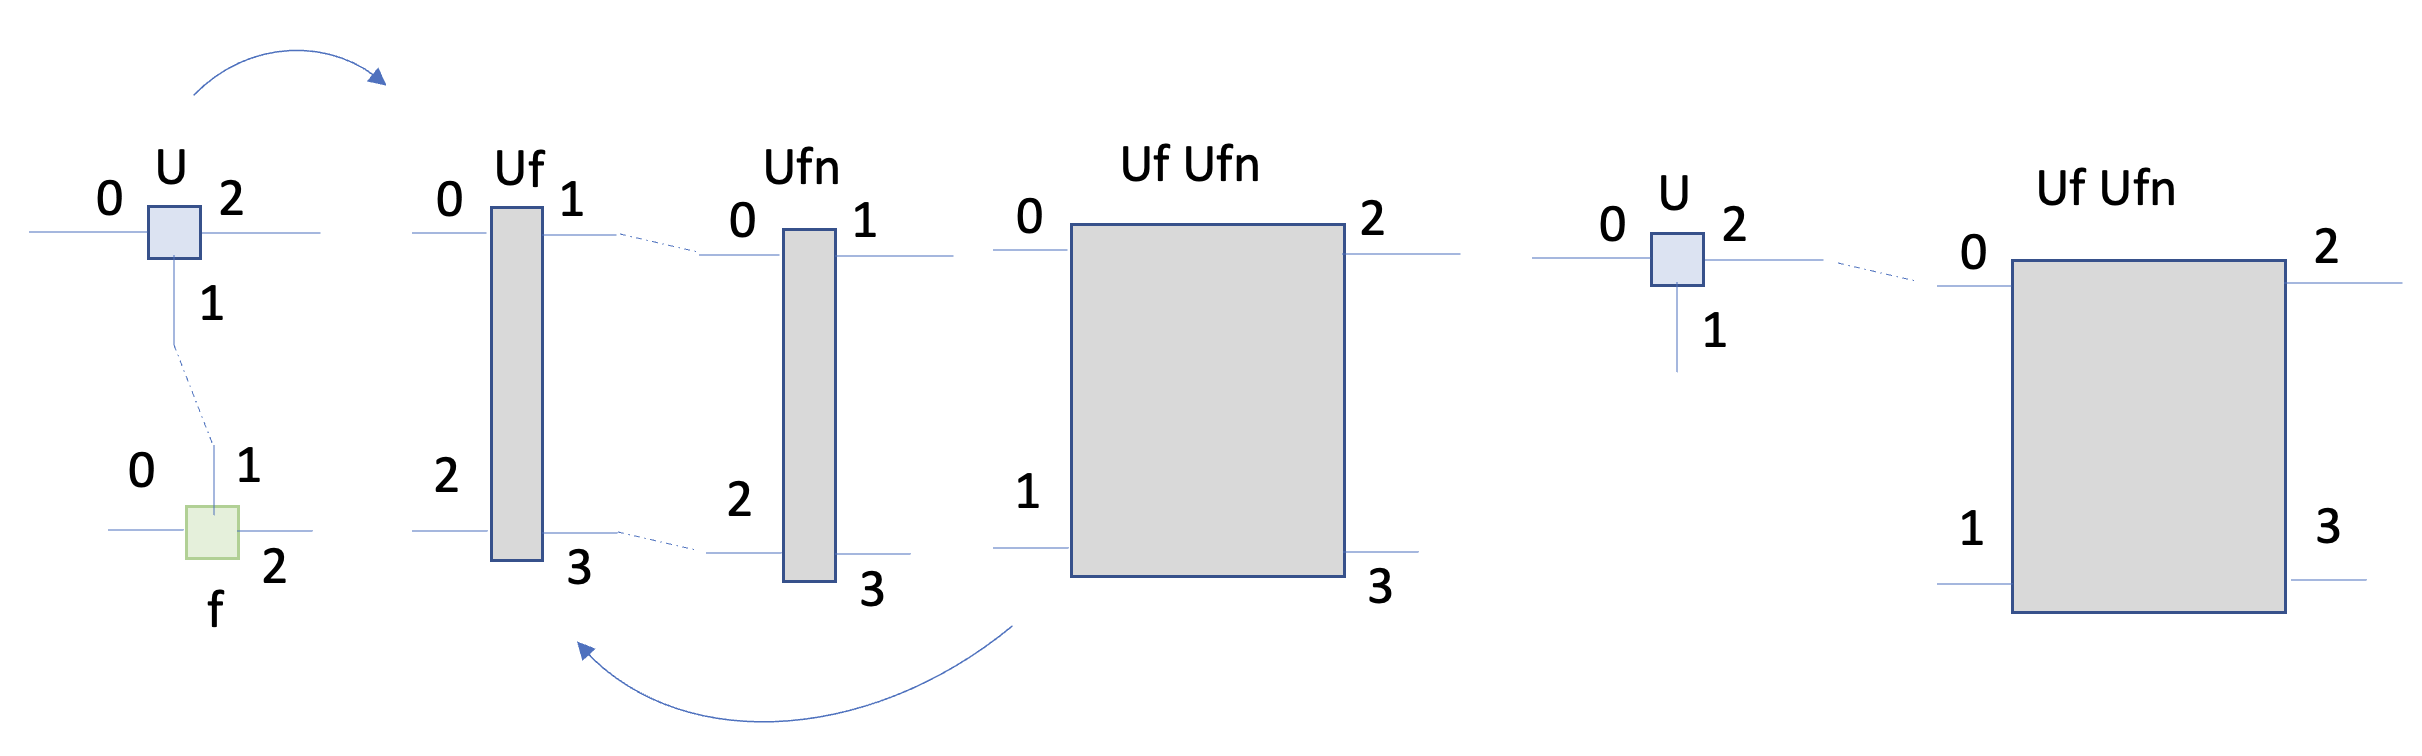

TTT(X,Y) computes the outer product of two multi-dimensional arrays X and Y. (equivalent to tt.kron?)

TTT(X,Y,XDIMS,YDIMS) computes the contracted product of X and Y in the modes specified by the row vectors XDIMS and YDIMS. 

TTT(X,Y,DIMS) is equivalent to calling TTT(X,Y,DIMS,DIMS).

In the case of complex tensors, the complex conjugate of X is used.


**Examples**

x = rand(4,2,3); y = rand(3,4,2);

z = ttt(x,y)                  #<-- outer product of x and y

z = ttt(x,x,1:3)              #<-- inner product of x with itself

z = ttt(x,y,[1 2 3],[2 3 1])  #<-- inner product of x with permuted y

z = ttt(x,y,[1 3],[2 1])      #<-- outer product along specified dims 

x = rand(4,2,3); y = rand(3,4,2);

z = ttt(x,y)                  %<-- outer product of x and y

z = ttt(x,x,1:3)              %<-- inner product of x with itself

z = ttt(x,y,[1 2 3],[2 3 1])  %<-- inner product of x with permuted y

z = ttt(x,y,[1 3],[2 1])      %<-- outer product along specified dims

In [42]:
def tmatvec(ttu,ttf):
    # Matrix-by-vector multiplication, both ttu matrix and ttf vector in tt format 
    U=ttu.to_list(ttu)                                 # get cores from ttU
    f=ttf.to_list(ttf)                                 # get cores from ttf
    d=len(f);j=1
    Uf=np.tensordot(U[d],f[0],axes=([1],[1]))
    if d > 1:
        for k in range(1,d):
            Ufn=np.tensordot(U[d+k],f[k],axes=([1],[1]))
            Uf=np.tensordot(Uf,Ufn,axes=([j,3],[0,2]));j=2
    f[d-1]=np.tensordot(U[d-1],Uf,axes=([2],[0]))
    f[d-1]=f[d-1].reshape(f[d-1].shape[0],f[d-1].shape[1],f[d-1].shape[2]*f[d-1].shape[3]*f[d-1].shape[4])
    f[:d-1]=U[:d-1]
    out=ttf.from_list(f)                      # assemble tt from updated cores 
    return out

Simple example for testing tmatvec

In [43]:
n=3
f = np.arange(2**n).reshape([2]*n)
ttf=tt.tensor(f,eps=1e-14);

ttu = tt.tensor(np.kron(f,f).reshape([2]*2*n));

fn=tmatvec(ttu,ttf)
fn=tmatvec(ttu,fn)

print(fn.full())
print(ttu.r,fn.r) # Note that the ranks of fn are fixed by the ranks of ttu

[[[  5464.  20184.]
  [ 15448.  57048.]]

 [[ 34904.  49624.]
  [ 98648. 140248.]]]
[1 2 4 4 4 2 1] [1 2 4 1]


Comparison to the tt-matrix format

In [44]:
u=np.kron(f,f).reshape([2]*2*n)
ttu=tt.matrix(u)

fn=tt.matvec(ttu,ttf)
fn=tt.matvec(ttu,fn)

print(fn.full())
#fn=fn.round(eps=1e-14)
print(ttu.r,fn.r)  # Note that the ranks of fn keep growing

[[[  5464.  20184.]
  [ 15448.  57048.]]

 [[ 34904.  49624.]
  [ 98648. 140248.]]]
[1 4 4 1] [ 1 32 32  1]


Vector-by-vector multiplication

In [45]:
def prod(ttf1,ttf2):
    # vector-by-vector multiplication both in tt format

    ttf=ttf1*ttf2
    f=ttf.to_list(ttf)                        # get cores from ttf
    d=len(f);j=1

    # Identity Matrix
    vm = np.eye(2**d)                         # Identity matrix
    vm = vm.reshape([2]*d*2)                  # Quantics format
    vm = tt.tensor(vm)                        # TT-vector format
    U=vm.to_list(vm)                          # get cores from vm

    # Projection with Identity Matrix
    Uf=np.tensordot(U[d],f[0],axes=([1],[1]))
    if d > 1:
        for k in range(1,d):
            Ufn=np.tensordot(U[d+k],f[k],axes=([1],[1]))
            Uf=np.tensordot(Uf,Ufn,axes=([j,3],[0,2]));j=2
    f[d-1]=np.tensordot(U[d-1],Uf,axes=([2],[0]))
    f[d-1]=f[d-1].reshape(f[d-1].shape[0],f[d-1].shape[1],f[d-1].shape[2]*f[d-1].shape[3]*f[d-1].shape[4])
    f[:d-1]=U[:d-1]
    out=ttf.from_list(f)                      # assemble tt from updated cores 
    return out

In [46]:
def sums(ttf1,ttf2):
    # vector-vector summation both in tt format

    ttf=ttf1+ttf2
    f=ttf.to_list(ttf)                        # get cores from ttf
    d=len(f);j=1

    # Identity Matrix
    vm = np.eye(2**d)                         # Identity matrix
    vm = vm.reshape([2]*d*2)                  # Quantics format
    vm = tt.tensor(vm)                        # TT-vector format
    U=vm.to_list(vm)                          # get cores from vm
    #vm=vm.round(eps=1e-14)
    #print(vm.r)

    # Projection with Identity Matrix
    Uf=np.tensordot(U[d],f[0],axes=([1],[1]))
    if d > 1:
        for k in range(1,d):
            Ufn=np.tensordot(U[d+k],f[k],axes=([1],[1]))
            Uf=np.tensordot(Uf,Ufn,axes=([j,3],[0,2]));j=2
    f[d-1]=np.tensordot(U[d-1],Uf,axes=([2],[0]))
    f[d-1]=f[d-1].reshape(f[d-1].shape[0],f[d-1].shape[1],f[d-1].shape[2]*f[d-1].shape[3]*f[d-1].shape[4])
    f[:d-1]=U[:d-1]
    
    out=ttf.from_list(f)                      # assemble tt from updated cores 
    
    return out

In [47]:
print("Input vector")
v = np.arange(2**n)
v = v.reshape([2]*n)
v = tt.tensor(v)
print(v.full().flatten())

# Multiplication
v2=prod(v,v)
v2=prod(v2,v)
print("Multiplication: v^3")
print(v2.r,v2.full().flatten())  # Note that the ranks of v2 are fixed by the ranks of vm
v22=v*v*v
#v22=v22.round(eps=1e-14)
print(v22.r,v22.full().flatten())   # Note that the ranks of v22 keep growing

# Summation
vs=sums(v,v)
vs=sums(vs,v)
print("Sum: v+v+v")
print(vs.r,vs.full().flatten())  # Note that the ranks of vs are fixed by the ranks of vm
vss=v+v+v
print(vss.r,vss.full().flatten())   # Note that the ranks of vss keep growing

Input vector
[-9.43689571e-16  1.00000000e+00  2.00000000e+00  3.00000000e+00
  4.00000000e+00  5.00000000e+00  6.00000000e+00  7.00000000e+00]
Multiplication: v^3
[1 2 4 1] [2.31111593e-32 1.00000000e+00 8.00000000e+00 2.70000000e+01
 6.40000000e+01 1.25000000e+02 2.16000000e+02 3.43000000e+02]
[1 8 8 1] [3.05311332e-16 1.00000000e+00 8.00000000e+00 2.70000000e+01
 6.40000000e+01 1.25000000e+02 2.16000000e+02 3.43000000e+02]
Sum: v+v+v
[1 2 4 1] [-2.83106871e-15  3.00000000e+00  6.00000000e+00  9.00000000e+00
  1.20000000e+01  1.50000000e+01  1.80000000e+01  2.10000000e+01]
[1 6 6 1] [-2.66453526e-15  3.00000000e+00  6.00000000e+00  9.00000000e+00
  1.20000000e+01  1.50000000e+01  1.80000000e+01  2.10000000e+01]


### **Advanced functions**

#### **1. Linear System Solver**

x = tt.amen.amen_solve2(A, y,y, tol, varargin) solves the following linear system: 

\begin{equation}
A*x = y 
\end{equation}
with accuracy/residual tol using the AMEn iteration.

Matrix A has to be given in the TT-format, right-hand side y should be given in the TT-format also. Options are provided in form 'PropertyName1',PropertyValue1,'PropertyName2',PropertyValue2 and so on. The parameters are set to default (in brackets in the following)

The list of option names and default values:
*   x0 - initial approximation [random rank-2 tensor]
*   nswp - maximal number of sweeps [50]
*   rmax - maximal TT-rank of the solution [1000]
*   verb - verbosity level, 0-silent, 1-sweep info, 2-block info [1]
*   max_full_size - maximal size of the local matrix for the full solver [50]
*   local_prec - local preconditioner: '' (no prec.), 'ljacobi','cjacobi', 'rjacobi' ['']
*   local_iters - number of local gmres restarts [2]
*   local_restart - dimension of local gmres [40]
*   kickrank - compression rank of the residual Z, i.e. enrichment size [4]
*   kicktype - how to truncate Z: 'svd', 'als' or 'rand' ['als']
*   kickrank2 - size of the secondary random enrichment for Z (kicktype=='als' only) [0]
*   ismex - shall we use the MEX lib solve3d_2 for local solution instead of gmres. It safely switches off automatically if solve3d_2 is not found in the MATLAB path, as well as on complex data. To obtain solve3d_2, you need to compile it in the TT-Toolbox/fmex directory, please follow instructions there [true]
*   resid_damp - solve local problems with accuracy tol/resid_damp. Larger value may reduce a spurious noise from inexact local solutions, but increase CPU time [2]
*   trunc_norm - truncate in either Frob. ('fro'), or residual norm ('residual') ['residual']
*   z0 - initial guess for Z (kicktype=='als' only).
*   tol_exit - stopping difference between consecutive iterations (if trunc_norm=='fro') or residual (trunc_norm=='resid') [tol]
*   symm - shall we symmetrize the problem (A'Ax=A'y) before the solution [false]


In [48]:
# Example: Use amen_solve to solve the Poisson eqn.
import tt.amen
d =7; A= tt.qlaplace_dd([d,d,d]);
y = tt.ones(2,3*d)
#  linear system solution via AMR scheme
x = tt.amen.amen_solve(A,y,y,1e-6);y

This is a 21-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=1, n(1)=2 
r(2)=1, n(2)=2 
r(3)=1, n(3)=2 
r(4)=1, n(4)=2 
r(5)=1, n(5)=2 
r(6)=1, n(6)=2 
r(7)=1, n(7)=2 
r(8)=1, n(8)=2 
r(9)=1, n(9)=2 
r(10)=1, n(10)=2 
r(11)=1, n(11)=2 
r(12)=1, n(12)=2 
r(13)=1, n(13)=2 
r(14)=1, n(14)=2 
r(15)=1, n(15)=2 
r(16)=1, n(16)=2 
r(17)=1, n(17)=2 
r(18)=1, n(18)=2 
r(19)=1, n(19)=2 
r(20)=1, n(20)=2 
r(21)=1 

#### **2. Eigenvalue Solver**

tt.eigb.eigb(A, y0, eps, rmax=150, nswp=20, max_full_size=1000, verb=1)

Computes the minimal eigenvalues in tensor train format.

This function uses alternating least-squares algorithm for the computation of several minimal eigenvalues. If you want maximal eigenvalues, just send -A to the function

        S. V. Dolgov, B. N. Khoromskij, I. V. Oseledets, and D. V. Savostyanov.
        Computation of extreme eigenvalues in higher dimensions using block tensor train format. Computer Phys. Comm.,185(4):1207-1216, 2014. http://dx.doi.org/10.1016/j.cpc.2013.12.017     
                                                                                
                                                     

*   param A: Matrix in the TT-format
*   type A: matrix
*   param y0: Initial guess in the block TT-format, r(d+1) is the number of eigenvalues sought
*   type y0: tensor
*   param eps: Accuracy required
*   type eps: float
*   param rmax: Maximal rank
*   type rmax: int
*   param kickrank: Addition rank, the larger the more robus the method,
*   type kickrank: int
*   rtype: A tuple (ev, tensor), where ev is a list of eigenvalues, tensor is an approximation to eigenvectors.

In [49]:
# Example
import tt.eigb
d = 8; f = 3; n=2                                                      
r = [8] * (d * f + 1); r[d * f] = 8; r[0] = 1                       
x = tt.rand(n, d * f, r)                                            
a = tt.qlaplace_dd([8, 8, 8])                                       
sol, ev = tt.eigb.eigb(a, x, 1e-6, verb=1) 
print("sol=",sol,"ev=",ev)

sol= This is a 24-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=4, n(2)=2 
r(3)=5, n(3)=2 
r(4)=5, n(4)=2 
r(5)=5, n(5)=2 
r(6)=5, n(6)=2 
r(7)=5, n(7)=2 
r(8)=3, n(8)=2 
r(9)=5, n(9)=2 
r(10)=9, n(10)=2 
r(11)=9, n(11)=2 
r(12)=10, n(12)=2 
r(13)=11, n(13)=2 
r(14)=11, n(14)=2 
r(15)=11, n(15)=2 
r(16)=6, n(16)=2 
r(17)=11, n(17)=2 
r(18)=16, n(18)=2 
r(19)=17, n(19)=2 
r(20)=17, n(20)=2 
r(21)=17, n(21)=2 
r(22)=17, n(22)=2 
r(23)=16, n(23)=2 
r(24)=8 
 ev= [0.00044828 0.00089654 0.00089654 0.00089654 0.0013448  0.0013448
 0.0013448  0.00164356]


#### **3. Cross Approximation of a Black-Box Functions**

tt.multifuncrs2(ttx, FUNCS, EPS, VARARGIN)

Cross approximation of a function of several TT-tensors provided by the array ttx. 

ttx should be a cell array of nx TT-tensors of equal sizes (not a multimode tensor).  

FUNS should receive a 2d array V of sizes I x N, where the first dimension is for the reduced set of spatial indices, and the second dimension is the enumerator of the array ttx.                                                

The returned sizes should be I x D2, where D2 is the number of components in FUNS. D2 should be either provided as the last (d+1)-th TT-rank of the initial guess, or given explicitly as an option (see below).For example, a linear combination reads FUNS=@(x)(x*W), W is a N x D2 matrix. 

Therefore, we need a routine to generate the array of input tensors, and another routine to compute the desired function at sample points for each input tensor.

Routine to generate a cell array of d TT-tensors for normal coordinates

In [50]:
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

Routine to compute FUNCS for a given set r of values of the input TT-tensors

In [51]:
def FUNCS(r):
  nevals, dim = r.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
#    for k in range(dim):
#      out[ii] = out[ii]+r[ii,k]**2
#    out[ii]=np.exp(-out[ii])
    out[ii]=np.exp(-np.sum(r[ii,:]**2))
  return out

Define the input TT-tensors as grids for individual normal coordinates in quantics TT format, where $\text{ttx[j]} = 1_1 \otimes \dots 1_{j-1} \otimes x_j \otimes 1_{j+1} \otimes \dots 1_d$. 

In [52]:
N=2 # number of modes
d=5; ns = 2**d # number of grid points
x=2*(np.linspace(0,ns-1,ns)*2/ns-1)  # grid point values
xx=np.reshape(x, [2]*d)  # folded in quantics format
xx = tt.tensor(xx)       # qtt format tensor for each normal coordinate
ttone=tt.ones(2, d)      # one qtt for other coordinates
ttx = [gen_1d(xx,ttone,i,N) for i in range(N)]  # array of normal coordinates 

Approximate FUNCS in the space of normal coordinates in qtt format

In [53]:
ttpsi=tt.multifuncrs(ttx, FUNCS, eps= 1e-14,verb=0)

In [54]:
def bi(n,di):
    # convert integer array n into binary tuple for qtt evaluation
    bb=[]
    for j in reversed(range(np.size(di))):
        b=[]
        while(n[j]>0):
            d=n[j]%2
            b.append(d)
            n[j]=n[j]//2
        nz=di[j]-np.size(b)
        for j in range(nz):
            b.append(0)
        for j in b:
            bb.append(j)
    bb=tuple(bb)
    return(bb[::-1])

Plot a slice and compare to analytic values

In [60]:
psi=np.reshape(ttpsi.full(),[ns,ns])
slice1=psi[:,16]

#Looks like tt.reshape has a bug
#psi=tt.reshape(ttpsi,[ns,ns])
#slice2=psi[:,16].full()

# Extract a slice without full()
dd=[d,d]
ind1=16
slice2=np.zeros((ind1),dtype=complex)
for ind0 in range(ns):
    ind=[ind0,ind1]
    slice2[ind0]=ttpsi[bi(ind,dd)]

plt.plot(x,slice1)
plt.plot(x,np.real(slice2))
plt.plot(x,np.exp(-x**2),'o')
plt.legend(['slice1','slice2','analytic'])

IndexError: ignored

In [ ]:
print("psi=",psi, "slice=",psi[:,0])

##### **3.1. Fast Evaluation**

As an example of fast evaluation of pointwise functions, we consider multifuncrs for computation of the QTT-approximation of sqrt(x) defined on a very fine grid of [0:1], as follows:

In [62]:
def fun1(x):
  return np.sqrt(x)

In [63]:
d = 20; n=2**d; xmin=0; xmax=1; dx=(xmax-xmin)/(n-1)
x=tt.linspace(2, d, xmin, xmax)
#import time
#t = time.time()
te= tt.multifuncrs([x],fun1,verb=0,rmax=2);
#print('Elapsed time:',time.time()-t)


The solution has very good ranks, which
can be verified by calling erank, as follows:

In [64]:
print('Estimated rank:',te.erank)

Estimated rank: 6.48090439169229


##### **3.2. Integrals**

To check the accuracy of this approximation on $2^{70}$ points, one can compute the integral

\begin{equation}
\int_0^1 \sqrt{x} dx = \frac{2}{3} \approx dx \sum_{k=1}^n f(x_k)
\end{equation}


which can be computed by a scalar product with the TT-tensor of all ones, as follows:

In [65]:
p = tt.ones(2,d); print("error=",tt.dot(p,te)*dx-2/3)

error= 4.766478520767947e-07


Another example is the calculation of the multidimensional Gaussian integral

\begin{equation}
I= \int dx_1...dx_n e^{- \frac{1}{2} {\bf x}^t \cdot \gamma \cdot {\bf x} + {\bf p}^t \cdot {\bf x}}~\hspace{2cm} (1)
\end{equation}


where $\gamma$ is a complex symmetric matrix, with $Re(\gamma)>0$ and ${\bf p}$ is a complex vector.

For comparison, the analytic closed form of the integral is

\begin{equation}
I = \sqrt{\frac{(2 \pi)^n}{det[\gamma]}} e^{\frac{1}{2}{\bf p}^t \cdot \gamma^{-1} \cdot {\bf p}}~\hspace{2cm} (2)
\end{equation}



Numerically, we approximate the integrand of Eq. (1) by calling multifuncrs2 to build a tensor train , 

\begin{equation}
\text{sff}(x)= e^{- \frac{1}{2} {\bf x}^t \cdot \gamma \cdot {\bf x} + {\bf p}^t \cdot {\bf x}}~\hspace{2cm} (3)
\end{equation}


for the n-dimensional grid with spacing $dx$ in each dimension, and we approximate the intergral, as follows: 

\begin{equation}
I= \text{tt.dot(ttoned, ttVV)}*dx^n~\hspace{2cm} (4)
\end{equation}

where ttoned is a tensor train of ones.

In [66]:
def fun(r):
# Generic Gaussian: out = exp(-(r-rj)^t gam (r-rj)/2 + pk^t (r-rj))
    global gam,pk,rj
    out=np.exp(-np.dot((r-rj),np.matmul(gam,(r-rj))*0.5)+np.dot(pk,(r-rj)))
    return out

def sff(r):
    global rj,pk,gam
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        out[ii]=np.exp(-np.dot((r[ii,:]-rj[:]),np.matmul(gam,(r[ii,:]-rj[:]))*0.5)
                       +np.dot(pk,(r[ii,:]-rj[:])))
    return(out)

In [67]:
# convert integer array n into a binary tuple
def bi(n,dim):
    bb=[]
#    print(np.size(dim))
#    for j in range(np.size(dim)):
    for j in reversed(range(np.size(dim))):
        b=[]
        while(n[j]>0):
            d=n[j]%2
            b.append(d)
            n[j]=n[j]//2
        nz=dim[j]-np.size(b)
        for j in range(nz):
            b.append(0)
        for j in b:
            bb.append(j)
    bb=tuple(bb)
#    return(bb)
    return(bb[::-1])

IG= (7.999852312276584-2.7564604947049123j)
Norm G= (8.039393021519041-2.7424991967725916j)
Norm ttVVd (8.02592964188064-2.7279005805053647j)


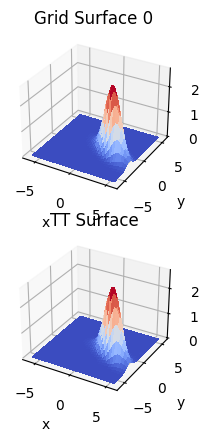

In [68]:
eps=1.0e-14
rma=6
dim=2
d=5
npt=2**d
xmin=-6.0
xmax=6.0
dx=(xmax-xmin)/npt
x=np.zeros(npt)

gam = np.zeros((dim,dim),dtype=complex)
gam[0][0] = 1 + 1j
gam[0][1] = 1
gam[1][0] = 1
gam[1][1] = 2 - 1j

r = np.zeros(dim)
rj = np.zeros(dim)
pk = np.zeros(dim,dtype=complex)
rj[0]=0.5
rj[1]=0.2
pk[0]=1.0+1j
pk[1]=1j

# Analytical solution GI = \sqrt((2*pi)^n/det(gam))*exp(rk^t gam^{-1} rk/2)          
detgam = np.linalg.det(gam)
gami = np.linalg.pinv(gam)
IG=2*np.pi/np.sqrt(detgam)*np.exp(np.dot(pk,np.matmul(gami, pk))*0.5)
print("IG=",IG)
# Numerical solution                                                                 
# Define grid of coordinates                                                         
for i in range(npt):
  x[i] = xmin + i *dx
rx, ry = np.meshgrid(x, x)
# Visualize function generated on a grid                                             
norm2=0.0
G = np.zeros((npt,npt),dtype=complex)
for i in range(npt):
  for j in range(npt):
    r[0] = x[j]
    r[1] = x[i]
    G[i][j] = fun(r)
#   norm2=norm2+G[i][j]*np.conjugate(G[i][j])                               
    norm2=norm2+G[i][j]
print("Norm G=",norm2*dx*dx)
ax= plt.subplot(2,1,1, projection='3d')
ax.plot_surface(rx, ry, np.abs(G), cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Grid Surface 0")

# Define tuple of tensor trains txx  for coordinates                                 
ttone=tt.tensor(np.ones(2**d))
xx=tt.tensor(x)

# Quantics
ttone=tt.ones(2, d)
xx=tt.tensor(np.reshape(x, [2]*d))

txx = [gen_1d(xx,ttone,i,dim) for i in range(dim)]
ttoned=tt.kron(ttone,ttone)
# Generate tensor train representation of the function sf                            
ttVV =tt.multifuncrs2(txx, sff, eps ,verb=0)
ttVV = ttVV.round(eps,rma)
#    print("Norm ttVV",ttVV.norm()**2*dx**dim)
print("Norm ttVVd",tt.dot(ttoned,ttVV)*dx**dim)
# Visualize function generated with tensor train                                     
ax= plt.subplot(2,1,2, projection='3d')
# Evaluate tensor without using full()
dd=[d,d]
VV2 = np.zeros((npt,npt),dtype=complex)
for i in range(np.size(x)):
    for j in range(np.size(x)):
        ind=[i,j]
        VV2[i][j]=ttVV[bi(ind,dd)]

#VV2=np.reshape(ttVV.full(),[npt, npt])
ax.plot_surface(rx, ry, np.abs(VV2), cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("TT Surface")
plt.show()

##### **3.3. Tensor Inversion**

A simple way of inverting a tensor is by using the cross-approximation, as follows:

In [69]:
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

In [70]:
N=2 # number of modes
d=5; ns = 2**d # number of grid points
x=3+2*(np.linspace(0,ns-1,ns)*2/ns-1)  # grid point values
xx=np.reshape(x, [2]*d)  # folded in quantics format
xx = tt.tensor(xx)       # qtt format tensor for each normal coordinate
ttone=tt.ones(2, d)      # one qtt for other coordinates
ttx = [gen_1d(xx,ttone,i,N) for i in range(N)]  # array of normal coordinates 

In [71]:
def finv(f):
  nevals, dim = f.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
    out[ii] = 1e14
    if f[ii] != 0:
      out[ii] = 1/f[ii]
  return out

In [72]:
xxinv=tt.multifuncrs([xx], finv, eps= 1e-14,verb=0)

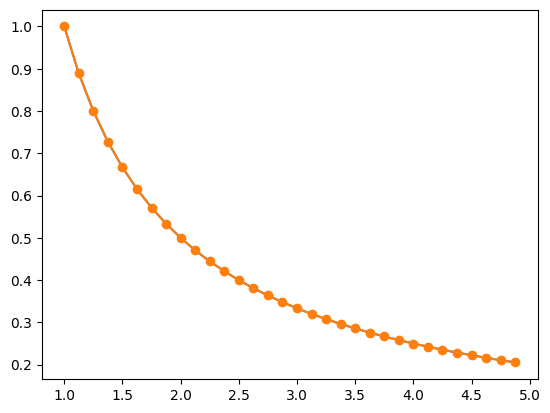

In [73]:
plt.plot(x,np.reshape(xxinv.full(),ns))
plt.plot(x,1/x,'-o')

##### **3.4. DMD by tensor inversion**

The goal of this subsection is to introduce the tensor inversion method to solve the problem of finding the tensor A that fulfills the following equation of motion:
\begin{equation}
y = A x
\end{equation}
where $x = v_1,v_2,\dots ,v_{n−1}$, and $y = v_2,v_3,\dots ,v_n$ are given tensors of data collected at $n$ equally spaced times $t_j = j \tau$, with $j=1$--$n$. Here, we solve for $A$ using $x$ and $y$, as follows:
\begin{equation}
A = y x^{-1}
\end{equation}
 

In [74]:
def finv(f):
  nevals, dim = f.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
    out[ii] = 1e14
    if f[ii] != 0:
      out[ii] = 1/f[ii]
  return out

In [75]:
tx=tt.rand(5,4)
A=tx
ty=A*tx
txinv=tt.multifuncrs([tx], finv, eps= 1e-14,verb=0)

In [76]:
def AA(x):
  nevals, D = x.shape
  out = np.zeros((nevals,))
  for i in range(nevals):
    out[i] = x[i,0]*x[i,1]
  return out 

In [77]:
Approx=tt.multifuncrs([ty,txinv], AA, eps= 1e-14,verb=0)

In [78]:
diff=Approx-A
print("error=",diff.norm())

error= 8.465710710140505e-14


In [79]:
si=(txinv*tx).full(); np.shape(si)

(5, 5, 5, 5)

##### **3.5. DMD with scikit_tt**

We use the TT class from [scikit_tt](https://github.com/PGelss/scikit_tt)

Using sequential data for $x$ and $y$, as described above, to solve for $A$ from equation $y = A x$  is precisely what is typically done by [dynamical mode decomposition (DMD)](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition). DMD formulates the problem with continuous time-dependent variables, $A=e^{\mathcal{A}\tau}$, and $y=x(\tau)$, as follows:
\begin{equation}
x(t) = e^{\mathcal{A}t} x(0)
\end{equation}
so
\begin{equation}
\dot{x}(t) = \mathcal{A} e^{\mathcal{A}t} x(0) = \mathcal{A} x(t)
\end{equation}
The initial state $x(0)=\sum_k c_k \Gamma_k$ is written as a linear combination of eigenvectors $\Gamma_k$ of $\mathcal{A}$ (which are also eigenvectors of $A$ since $\lambda_k = \Gamma_k^t A \Gamma_k = e^{\Gamma_k^t \mathcal{A} \Gamma_k t}$). Then, $x(t)$ is propagated analytically in that basis, as follows: $x(t)=\sum_k c_k e^{\lambda_k t} \Gamma_k$, where $\mathcal{A} \Gamma_k = \lambda_k \Gamma_k$. DMD finds the eigenvectors of $\mathcal{A}$ by diagonalizing the small matrix $\tilde{A}=U^t A U$, where $U$ is the orthogonal matrix obtained by svd of $x = U \Sigma V^t$, keeping only a few of the singular values of $\Sigma$ (only a few of the columns of U). We note that $y = A U \Sigma V^t$, gives a practical way of computing $\tilde{A}= U^t A U$, as follows: $\tilde{A} = U^t y V \Sigma^{-1}$. 

In [80]:
!pip install git+https://github.com/PGelss/scikit_tt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PGelss/scikit_tt to /tmp/pip-req-build-5r77nomf
  Running command git clone --filter=blob:none --quiet https://github.com/PGelss/scikit_tt /tmp/pip-req-build-5r77nomf
  Resolved https://github.com/PGelss/scikit_tt to commit 253f1cda23e02b33df93ae2e279b397be59878e7
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-tt: filename=scikit_tt-1.0-py3-none-any.whl size=87452 sha256=4062357eedc9e13f8298bed4ad05ee679b889f0ccd89ffffd02e80e09d348de6
  Stored in directory: /tmp/pip-ephem-wheel-cache-g6tbyw7_/wheels/e9/3e/3f/5044693a7a03d2a45984f7731e052becd6587723340616886c
Successfully built scikit-tt


In [81]:
import numpy as np
import os
import sys
import scipy.linalg as lin
from scikit_tt.tensor_train import TT
import scikit_tt.data_driven.tdmd as tdmd
import matplotlib.pyplot as plt
import scikit_tt.utils as utl
import time as _time

##### **Functions for DMD**

In [82]:
def gau(r,r0):
    x=r-r0
    return(np.exp(-x**2))

def dmd_exact(x_data, y_data):
    # decompose x                                                                                
    u, s, v = lin.svd(x_data, full_matrices=False, overwrite_a=True, 
                      check_finite=False, lapack_driver='gesvd')
    # construct reduced matrix
    reduced_matrix = u.T @ y_data @ v.T @ np.diag(np.reciprocal(s))
    # find eigenvalues
    eigenvalues, eigenvectors = lin.eig(reduced_matrix, overwrite_a=True, 
                                        check_finite=False)
    # sort eigenvalues
    ind = np.argsort(eigenvalues)[::-1]
    dmd_eigenvalues = eigenvalues[ind]
    # compute modes
    dmd_modes = y_data @ v.T @ np.diag(np.reciprocal(s)) @ eigenvectors[:, ind] \
        @ np.diag(np.reciprocal(dmd_eigenvalues))
    # overlap matrix
    nm = np.size(dmd_eigenvalues)
    S = np.zeros((nm,nm),dtype=complex)
    for j in range(nm):
        for k in range(nm):
            S[j][k]=np.vdot(dmd_modes[:,j],dmd_modes[:,k])
    # invert S
    Sinv = lin.inv(S)
    return S, Sinv, dmd_eigenvalues, dmd_modes

##### **Example: Propagation of Oscillatory Gaussian**

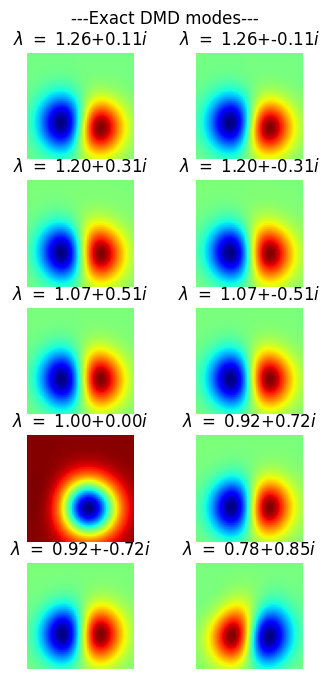

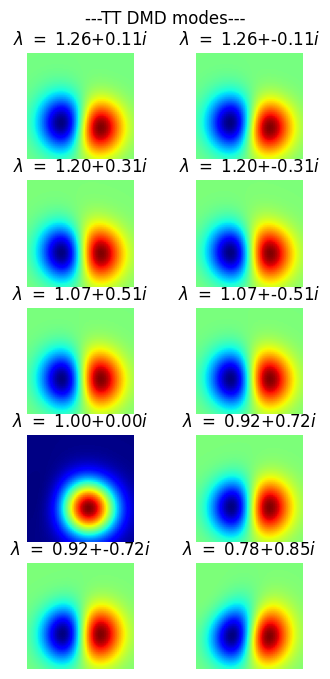

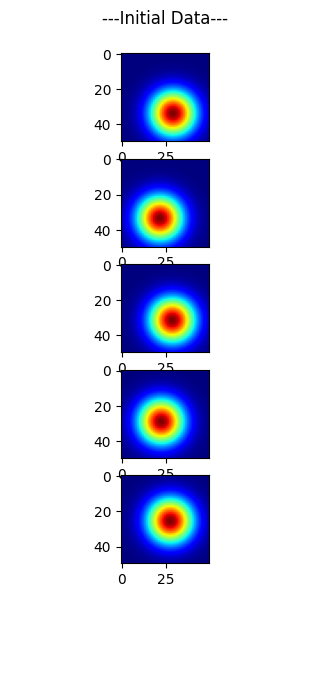

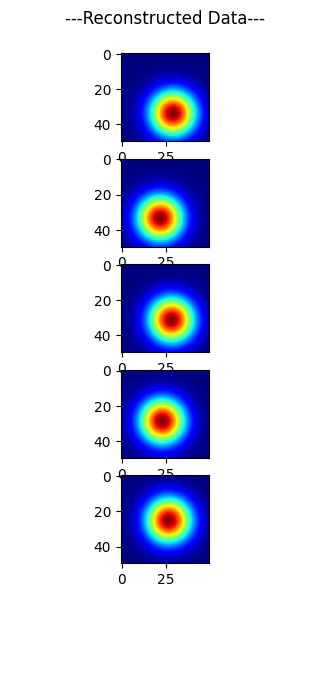

In [83]:
nt=30
npt=50
nmo=10
wx=np.pi/npt
wy=np.pi/npt + .5
dz=4/npt
z=(np.arange(npt)-npt/2)*dz
# generate time dependent data
data = np.zeros((npt,npt,nt))
for k in range(nt):
    rx=0.7*np.cos(k*wx)
    ry=0.3*np.cos(k*wy)
    for i in range(npt):
        for j in range(npt):
            data[i][j][k] = gau(z[i],rx) * gau(z[j],ry)

# construct tensors y and x corresponding to y = A x
number_of_snapshots = data.shape[-1] - 1
x = data[:, :, 0:number_of_snapshots].reshape(\
    data.shape[0] * data.shape[1], number_of_snapshots)
y = data[:, :, 1:number_of_snapshots + 1].reshape(\
    data.shape[0] * data.shape[1], number_of_snapshots)

# apply exact DMD
S, Sinv, eigenvalues_dmd, modes_dmd = dmd_exact(x, y)
# Check S*Sinv
#print("ov=",S.dot(Sinv)

# reshape result for comparison                                  
modes_dmd = modes_dmd.reshape([data.shape[0], data.shape[1], number_of_snapshots])

# plot nmo modes
f = plt.figure(figsize=plt.figaspect(2))
plt.title("---Exact DMD modes---\n")
plt.axis('off')
for j in range(nmo):
    ax = f.add_subplot(int(nmo/2), 2, j + 1, aspect=0.5)
    ax.imshow(np.real(modes_dmd[:, :,j]), cmap='jet')
    plt.axis('off')
    ev = eigenvalues_dmd[j]
    plt.title(r'$\lambda ~ = ~ $' + str("%.2f" % np.real(ev)) + '+' + \
                  str("%.2f" % np.imag(ev)) + r'$i$')

# tt DMD implementation
# construct x and y tensors and convert to TT format
x = TT(data[:, :, 0:number_of_snapshots, None, None, None])
y = TT(data[:, :, 1:number_of_snapshots + 1, None, None, None])
# define lists                                                              
eps=0                                      
eigenvalues_tdmd = [None]
modes_tdmd = [None]
# apply exact TDMD TT
eigenvalues_tdmd, modes_tdmd = tdmd.tdmd_exact(x, y, threshold=eps)
# convert to full format for comparison and plotting
modes_tdmd = modes_tdmd.full()[:, :, :, 0, 0, 0]
# plot nmo modes
ff = plt.figure(figsize=plt.figaspect(2))
plt.title("---TT DMD modes---\n")
plt.axis('off')
for j in range(nmo):
    ax = ff.add_subplot(int(nmo/2), 2, j + 1, aspect=0.5)
    ax.imshow(np.real(modes_tdmd[:,:,j]), cmap='jet')
    plt.axis('off')
    ev = eigenvalues_tdmd[j]
    plt.title(r'$\lambda ~ = ~ $' + \
                  str("%.2f" % np.real(ev)) + '+' + \
                  str("%.2f" % np.imag(ev)) + r'$i$')


# Expansion coefficients of initial state in terms DMD modes
rx=0.7
ry=0.3
nm=np.size(eigenvalues_dmd)
nm2 = 20
#print("np.size(eigenvalues_dmd)=",nm)
ck=np.zeros(nm,dtype=complex)
for k in range(nm2):
    for i in range(npt):
        for j in range(npt):
            for jj in range(nm):
                ck[k] = ck[k] + Sinv[k][jj]*np.conjugate(modes_dmd[i,j,jj]) \
                    * gau(z[i],rx) * gau(z[j],ry) 
# time-dependent reconstructed data
datar = np.zeros((npt,npt,nt),dtype=complex)
for k in range(nt):
    norma=0.0
    for i in range(npt):
        for j in range(npt):
            for kk in range(nm2):
                aa = np.angle(eigenvalues_dmd[kk])
                ra = np.absolute(eigenvalues_dmd[kk])
                datar[i][j][k] = datar[i][j][k] + \
                    modes_dmd[i,j,kk] * ck[kk] * ra**k * np.exp(1j*k*aa)
            norma = norma + datar[i][j][k] * dz**2
#    print("norma2=",norma)

# visualize time-dependent data
num=6
nt2=int(nt/num)
stri=int(nt/nt2)
f = plt.figure(figsize=plt.figaspect(2.))
plt.title("---Initial Data---\n")
plt.axis('off')
for j in range(nt2):
    i=j*stri
    ax = f.add_subplot(num, 1, 1+j, aspect=0.5)
    ax.imshow(np.real(data[:, :,i]), cmap='jet')

# visualize time-dependent reconstructed data
f = plt.figure(figsize=plt.figaspect(2.))
plt.title("---Reconstructed Data---\n")
plt.axis('off')
for j in range(nt2):
    i=j*stri
    ax = f.add_subplot(num, 1, 1+j, aspect=0.5)
    ax.imshow(np.real(datar[:, :,i]), cmap='jet')

#### **4. Minimum of a Function**

tt_min finds (approximate) minimal value of the function on a d-dimensional grid by using a TT-cross-based minimization procedure

In [84]:
from tt.optimize import tt_min

##### **4.1. Example 1:** Minimize 4-d [Rosenbrock function](https://www.sfu.ca/~ssurjano/rosen.html) on a 4-dimensional grid

In [85]:
from scipy.optimize import rosen

In [86]:
def my_rosen(x):
    return rosen(x.T)

In [87]:
print("Minimize 4-d Rosenbrock function on a 4-dimensional grid (512 points " +
      "along each dimension). The global minimum is 0 in the (1, 1, 1, 1) point.")
val, x_full = tt_min.min_func(my_rosen, -2, 2, d=4, n0=512, rmax=10, nswp=30)

Minimize 4-d Rosenbrock function on a 4-dimensional grid (512 points along each dimension). The global minimum is 0 in the (1, 1, 1, 1) point.
New record: 33.573321388975984 Point: [ 0.71624266 -0.03522505 -0.10567515  0.01174168] fevals: 5120
New record: 2.5577146220481635 Point: [0.71624266 0.39530333 0.16046967 0.01174168] fevals: 66560
New record: 1.236924328045427 Point: [0.88062622 0.71624266 0.46575342 0.27005871] fevals: 138240
New record: 0.32889345974026457 Point: [1.01369863 1.02935421 1.11545988 1.24853229] fevals: 144384
New record: 0.08680339384550623 Point: [1.01369863 1.05283757 1.11545988 1.24853229] fevals: 258048
New record: 0.06157268788482656 Point: [1.01369863 1.04500978 1.09197652 1.17808219] fevals: 601088
New record: 0.03170887800528188 Point: [1.02152642 1.04500978 1.09197652 1.17808219] fevals: 607744
New record: 0.016760184478238124 Point: [1.02152642 1.04500978 1.08414873 1.17808219] fevals: 791552
New record: 0.008737878615691624 Point: [1.00587084 1.01369

##### **4.2. Example 2:** Find minimum of a random 5-dimensional TT tensor

In [88]:
tens = tt.rand([3, 4, 5, 4, 3], 5, 3)
min_element = min(tens.full().flatten())
print("Minimize random 5-dimensional TT tensor with ranks equal to 3. " +
      "The minimal element is %f" % min_element)
val, point = tt_min.min_tens(tens, rmax=10, nswp=30)

Minimize random 5-dimensional TT tensor with ranks equal to 3. The minimal element is -102.228897
New record: -9.154968005718288 Point: [0 1 4 1 1] elements seen: 30
New record: -20.02196407387574 Point: [0 1 4 0 1] elements seen: 150
New record: -102.22889697912093 Point: [2 0 4 0 1] elements seen: 700
New record: -102.22889697912093 Point: [2 0 4 0 1] elements seen: 844


#### **5. Expansions of Functions** 

#####**5.1. Chebyshev Expansion**

Arbitrary functions of TT-vector or TT-matrices can be obtained as Chebyshev expansions generated by the Clenshaw algorithm.

The Chebyshev expansion of $f(x)$ is defined, as follows:
\begin{equation}
f(x) = \frac{c_0}{2} + \sum_{j=1}^{\infty} c_j T_j(x),
\end{equation}
where 
\begin{equation}
c_j = \frac{2}{\pi} \int_0^{\pi} f(cos(\theta))~\text{cos}(j\theta) d\theta
\end{equation}

Discretizing the integral, we obtain:
\begin{equation}
c_j = \frac{2}{n} \sum_{k=0}^{n-1} f(cos((k+0.5)\frac{\pi}{n})~\text{cos}(j (k+0.5)\frac{\pi}{n})
\end{equation}
which corresponds to the expression in the cell above when $b=1$ and $a=-1$.


In the particular case of $f(x)=e^{i\omega x}$, we obtain:
\begin{equation}
c_j = \frac{2}{\pi} \int_0^{\pi} e^{\text{cos}\theta} \text{cos}(j\theta) d\theta=2~i^j J_j(\omega)
\end{equation}

**Clenshaw algorithm:**

Given
\begin{equation}
x=\frac{2}{(b-a)} \left(A-\frac{(a+b)}{2}I \right)
\end{equation}
initialize $d_{m+1}=d_{m}=0$ and recursively compute
\begin{equation}
d_k = c_k v + 2 x d_{k+1}- d_{k+2}~~\text{for}~~k=m-1,m-2, \dots, 0
\end{equation}
to obtain:
\begin{equation}
e^{-i A \tau} v \approx  \frac{c_0}{2} v + x d_{1}- d_{2}.
\end{equation}

In [89]:
  # Clenshaw algorithm: Generates a tt of an arbitrary function func
  # x is in TT format, either TT-vector or TT-matrix
  # v could be provided as an argument to compute func*v (as in exp_clen)
  def func_clen(x,func,v=None):
    b=1;a=-1; bma = 0.5 * (b - a); bpa = 0.5 * (b + a); n=20; eps=1e-14
    f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
    fac = 2.0 / n
    c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
              for k in range(n)]) for j in range(n)]
    #c = [2*(1j)**j * sp.jv(j,-1j) for j in range(n)] # when func = np.exp
    
    if v == None:
    #   v=tt.eye(x.n[0],x.d)               # for exp(x), when x is a tt-matrix
      v=tt.ones(x.n[0],x.d)              # for exp(x), when x is a tt-vector

    y=x
    y2 = 2.0 * y
    (d, dd) = (c[-1]*v, 0*v)             # Special case first step for efficiency
    # Clenshaw's recurrence
    for cj in c[-2:0:-1]:
    #  (d, dd) = (tt.matvec(y2,d) - dd + v * cj, d)    # to compute func*v 
      (d, dd) = (y2 * d - dd + v * cj, d)
      d=d.round(eps)
      dd=dd.round(eps)
    # out = tt.matvec(y, d) - dd + 0.5 * c[0]*v        # to compute func*v 
    out = y * d - dd + 0.5 * c[0]*v
    return out.round(eps)

**Example:** Generate the QTT representation of $\text{fun}(x)~=~\text{cos}(10~x)~\times~\text{sin}(4~x)$

In [90]:
def fun(x):
  out=np.cos(10*x)*np.sin(4*x)
#  out=np.exp(x)
  return out

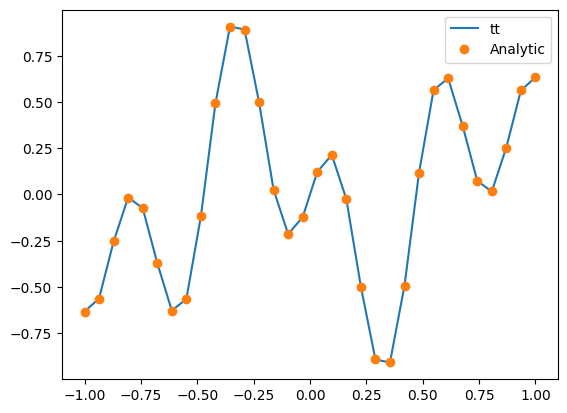

In [91]:
d=5;x=np.linspace(-1,1,num=2**d)
x=tt.tensor(np.reshape(x,[2]*d))
xn=np.reshape(x.full(),[2**d])

fn=np.reshape(func_clen(x,fun).full(),[2**d])
plt.plot(xn,fn,label='tt')
plt.plot(xn,fun(xn),'o',label='Analytic')
plt.legend()

In [92]:
fn=func_clen(x,fun)
print("rank=", fn.r)

rank= [1 2 4 4 2 1]


##### **5.2. Taylor Series of the Exponential: Scaling and Squaring**

In [93]:
# Taylor series of exp(A) where A is a QTT-matrix 
def expA(A,eps=None,rmax=None,N=None):
    global d
    if eps == None:
      eps=1e-14
    if rmax == None:
      rmax= 4
    if N == None:
      N=10
    w0=A*(1.0/2**N)
    e=tt.ones(2,d)   # when A is a TT-tensor
#    e=tt.eye(2,d)   # when A is a TT-matrix
    tm=e
    k=N-1
    while k > 0:
        tm=e+tm*w0*(1.0/k)
        tm=tm.round(eps,rmax)
        k=k-1
    while k < N:
        tm=tm*tm
        tm=tm.round(eps,rmax)
        k=k+1
    return tm

**Example:** Generate the QTT representation of $\text{fun}(x)~=~\text{exp}(-2~x)$

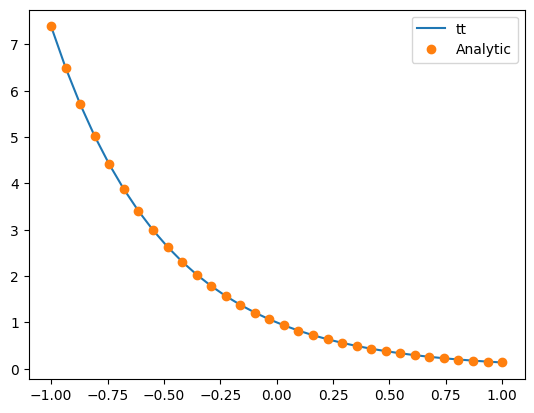

In [94]:
# Example
d=5;x=np.linspace(-1,1,num=2**d)
x=tt.tensor(np.reshape(x,[2]*d))
xn=np.reshape(x.full(),[2**d])

fn=expA(-2*x)
fn=np.reshape(fn.full(),[2**d])
plt.plot(xn,fn,label='tt')
plt.plot(xn,np.exp(-2*xn),'o',label='Analytic')
plt.legend()

#### **6. FFT of Tensor Trains**

Multdimensional FFT of a tensor train can be easily performed by FFT of each core with respect to the physical indices

In [95]:
def mfft(f,ind):    # non-quantics (warning!)
    # multidimensional fft of function f in (non-quantics) tt format                           
    # ind=1 for fft, otherwise ifft 
    y=tt.tensor.to_list(f)              # makes a list of cores
    d=len(y)
    for k in range(len(y)):             # core index
      for i in range(y[k].shape[0]):    
        for j in range(y[k].shape[2]):
          if ind == 1:
            y[k][i,:,j]=np.fft.fft(y[k][i,:,j])*4/len(y[k][i,:,j])
          else:
            y[k][i,:,j] = np.fft.ifft(y[k][i,:,j])*len(y[k][i,:,j])/4
    return tt.tensor.from_list(y)       # builds TT from cores

In [96]:
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

In [97]:
def fun(r):
# Generic Gaussian: out = exp(-(r-rj)^t gam (r-rj)/2 + pk^t (r-rj))
    global gam,pk,rj
    out=np.exp(-np.dot((r-rj),np.matmul(gam,(r-rj))*0.5)+np.dot(pk,(r-rj)))
    return out

def sff(r):
    global rj,pk,gam
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        out[ii]=np.exp(-np.dot((r[ii,:]-rj[:]),np.matmul(gam,(r[ii,:]-rj[:]))*0.5)
                       +np.dot(pk,(r[ii,:]-rj[:])))
    return(out)

Elapsed time: 0.0013551712036132812


Text(0.5, 0.92, 'Grid Surface 0')

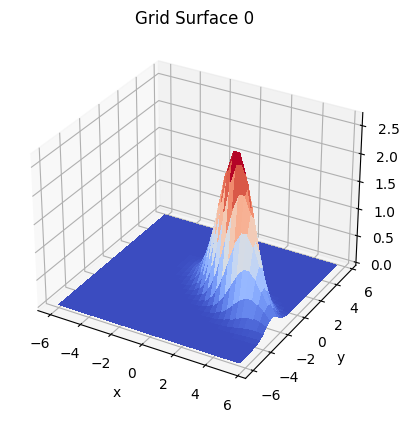

In [98]:
# FFT using mfft

eps=1e-14
dim=2;d=5;npt=2**d;
xmin=-6;xmax=6;dx=(xmax-xmin)/npt

ttone=tt.tensor(np.ones(2**d),eps=1e-14)
x=np.arange(xmin,xmax,dx)
xx=tt.tensor(x)

rj = np.zeros(dim)
pk = np.zeros(dim,dtype=complex)
rj[0]=0.5
rj[1]=0.2
pk[0]=1.0+1j
pk[1]=1j

gam = np.zeros((dim,dim),dtype=complex)
gam[0][0] = 1 + 1j
gam[0][1] = 1
gam[1][0] = 1
gam[1][1] = 2 - 1j

# Define tuple of tensor trains txx  for coordinates                                 
txx = [gen_1d(xx,ttone,i,dim) for i in range(dim)]
ttoned=tt.kron(ttone,ttone)
# Generate tensor train representation of the function sf                            
ttVV =tt.multifuncrs2(txx, sff, eps ,verb=0)

t = time.time()
ttVV=mfft(ttVV,1)
print('Elapsed time:',time.time()-t)

# Inverse FFT
back = 1
if back == 1:
  ttVV=mfft(ttVV,-1)
  rx, ry = np.meshgrid(x, x)
  VV2=np.reshape(ttVV.full(),[npt, npt])
else:
  freq = np.fft.fftfreq(x.shape[-1],dx)
  freq = np.fft.fftshift(freq)
  VV2=np.reshape(ttVV.full(),[npt, npt])
  VV2 = np.fft.fftshift(VV2)
  rx, ry = np.meshgrid(freq, freq)

# Plot results
ax= plt.subplot(1,1,1, projection='3d')
ax.plot_surface(rx, ry, np.abs(VV2), cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Grid Surface 0")

#####Derivatives computed by Fourier Transform

###### Grid implemenation

In [99]:
def Deri(VV,dx,k):
    # Compute k-th derivative of VV
    npt=len(VV)
    freq = np.fft.fftfreq(npt,dx)
    FTVV = np.fft.fft(VV)
    out =np.fft.ifft(FTVV*(1j*2*np.pi*freq)**k)
    return out

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


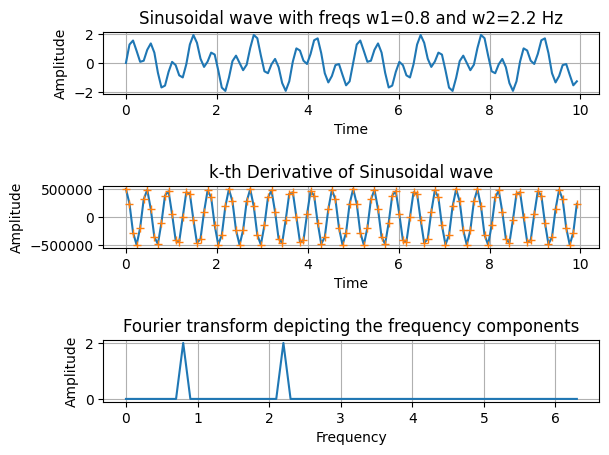

In [100]:
# Example of k-th derivative of a function by FFT on a 1-d grid

# Define grid
d=7;npt=2**d;L=10;xmin=0;xmax=L;dx=(xmax-xmin)/npt
t=np.arange(xmin,xmax,dx)

# Define function
w1 = 0.8; w2 = 2.2
VV = np.sin(2*np.pi*w1*t)+np.sin(2*np.pi*w2*t)

k=5
# Numerical derivative
VVk=Deri(VV,dx,k)

# Analytical derivative
if (k%2) == 0:
    VVp = (-1)**(k/2)*((2*np.pi*w1)**k*np.sin(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.sin(2*np.pi*w2*t))
else:
    VVp = (-1)**((k-1)/2)*((2*np.pi*w1)**k*np.cos(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.cos(2*np.pi*w2*t))

# Plot results
figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)

# Time domain representation for sine wave 1
axis[0].set_title('Sinusoidal wave with freqs w1=0.8 and w2=2.2 Hz')
axis[0].plot(t, VV)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
axis[0].grid()

# Time domain representation for sine wave 1
axis[1].set_title('k-th Derivative of Sinusoidal wave')
axis[1].plot(t, VVk)
axis[1].plot(t, VVp,'+')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
axis[1].grid()

# Frequency domain representation
FTVV = np.fft.fft(VV)*4/npt
freq = np.fft.fftfreq(npt,dx)
FTVV = FTVV[range(int(npt/2))]
freq = freq[range(int(npt/2))]
axis[2].set_title('Fourier transform depicting the frequency components')
axis[2].plot(freq, abs(FTVV))
axis[2].set_xlabel('Frequency')
axis[2].set_ylabel('Amplitude')
axis[2].grid()

plt.show()

###### TT Implementation

In [101]:
def sf2(r):
    global rj,pk,gam
    w1 = 0.8; w2 = 2.2
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        #out[ii]=np.exp(1j*2*np.pi*w1*r[ii,:]-r[ii,:]*r[ii,:])
        out[ii]=np.sin(2*np.pi*w1*r[ii,:])+np.sin(2*np.pi*w2*r[ii,:])
    return(out)

In [102]:
def ttDeri(f,dx,kk):  # non-quantics
    # kk-th gradient of f 
    y=tt.tensor.to_list(f)              # makes a list of cores
    yc=np.empty_like(y, dtype=complex)
    pp=np.fft.fftfreq(len(y[0][0,:,0]),dx)
    for k in range(len(y)):             # core index
      for i in range(y[k].shape[0]):    
        for j in range(y[k].shape[2]):
            yc[k][i,:,j]=np.fft.fft(y[k][i,:,j])*4/len(y[0][0,:,0])
            for l in range(kk):
                yc[k][i,:,j]=1j*2*np.pi*np.transpose(pp)*yc[k][i,:,j]
    out=tt.tensor.from_list(yc)       # builds TT from cores
    return mfft(out,-1)

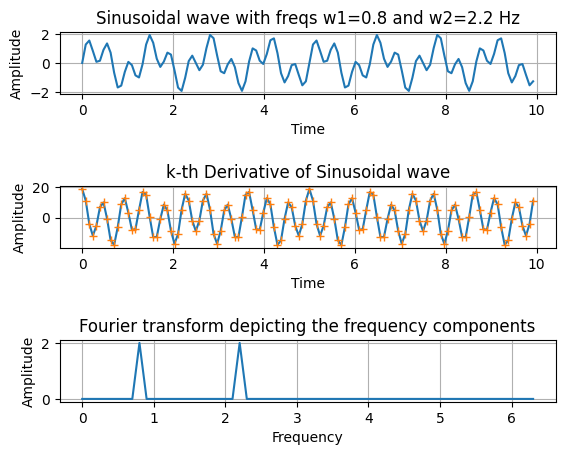

In [103]:
eps=1e-14
dim=1;d=7;npt=2**d
L=10;
xmin=0
xmax=L
dx=(xmax-xmin)/npt
t=np.arange(xmin,xmax,dx)

xx=tt.tensor(t)
p = np.fft.fftfreq(npt,dx)

# Generate tensor train representation of sf                            
ttVV =tt.multifuncrs2([xx], sf2, eps ,verb=0)
VV=ttVV.full().reshape(npt)

k=1
# Numerical k-th gradient of ttVV
VVk=ttDeri(ttVV,dx,k)
VVk=VVk.full().reshape(npt)

# Analytical k-th gradient
w1 = 0.8; w2 = 2.2
if (k%2) == 0:
    VVp = (-1)**(k/2)*((2*np.pi*w1)**k*np.sin(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.sin(2*np.pi*w2*t))
else:
    VVp = (-1)**((k-1)/2)*((2*np.pi*w1)**k*np.cos(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.cos(2*np.pi*w2*t))

# Plot results
figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)

# Time domain representation for sine wave 1
axis[0].set_title('Sinusoidal wave with freqs w1=0.8 and w2=2.2 Hz')
axis[0].plot(t, VV)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
axis[0].grid()

# Time domain representation for sine wave 1
axis[1].set_title('k-th Derivative of Sinusoidal wave')
axis[1].plot(t, VVk)
axis[1].plot(t, VVp,'+')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
axis[1].grid()

# Frequency domain representation
#FTVV = np.fft.fft(VV)*4/npt
FTVV = mfft(ttVV,1)
FTVV = FTVV.full().reshape(npt)

freq = np.fft.fftfreq(npt,dx)
FTVV = FTVV[range(int(npt/2))]
freq = freq[range(int(npt/2))]
axis[2].set_title('Fourier transform depicting the frequency components')
axis[2].plot(freq, abs(FTVV))
axis[2].set_xlabel('Frequency')
axis[2].set_ylabel('Amplitude')
axis[2].grid()

plt.show()

###### QTT 1-D Implementation

Discrete FT by matrix vector multiplication in QTT format

In [104]:
# 1-D Discrete Fourier transform (DFT) matrix in quantics tt (ind=-1 for inverse)
def FTM(d,ind):
    npt=2**d
    out = np.zeros((npt,npt),dtype=complex)
    for k in range(npt):
        for j in range(npt):
            out[k,j]=np.exp(-1j*ind*2*np.pi*k*j/npt)
    return out.reshape([2]*2*d)

In [105]:
# Computes 1-dimensional DFT of ttVV in quantics tt format
def qttDFT(ttVV,d,ind):
    coeff=4/2**d
    ttFT=tt.matrix(FTM(d,ind))
    return tt.matvec(ttFT,ttVV)*coeff

In [106]:
# Define k-th gradient of 1-dimensional ttVV in quantics tt format
# The function must be zero at the edges of the grid to avoid Fourier ripples
def dertt(ttVV,k):  
    d=ttVV.d
    coeff=1/(2**d)
    ttFT=tt.matrix(FTM(d,1)); ttiFT=tt.matrix(FTM(d,-1))
    w = tt.tensor(np.fft.fftfreq(2**d,dx).reshape([2]*d))
    temp=tt.matvec(ttFT,ttVV)
    for j in range(k):
        temp = temp*w*1j*2*np.pi
        temp=temp.round(eps=1e-14)
    out=tt.matvec(ttiFT,temp*coeff)
    return out.round(eps=1e-14)

Test of k-th gradient of a Gaussian

In [107]:
def sff(r):
    global ro,w1
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        rr=(r[ii,:]-ro)
        out[ii]=np.exp(1j*2*np.pi*w1*rr-rr*rr)
        #out[ii]=np.sin(2*np.pi*w1*r[ii,:])+np.sin(2*np.pi*w2*r[ii,:])
    return(out)

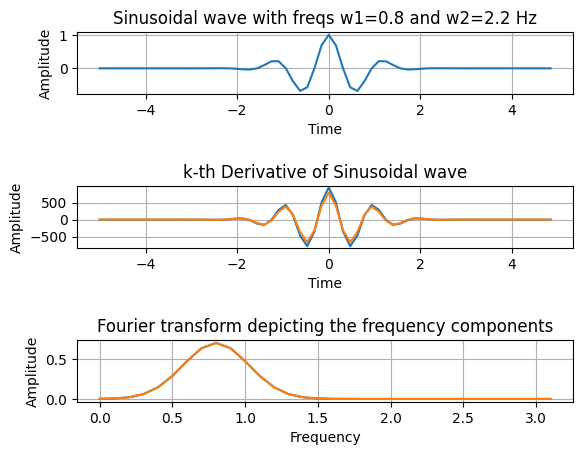

In [108]:
global ro,w1
ro=0;w1=0.8
d=6; npt=2**d;
L=10;
xmin=-L/2
xmax=L/2
dx=(xmax-xmin)/2**d
t=np.arange(xmin,xmax,dx)
xx=tt.tensor(t.reshape([2]*d))

# Define function
ttVV = tt.multifuncrs2([xx], sff, eps ,verb=0)
VV = ttVV.full().reshape(2**d)

# Compute k-th derivative of ttVV
k=4 
VVk=dertt(ttVV,k)
VVk=VVk.full().reshape(2**d)

# Analytical k-th gradient of sinusoidal function
#w1 = 0.8; w2 = 2.2
#if (k%2) == 0:
#    VVp = (-1)**(k/2)*((2*np.pi*w1)**k*np.sin(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.sin(2*np.pi*w2*t))
#else:
#    VVp = (-1)**((k-1)/2)*((2*np.pi*w1)**k*np.cos(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.cos(2*np.pi*w2*t))

# Analytical k-th gradient of Gaussian function
cw=1j*2*np.pi*w1-2*(t-ro); 
VV0 = VV
VVp = VV*cw;
for j in range(1,k):
    VV1=VVp
    VVp = VVp*cw-2*VV0
    VV0=VV1

# Plot results
figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)

# Time domain representation for sine wave 1
axis[0].set_title('Sinusoidal wave with freqs w1=0.8 and w2=2.2 Hz')
axis[0].plot(t, np.real(VV))
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
axis[0].grid()

# Time domain representation for sine wave 1
axis[1].set_title('k-th Derivative of Sinusoidal wave')
axis[1].plot(t, np.real(VVk))
axis[1].plot(t, np.real(VVp))
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
axis[1].set_ylim([min(np.real(VVp))*1.25,max(np.real(VVp))*1.25])
axis[1].grid()

# Frequency domain representation
FTVV = qttDFT(ttVV,d,1)
FTVV = FTVV.full().reshape(npt)
#FTVV = FTM(d).reshape((2**d,2**d)) @ ttVV.full().reshape(2**d)

freq = np.fft.fftfreq(npt,dx)
FTVV = FTVV[range(int(npt/2))]
freq = freq[range(int(npt/2))]

axis[2].set_title('Fourier transform depicting the frequency components')
axis[2].plot(freq, abs(FTVV))
# Analytic Fourier transform of Gaussian
axis[2].plot(freq, np.exp(-(np.pi*(freq-w1))**2)/np.sqrt(2))
axis[2].set_xlabel('Frequency')
axis[2].set_ylabel('Amplitude')
axis[2].grid()

plt.show()

###### QTT multidimensional implementation

Discrete FT by matrix vector multiplication in QTT format

In [109]:
# 1-D Discrete Fourier transform (DFT) matrix in quantics tt (ind=-1 for inverse)
def FTM(d,ind):
    npt=2**d
    out = np.zeros((npt,npt),dtype=complex)
    for k in range(npt):
        for j in range(npt):
            out[k,j]=np.exp(-1j*ind*2*np.pi*k*j/npt)
    return out.reshape([2]*2*d)

In [110]:
# Computes dim-dimensional DFT of ttVV in quantics tt format
def qttmDFT(ttVV,d,dim,ind):
    coeff=2*(4/2**d)**dim  # check normalization (doesn't look right)
    A0=tt.matrix(FTM(d,ind))
    ttFT=A0
    for j in range(1,dim):
        ttFT=tt.kron(A0,ttFT)
    return (tt.matvec(ttFT,ttVV)*coeff).round(eps=1e-14)

In [111]:
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

In [112]:
def fun(r):
# Generic Gaussian: out = exp(-(r-rj)^t gam (r-rj)/2 + pk^t (r-rj))
    global gam,pk,rj
    out=np.exp(-np.dot((r-rj),np.matmul(gam,(r-rj))*0.5)+np.dot(pk,(r-rj)))
    return out

def sff(r):
    global rj,pk,gam
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        out[ii]=np.exp(-np.dot((r[ii,:]-rj[:]),np.matmul(gam,(r[ii,:]-rj[:]))*0.5)
                       +np.dot(pk,(r[ii,:]-rj[:])))
    return(out)

Elapsed time: 0.043842315673828125


Text(0.5, 0.92, 'Grid Surface 0')

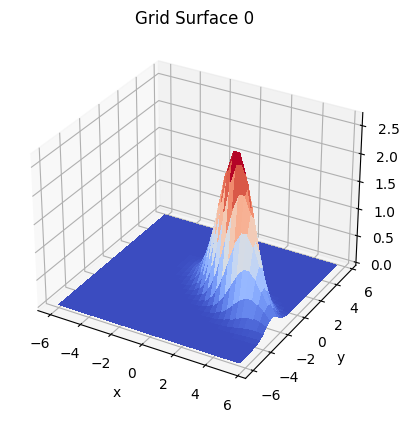

In [113]:
eps=1e-14
dim=2;d=5;npt=2**d;
xmin=-6;xmax=6;dx=(xmax-xmin)/npt

ttone=tt.tensor(np.ones(2**d).reshape([2]*d),eps=1e-14)

# Define qtt grid
x=np.arange(xmin,xmax,dx)
xx=tt.tensor(x.reshape([2]*d))

# Parameters for initial state
rj = np.zeros(dim)
pk = np.zeros(dim,dtype=complex)
rj[0]=0.5
rj[1]=0.2
pk[0]=1.0+1j
pk[1]=1j

gam = np.zeros((dim,dim),dtype=complex)
gam[0][0] = 1 + 1j
gam[0][1] = 1
gam[1][0] = 1
gam[1][1] = 2 - 1j

# Define tuple of tensor trains txx  for coordinates                                 
txx = [gen_1d(xx,ttone,i,dim) for i in range(dim)]
ttoned=tt.kron(ttone,ttone) # 2-dim implementation

# Generate tensor train representation of sff                            
ttVV =tt.multifuncrs2(txx, sff, eps ,verb=0)

t = time.time()
ttVV=qttmDFT(ttVV,d,dim,1)
print('Elapsed time:',time.time()-t)

# Inverse FFT
back = 1
if back == 1:
  ttVV=qttmDFT(ttVV,d,dim,-1)
  rx, ry = np.meshgrid(x, x)
  VV2=np.reshape(ttVV.full(),[npt, npt])
else:
  freq = np.fft.fftfreq(x.shape[-1],dx)
  freq = np.fft.fftshift(freq)
  VV2=np.reshape(ttVV.full(),[npt, npt])
  VV2 = np.fft.fftshift(VV2)
  rx, ry = np.meshgrid(freq, freq)

# Plot results
ax= plt.subplot(1,1,1, projection='3d')
ax.plot_surface(rx, ry, np.abs(VV2), cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Grid Surface 0")

#### **7. Dynamics**

#####**7.1. Dynamical Low-Rank Approximation**

The KSL method is a specific implementation of the Dynamical Low-Rank Approximation method, introduced by [Lubich and co-workers](https://arxiv.org/pdf/1407.2042.pdf), for propagation in a manifold of rank r states. The method provides an approximate solution of the differential equation, 
\begin{equation}
\dot{A}(t)=F(A(t)),
\end{equation}
where $A \in \mathcal{R}^{m \times n}$, defined by the $r$-rank approximation
\begin{equation}
Y(t)=U(t) S(t) V(t)^T,
\end{equation}
with $U(t) \in \mathcal{R}^{m \times r}$  and $V(t) \in \mathcal{R}^{n \times r}$ matrices with orthogonal columns, and $S(t) \in \mathcal{R}^{r \times r}$ not necessarily diagonal. Instead of obtaining the solution $A(t)$ and then generating an $r$-rank approximation by an (expensive) svd implementation, the DLRA solves the differential equation: 
\begin{equation}
\dot{Y}(t)=P_Y(F(Y)),
\end{equation}
with initial condition $Y(0)=A(0)$, where $P_Y$ is the projector operator onto the tangent plane $T_{Y(t)} \mathcal{M}_r(\mathcal{R}^{n \times m})$ that touches at $Y(t)$ the manifold of rank-$r$ states $\mathcal{M}_r(\mathcal{R}^{n \times m})$:


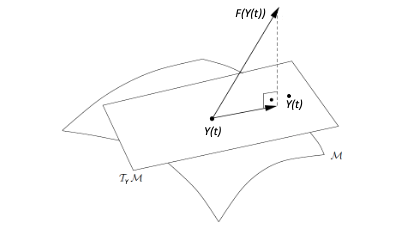

**Figure 1:** Representation of the tangent plane $T_{Y(t)} \mathcal{M}_r(\mathcal{R}^{n \times m})$ touching at $Y(t)$ the manifold of rank-$r$ states, $\mathcal{M}_r(\mathcal{R}^{n \times m})$. Note that $\dot{Y}(t)$ is on the tangent plane, while the residual error $\epsilon = F(Y(t))-\dot{Y}(t)$ is orthogonal to the tangent plane since $\dot{Y}(t)$ is obtained by projecting $F(Y)$ on the plane, as follows: $\dot{Y}(t)=P_Y(F(Y))$.

\\
Note that $\dot{Y}(t)$ is on the tangent plane, while the residual error $\epsilon = F(Y(t))-\dot{Y}(t)$ is orthogonal to the tangent plane since $\dot{Y}(t)$ is obtained by projecting $F(Y)$ on the plane, as follows: $\dot{Y}(t)=P_Y(F(Y))$.

\\
The dynamical low rank approximation section of the lecture notes shows that by imposing the gauge conditions,
\begin{equation}
U(t)^T \dot{U}(t) = V(t)^T \dot{V}(t) =0, 
\end{equation}
$S(t)$, $U(t)$, and $V(t)$ become uniquely defined by the following equations:
\begin{equation}
\dot{S}(t) = U^T F(Y) V,\\
\dot{U}(t) =(1-UU^T) F(Y) V S^{-1},\\
\dot{V}(t) =(1-VV^T) F(Y)^{T} U S^{-T}.\\
\end{equation}
Furthermore, it is shown that the projection operator $P_Y$ applied to a state $Z$ is defined, as follows: 
\begin{equation}
P_Y(Z)=Z-(1-UU^T) Z (1-VV^T),\\
=ZVV^T+UU^T-UU^TZVV^T.
\end{equation}
Therefore, the differential equation,
\begin{equation}
\dot{Y} =P_Y(F(Y)),\\
= F(Y) VV^T - UU^T F(Y)  VV^T+ UU^T F(Y),
\end{equation}
can be integrated by implementing the Lie-Trotter splitting method. 

\\



##### **7.1.1. Example 1:** Spin-1/2 Chain dynamics

[The Heisenberg Model Hamiltonian](https://en.wikipedia.org/wiki/Heisenberg_model_(quantum))

$\hat{H} = \sum_{k=0}^{N-1} \epsilon_k \hat{S}^z_k - \sum_{k=0}^{N-2} V_{k+1,k} [\hat{S}^x_{k+1} \hat{S}^x_{k}+\hat{S}^y_{k+1} \hat{S}^y_{k}]$

For a chain of N=20 spins, the simulation reproduces Fig. 3 from the article `Survival Collapse of the polarization in spin chains' by [E. Rufeil Fiori and H. M. Pastawski](https://arxiv.org/abs/quant-ph/0511176v2)

In [114]:
# Heisenberg Hamiltonian in TT-format
def ham(N):
    x = np.array([[0,1],[1,0]])
    y = np.array([[0,complex(0,-1)],[complex(0,1),0]])
    z = np.array([[1,0],[0,-1]])
    tt_x=tt.matrix(x)
    tt_y=tt.matrix(y)
    tt_z=tt.matrix(z)
    eps  = 1e-14
    eps0 = 1.3/2
    epsn = 2.0/2
    v0   = 0.75/2
    vn   = 1.0/2
    tt_H=0*tt.eye(2,N)
    tmp=tt_H
    k=0
    while k < N:
        if k == 0:
            tmp=tt.matrix(eps0*z)
            tmp=tt.kron(tmp,tt.eye(2,N-1))
        else:
            tmp=tt.kron(tt.eye(2,k),tt.matrix(epsn*z))
            tmp=tt.kron(tmp,tt.eye(2,N-k-1))
        tt_H=tt_H+tmp
        tt_H=tt_H.round(eps)
        k=k+1
    tt_HNNx=0*tt.eye(2,N)
    tt_HNNy=tt_HNNx
    tt_HNNz=tt_HNNx
    k=0
    while k < N-1:
        if k == 0:
            tmpX=tt.kron(tt_x,tt_x)*v0
            tmpY=tt.kron(tt_y,tt_y)*v0
            tmpZ=tt.kron(tt_z,tt_z)*0
        else:
            tmp=tt.eye(2,k);
            tmpX=tt.kron(tmp,tt.kron(tt_x,tt_x)*vn)
            tmpY=tt.kron(tmp,tt.kron(tt_y,tt_y)*vn)
            tmpZ=tt.kron(tmp,tt.kron(tt_z,tt_z)*0)
        if k < N-2:
            tmpX=tt.kron(tmpX,tt.eye(2,N-2-k))
            tmpY=tt.kron(tmpY,tt.eye(2,N-2-k))
            tmpZ=tt.kron(tmpZ,tt.eye(2,N-2-k))
        tt_HNNx=tt_HNNx+tmpX
        tt_HNNy=tt_HNNy+tmpY
        tt_HNNz=tt_HNNz+tmpZ
        k=k+1
    tt_H=tt_H+tt_HNNx+tt_HNNy+tt_HNNz
    tt_H=tt_H.round(eps)
    return tt_H;

In [115]:
# Taylor's expansion of exp(A): scaling and squaring algorithm
# A TT-matrix
def expA(A,eps):
  global Nspins,rmax
  N=10 # number of terms in Taylor's expansion
  w0=A*(1.0/2**N)
  e=tt.eye(2,Nspins)
  e=tt.matrix(e)
  tm=e
  k=N-1
  while k > 0:
      tm=e+tm*w0*(1.0/k)
      tm=tm.round(eps,rmax)
      k=k-1
  while k < N:
      tm=tm*tm
      tm=tm.round(eps,rmax)
      k=k+1
  return tm

In [116]:
# Chebyshev expansion of exp(A)*v, Clenshaw algorithm 
# A TT-matrix, v TT-vector 
from scipy.special import jv # Bessel function of the second kind
def exp_clen(A,v):
  eps=1e-14
  a=-1;b=1;n=12
#  Dp = a+b
  Dm = b-a
  d0=0*v; d1=d0
  for j in range(n):
    d2=d1
    d1=d0
    k = n-1-j
    ck=(-1j)**(k)*jv(k,1j)
#    d0=ck*v+tt.matvec(A,d1)*(4/Dm)-2*d1*(Dp/Dm)-d2
    d0=ck*v+tt.matvec(A,d1)*(4/Dm)-d2
    d0=d0.round(eps)      
  return d0-d2

In [117]:
  # Clenshaw algorithm: Generates a tt of an arbitrary function func
  # x is in TT format, either TT-vector or TT-matrix
  # v could be provided as an argument to compute func*v (as in exp_clen)
  def func_clen(x,func,v=None):
    b=1;a=-1; bma = 0.5 * (b - a); bpa = 0.5 * (b + a); n=12; eps=1e-14
    f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
    fac = 2.0 / n
    #c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
    #          for k in range(n)]) for j in range(n)]
    c = [2*(1j)**j * jv(j,-1j) for j in range(n)] # when func = np.exp
    nf=0
    if v == None:
       v=tt.eye(x.n[0],x.d)               # for exp(x), when x is a tt-matrix
    #  v=tt.ones(x.n[0],x.d)              # for exp(x), when x is a tt-vector
    else:
      nf=1

    y=x
    y2 = 2.0 * y
    (d, dd) = (c[-1]*v, 0*v)             # Special case first step for efficiency
    # Clenshaw's recurrence
    for cj in c[-2:0:-1]:
      if nf == 1:
        (d, dd) = (tt.matvec(y2,d) - dd + v * cj, d)    # to compute func*v 
      else:
        (d, dd) = (y2 * d - dd + v * cj, d)
      d=d.round(eps)
      dd=dd.round(eps)
    if nf == 1:
      out = tt.matvec(y, d) - dd + 0.5 * c[0]*v        # to compute func*v
    else:
      out = y * d - dd + 0.5 * c[0]*v
    return out.round(eps)

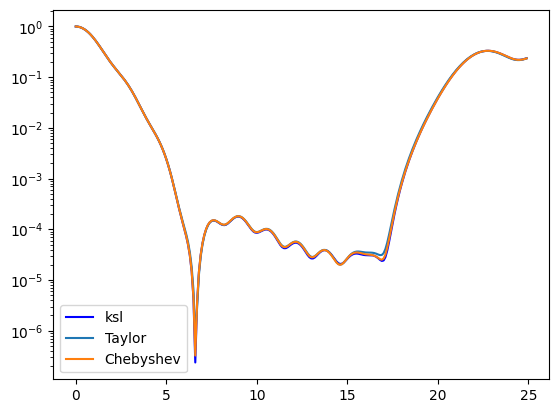

In [118]:
# Simulation
N = 20
Nspins = N
rmax=4
su = np.array([1,0])
sd = np.array([0,1])
tau=0.1
tfin=25
nsteps=250
eps=1e-14

y0=tt.tensor(su, eps)
for j in range(N-1):
    y0=tt.kron(y0,tt.tensor(sd, eps))

A = ham(N)*1j #complex(0.0,1.0)                                              
Atau=A*tau
eA= expA(Atau,eps) # Taylor expansion of exp(Atau)
eAc=func_clen(Atau,np.exp) # Chebyshev expansion of exp(Atau)

t= np.arange(0,tau*(nsteps),tau)
p = np.empty_like(t)
pr = np.empty_like(t)
pc = np.empty_like(t)

radd = 2 #Modify this to increase the rank                                  
if ( radd > 0 ):
    y0 = y0 + 1e-12*tt.rand(y0.n, y0.d, radd) #Hack, better by initialization                                                                              

#y0 = y0.round(-1)                                                          

y0 = y0.round(1e-14)
y = y0.copy()
yr = y0.copy()
yc = y0.copy()

for k in range(nsteps):
    if k > 0:
        y = tt.ksl.ksl(A, y, tau);
        yr = tt.matvec(eA, yr)
        yr=yr.round(eps,radd)
#        yc = tt.matvec(eAc, yc) 
        yc=exp_clen(Atau,yc)
##        yc=exp_clen(Atau*k,y0)
        yc=yc.round(eps,radd)
        ###        yc=func_clen(Atau,np.exp,yc)
    p[k] = abs(tt.dot(y,y0))**2
    pr[k] = abs(tt.dot(yr,y0))**2
    pc[k] = abs(tt.dot(yc,y0))**2
plt.yscale('log')
plt.plot(t,p,'b',label='ksl')
plt.plot(t,pr,'-',label='Taylor')
plt.plot(t,pc,'-',label='Chebyshev')
plt.legend()
plt.show()

#####**7.1.2. Example 2:** Spin-1/2 Hamiltonian with next-nearest-neighbor (NNN) couplings 
[Tavora, Torres-Herrea and Santos](https://arxiv.org/pdf/1610.04240v2.pdf) 



N$\acute{e}$el initial state: $\vert \text{NS} \rangle = \vert \uparrow \downarrow \cdots \uparrow \downarrow\rangle$

\begin{equation}
\begin{split}
H &= H_h + H_{NN} + \lambda H_{NNN}\\
H_h &= \sum_{k=0}^{N-1} h_k \hat{S}^z_k,\\
H_{NN} &= \sum_{k=0}^{N-2} J (\hat{S}^x_k \hat{S}^x_{k+1} +\hat{S}^y_k \hat{S}^y_{k+1} +\Delta \hat{S}^z_k \hat{S}^z_{k+1}),\\
H_{NNN} &= \sum_{k=0}^{N-2} J (\hat{S}^x_k \hat{S}^x_{k+2} +\hat{S}^y_k \hat{S}^y_{k+2} +\Delta \hat{S}^z_k \hat{S}^z_{k+2}),\\
\end{split}
\end{equation}

In [119]:
def hamNNN(N,eps):
    J2=0.25
    lamda=1.0
    de = 0.5
    x = np.array([[0,1],[1,0]])
    y = np.array([[0,complex(0,-1)],[complex(0,1),0]])
    z = np.array([[1,0],[0,-1]])
    tt_x=tt.matrix(x)
    tt_y=tt.matrix(y)
    tt_z=tt.matrix(z)

    tt_H=0*tt.eye(2,N)
    tt_HNNx=0*tt.eye(2,N)
    tt_HNNy=tt_HNNx
    tt_HNNz=tt_HNNx

    # HNN 
    k=0
    while k < N-1:
        if k == 0:
            tmpX=tt.kron(tt_x,tt_x)*J2
            tmpY=tt.kron(tt_y,tt_y)*J2
            tmpZ=tt.kron(tt_z,tt_z)*J2*de
        else:
            tmp=tt.eye(2,k);
            tmpX=tt.kron(tmp,tt.kron(tt_x,tt_x)*J2)
            tmpY=tt.kron(tmp,tt.kron(tt_y,tt_y)*J2)
            tmpZ=tt.kron(tmp,tt.kron(tt_z,tt_z)*J2*de)
        if k < N-2:
            tmpX=tt.kron(tmpX,tt.eye(2,N-2-k))
            tmpY=tt.kron(tmpY,tt.eye(2,N-2-k))
            tmpZ=tt.kron(tmpZ,tt.eye(2,N-2-k))
        tt_HNNx=tt_HNNx+tmpX
        tt_HNNy=tt_HNNy+tmpY
        tt_HNNz=tt_HNNz+tmpZ
        k=k+1
    tt_H=tt_H+tt_HNNx+tt_HNNy+tt_HNNz
    tt_H=tt_H.round(eps)

    # HNNN                                                                       
    tt_xx=tt.kron(tt_x,tt.eye(2,1))
    tt_xx=tt.kron(tt_xx,tt_x)*lamda*J2
    tt_yy=tt.kron(tt_y,tt.eye(2,1))
    tt_yy=tt.kron(tt_yy,tt_y)*lamda*J2                                                   
    tt_zz=tt.kron(tt_z,tt.eye(2,1))
    tt_zz=tt.kron(tt_zz,tt_z)*lamda*J2*de

    tt_HNNNx=0*tt.eye(2,N)
    tt_HNNNy=tt_HNNNx
    tt_HNNNz=tt_HNNNx

    for k in range(N-2):
        if k == 0:                                                                                 
            tmpX=tt_xx
            tmpY=tt_yy
            tmpZ=tt_zz
        else:
            tmp=tt.eye(2,k)
            tmpX=tt.kron(tmp,tt_xx)
            tmpY=tt.kron(tmp,tt_yy)
            tmpZ=tt.kron(tmp,tt_zz)
        if (k+3) < N:
            tmpX=tt.kron(tmpX,tt.eye(2,N-k-3))
            tmpY=tt.kron(tmpY,tt.eye(2,N-k-3))
            tmpZ=tt.kron(tmpZ,tt.eye(2,N-k-3))
        tt_HNNNx=tt_HNNNx+tmpX
        tt_HNNNy=tt_HNNNy+tmpY
        tt_HNNNz=tt_HNNNz+tmpZ
    tt_H=tt_H+tt_HNNNx+tt_HNNNy+tt_HNNNz
    tt_H=tt_H.round(eps)    

    return tt_H

In [120]:
# Taylor's expansion of exp(A): scaling and squaring algorithm
# A TT-matrix
def expA(A,eps):
  global Nspins,rmax
  N=10 # number of terms in Taylor's expansion
  w0=A*(1.0/2**N)
  e=tt.eye(2,Nspins)
  e=tt.matrix(e)
  tm=e
  k=N-1
  while k > 0:
      tm=e+tm*w0*(1.0/k)
      tm=tm.round(eps,rmax)
      k=k-1
  while k < N:
      tm=tm*tm
      tm=tm.round(eps,rmax)
      k=k+1
  return tm

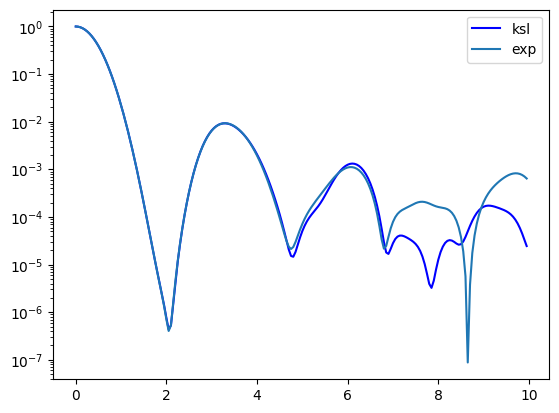

In [121]:
N = 16
Nspins =N
su = np.array([1,0])
sd = np.array([0,1])
tau=0.05
nsteps=200
eps=1e-19
radd = 22 #Modify this to increase the initial rank
rmax = radd

y0 = tt.tensor(su, eps)
for j in range(int(N/2)-1):
    y0=tt.kron(y0,tt.tensor(sd, eps))
    y0=tt.kron(y0,tt.tensor(su, eps))
y0=tt.kron(y0,tt.tensor(sd, eps))

A = hamNNN(N,eps)*1j 
Atau=A*tau
eA= expA(Atau,eps)

t= np.arange(0,tau*(nsteps),tau)
p = np.empty_like(t)
pr = np.empty_like(t)

if ( radd > 0 ):
    y0 = y0 + eps*tt.rand(y0.n, y0.d, radd) #Hack, better by initialization

y0 = y0.round(eps)
y = y0.copy()
yr = y0.copy()

for k in range(nsteps):
    if k > 0:
        y = tt.ksl.ksl(A, y, tau);
        yr = tt.matvec(eA, yr)
        yr=yr.round(eps,radd)
    p[k] = abs(tt.dot(y,y0))**2
    pr[k] = abs(tt.dot(yr,y0))**2
plt.yscale('log')
plt.plot(t,p,'b',label='ksl')
plt.plot(t,pr,'-',label='exp')
plt.legend()
plt.show()

##### **7.1.3. Example 3:** TT-SOFT of high-dimensional harmonic oscillator

In [122]:
def parameters():
    global nstates,n,nx,EYE,tau,eps,rma,dim,rd,ro,po
    global dx,dp,nsc,gam,d,ddx
    global sig,m,om,eshift
    global wj,cj,wfflag,Vb1,Vb2,aflag, qmodes, cmodes
    aflag=1
    wfflag=1
    nsc = 500             # number of propagation steps
    tau = 0.1              # propagation time step
    gam = 20            # phenomeological dumping factor for simulating homogeneous broadening
    eps = 1e-14            # tt approx error
    rma = 2000000                # max tt rank
    eshift = 2.48          # energy shift for PESs
    dim = 2         # number of coords
    qmodes = 0
    cmodes = 0
    nstates=1              # number of surfaces
    d = 5
    n = 2**d               # number or grid points
    Lx = 20.0          # box size x
    Ly = 20.0              # box size y
    L = np.ones((dim))*Ly  # Box width
    L[0] = Lx
    ro=np.zeros(dim,dtype=float)       # initial wavepacket position
    po=np.ones(dim,dtype=float)*0.     # initial wavepacket momentum
    nx=np.zeros(dim,dtype=int)         # number of grid points per dimension
    dx=np.zeros(dim,dtype=float)       # grid point spacing
    dp=np.zeros(dim,dtype=float)       # momentum grid point spacing
    for i in range(dim):
        nx[i] = n                      # number of grid points
        dx[i] = L[i]/nx[i]             # coord grid spacing
        dp[i] = 2.0*np.pi/L[i]         # momenta grid spacing
    ddx=1.0
    for i in range(dim):
        ddx=ddx*dx[i]
    EYE = complex(0,1)                 # imaginary number
    m = np.ones((dim))                 # masses
    om = np.ones((dim))                # frequencies
    sig = np.ones((dim))*np.sqrt(2.0)  # Gaussian widths

    return()

In [123]:
def mv22(emat,psi): # emat - potential exp(-i v tau/2)
    # nstates x nstates matrix times vector valued tensor trains
    global eps,rma,ttzeros,nstates
    out=[]
    for j in range(nstates):
        out.append(ttzeros)
        for k in range(nstates):
            out[j] = out[j] + emat[j,k]*psi[k]
        out[j] = out[j].round(eps,rma)
    return out

In [124]:
def expA(A,e,eps):
    # Taylor expansion of exp(A), with A an nstates x nstates matrix valued tensor train
    global nstates,rma
    N=10
    w0=A*(1.0/2**N)
    tm=e
    k=N-1
    while k > 0:
        prod=e*0.0
        for j in range(nstates):
            for i in range(nstates):
                 for kk in range(nstates):
                     prod[j,i]=prod[j,i]+tm[j,kk]*w0[kk,i]*(1.0/k)
        tm=e+prod
        for j in range(nstates):
            for i in range(nstates):
                tm[j,i]=tm[j,i].round(eps,rma)
        k=k-1
    while k < N:
        prod=e*0.0
        for j in range(nstates):
            for i in range(nstates):
                 for kk in range(nstates):
                     prod[j,i]=prod[j,i]+tm[j,kk]*tm[kk,i]
        for j in range(nstates):
            for i in range(nstates):
                tm[j,i]=prod[j,i].round(eps,rma) 
        k=k+1
    return tm

In [125]:
def mfft(f,ind):
    # multidimensional fft of function f in tt format
    # ind=1 for fft, otherwise ifft
    global eps, rma
    y=f.to_list(f)                                 # get cores
    for k in range(len(y)):                        # core index
        for i in range(y[k].shape[0]):             # left index of core k
            for j in range(y[k].shape[2]):         # right index of core k
                if ind == 1: # forward fft
                    y[k][i,:,j] = np.fft.fft(y[k][i,:,j])
                else: # inverse fft
                    y[k][i,:,j] = np.fft.ifft(y[k][i,:,j])
    out=f.from_list(y)                             # assemble tt from updated cores 
    out=out.round(eps,rma)
    return out

In [126]:
def tt_soft(fxy,emat,Pxy): # emat - potential e, Pxy - kinetic e
    # soft propagation
    global nstates,eps,rma
    out=mv22(emat,fxy)
    for j in range(nstates):
        fp=mfft(out[j],1)*Pxy # fft to go to momentum space
        fp=fp.round(eps,rma)
        out[j]=mfft(fp,-1) # inverse fft
    out=mv22(emat,out) # second half of potential Trotter
    return out

In [127]:
def psio(r):
    # initial Gaussian state
    global dim,ro,po,EYE,sig,eps
    out=0
    for j in range(dim):
        out = out + ((r[:,j]-ro[j])/sig[j])**2
    out=out+np.sum(EYE*(r-ro)*po,axis=1)
    out=np.exp(-out)*(2.0/np.pi)**(0.25*dim)
    for j in range(dim):
        out=out/np.sqrt(sig[j])
    return out

In [128]:
def Up(p):
    # KE part of Trotter expansion
    global EYE,tau,m,dim
    out=0
    for j in range(dim):
        out = out + p[:,j]**2/(2*m[j])
    out = np.exp(-EYE*out*tau) 
    return out

In [129]:
def PEprop(tt_x):
    # PE propagator 
    global dim,nx,nstates,EYE,tau,eps,ttzeros,rma

    tt_v = tt.multifuncrs(tt_x, v, eps,verb=0,rmax=rma)

    onem=[] # identity matrix for exp Taylor expansion
    ttVm=[] # PE matrix valued tt
    ttones=tt.ones(nx[0],dim)
    ttzeros=ttones*0.
    for i in range(nstates):
        for j in range(nstates):
            ttVm.append(tt_v)
            onem.append(ttones)
    ttVm=np.reshape(ttVm,[nstates,nstates])
    onem=np.reshape(onem,[nstates,nstates])
    # generates tensor train e^(-iv tau/2)
    out=expA(ttVm*(-EYE*tau/2),onem,eps)
    ttVm=np.reshape(ttVm,nstates*nstates)
    return (out,ttVm)

In [130]:
def v(r): 
    global m,om
    out=0.5*m[0]*om[0]**2*r[:,0]**2+0.5*m[1]*om[1]**2*r[:,1]**2
    return out

In [131]:
def genlist(e,i,dim,xone,oney):
    # generator of tt list of coordinates
    if i > 1:
        w = oney
        for j in range(i-1):
            w = tt.kron(e,w)
        for j in range(dim-1-i):
            w = tt.kron(w,e)
    else:
        if i == 0:
            w = xone
        else:
            w = oney
        for j in range(dim-2):
            w = tt.kron(w,e)
    return w

In [132]:
if __name__ == "__main__":
    global n,nx,EYE,tau,eps,rma,dim,ro,po,rd,wfflag,ddx,jind,aflag
    global dx,dp,m,om,nsc,Pxy,gam,d,xxio,qmodes,cmodes,eshift
    parameters()                      # read parameters
    # build grids
    # position grids - note: go from 0 to xmax then xmin to 0
    xv=np.fft.fftfreq(nx[0],1.0/(nx[0]*dx[0]))  
    yv=np.fft.fftfreq(nx[1],1.0/(nx[1]*dx[1])) 
    # momentum grids
    pxv=np.fft.fftfreq(nx[0],1.0/(nx[0]*dp[0])) 
    pyv=np.fft.fftfreq(nx[1],1.0/(nx[1]*dp[1]))
    # visualization position grids - moving grids back to normal order: xmin to xmax
    xs=np.fft.fftshift(xv)
    ys=np.fft.fftshift(yv)
    # meshes for visualization
    x,y=np.meshgrid(xs, ys, sparse=False, indexing='ij')
    px,py=np.meshgrid(pxv, pyv, sparse=False, indexing='ij')

    # grids for building tensor trains
    xone =  np.zeros(nx[0]*nx[1],dtype=float)
    oney =  np.zeros(nx[0]*nx[1],dtype=float)
    pxone = np.zeros(nx[0]*nx[1],dtype=float)
    onepy = np.zeros(nx[0]*nx[1],dtype=float)
    for i in range(nx[0]):
        for j in range(nx[1]):
            ind=i+nx[0]*j
            xone[ind]=xs[j]
            oney[ind]=ys[i]
    for i in range(nx[0]):
        for j in range(nx[1]):
            ind=i+nx[0]*j
            pxone[ind]=pxv[j]
            onepy[ind]=pyv[i]
    # tt ones and zeros
    rones = tt.ones(nx[0],1)

    # coord tt_x list
    if True:
        ttxone=tt.tensor(np.reshape(xone,[nx[0],nx[1]]))
        ttoney=tt.tensor(np.reshape(oney,[nx[0],nx[1]]))
        tt_x = [genlist(rones,i,dim,ttxone,ttoney) for i in range(dim)]

    # momenta tt_p list
    if True:
        ttpxone=tt.tensor(np.reshape(pxone,[nx[0],nx[1]]))
        ttonepy=tt.tensor(np.reshape(onepy,[nx[0],nx[1]]))
        tt_p = [genlist(rones,i,dim,ttpxone,ttonepy) for i in range(dim)]

    # initial tt_psi state
    if True:
        tt_psi1=tt.multifuncrs2(tt_x, psio,verb=0)
    if True:
        tt_psi2=tt_psi1*0
        tt_psi=[]
        tt_psi.append(tt_psi1)       # populate state 1
        for i in range(1,nstates):
            tt_psi.append(tt_psi2)   # no initial population in other states
        overlap = np.real(tt.dot(tt_psi1,tt_psi1))*ddx
        print("initial overlap=",overlap)
        

    if True:
        # KE part of Trotter expansion
        # generates tensor train of e^(-ip^2 tau/2m) 
        tt_Pxy =tt.multifuncrs(tt_p, Up,verb=0)
    if True:
        # PE propator 
        UV,tt_d=PEprop(tt_x)
        # initialize survival amplitude rt=<psi0|psit>
        rt = np.zeros((10*nsc),dtype=complex)  
        # initialize populations trans (ppt0,ppt1) and cis (ppc0,ppc1)
        population=np.zeros((nsc))



    # array of times for visualization of survival amplitude
        au2ps=0.00002418884254 # conversion factor from au to ps
        t=np.linspace(0,10*nsc,10*nsc)*tau*au2ps
    # save a copy of initial state
        tt_psi0=tt_psi
        plt.figure(figsize=(7,5))
        nsl=int(nx[0]/2) # index of slices for visualization of multidimensional wavepackets

initial overlap= 1.0000000000425693


<Figure size 700x500 with 0 Axes>

<ipython-input-133-e1a7b4f45c7d>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  population[js]=ptot


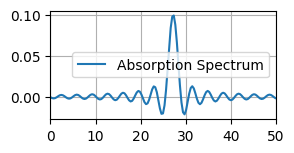

In [133]:
    if True:
    # Propagation loop
        for js in range(nsc):   
            if True:
                # compute survival amplitude rt=<psi0|psit>
                rr=0
                for i in range(nstates):
                    rr=rr+tt.dot(tt_psi0[i],tt_psi[i])*ddx
                rt[js]=rr

            if True:
                # norm/ total population
                ptot=tt.dot(tt_psi[0],tt_psi[0])*ddx
                population[js]=ptot
                time1=t[js]
                #print("time=",time1, "ptot=",ptot)
                #rt[js]=rt[js]
                # propagation of wavefunction
                tt_psi=tt_soft(tt_psi,UV,tt_Pxy)
                #print('r0=',tt_psi[0].r)
            # plot wavepacket components
            #if js%1==0:
                if wfflag == 10: #check param to plot
                    ttpsi1=tt_psi[0].full()
                    ttpsi=np.reshape(ttpsi1,[nx[0]]*dim)
                    plt.figure(dpi=600)
                    ax= plt.subplot(3,2,2, projection='3d')
                    if  qmodes == 0:
                        ax.plot_surface(x, y, np.abs(ttpsi[:,:]), cmap=cm.coolwarm, antialiased=False)
                    if  qmodes == 1:
                        ax.plot_surface(x, y, np.abs(ttpsi2[:,:,nsl]), cmap=cm.coolwarm, antialiased=False)
                    ax.set_zlim3d(0,1)

                    plt.pause(.02)
                    if js < nsc-1:
                        plt.clf()
        if True:
            # compute spectrum as the FT of rt
            dw=2.0*np.pi/(tau*10*nsc)
            w=np.fft.fftshift(np.fft.fftfreq(10*nsc,1.0/(10*nsc*dw)))
            rw=np.fft.fftshift(np.fft.ifft(rt*np.exp(-tau*t*gam))) # gam controls broadening of peak
            if wfflag == 1:
                ax= plt.subplot(3,2,5)
            else:
                ax= plt.subplot(3,1,3)
            ax.plot(w*27.2,np.real(rw),label='Absorption Spectrum')
            plt.legend()
            ax.set_xlim(0,50)
            ax.grid()
            plt.pause(.15)

##### **7.1.4. Example 4:** Finite temperature wavepacket dynamics with TFD (Thermo Field Dynamics) method

In this section, we introduce the TFD-TT method, which simulates high-dimensional wavepacket dynamics with finite temperature. The code below describes the population dynamics of a 2-level spin-boson model, with the levels (electronic states) coupled to each other through a coupling constant. Each level has 100 vibrational modes, modeled as linearly displaced quantum harmonic oscillators.     

First we import the packages:

In [134]:
pip install ttpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
import numpy as np
import tt
import tt.ksl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import process_time

The model can be described by the following Hamiltonian:

$H=\epsilon\sigma_z-V\sigma_x+\sum_k^N\omega_k a_k^\dagger a_k+\sigma_z\sum_k^Ng_k(a_k^\dagger+a_k)$,

where $2\epsilon$ is the energy difference between two electronic sites, $V$ is the electronic site coupling, $\omega_k$ is the frequency of the $k^{th}$ bath mode, $N=100$ is the number of total bath modes, $a_k^\dagger$ and $a_k$ are the creation and annihilation operators respectively, and $g_k$ is responsible for the linear coupling between the electronic sites and the bath modes. 

The linear coupling constant $g_k$ is related to the spectral density function, which, when taken the Ohmic form, results in:

$g_k=-\sqrt{\pi\alpha\omega_i\Omega/2}$,

where $\alpha=\lambda/(2\omega_c\pi)$, $\Omega=(1-e^{-\omega_{max}/\omega_c})\omega_c/N$, $\omega_{max}=5\omega_c$. 

The frequencies $\omega_k$ are discretized as:

$\omega_k=-\omega_c\text{log}(1-k\Omega/\omega_c)$.


The relevant parameters and arrays are given below:

In [136]:
qmodes=100            #number of quantum bath modes
nsc = 5000             # number of propagation steps
tau = 10              # propagation time step
eps = 1e-14            # tt approx error
rma = 2000000                # max tt rank
dim = qmodes         # number of coords
nstates=2              # number of surfaces
occ=10                 #maximum occupation number; low for harmonic systems
EYE=1j
kondo=0.1            #kondo parameter
cmn1toau=4.5563353e-6 # Conversion of wavenumbers to atomic units
au2ps=0.00002418884254# Conversion of attoseconds to atomic units
wc=250.*cmn1toau      #max freq for Ohmic bath discretization
J2au=2.2937104486906*10**17 #Conversion of Joules to atomic units
kB=1.308649*10**(-23) #Boltzmann's constant, in J/K
T=300                #Temperature, in K
kT=kB*T*J2au         #kBT, in atomic units
beta=1/kT            #beta
eelec=100.*cmn1toau #electronic state energy, in a.u.
coupling=100.*cmn1toau #electronic interstate coupling, in a.u.

In [137]:
freq=np.zeros((qmodes)) #frequency
ck=np.zeros((qmodes))   #linear electron-phonon coupling constant
gk=np.zeros((qmodes))   #ck in occupation number representation
for i in range(qmodes):                   
    freq[i]=-wc*np.log(1-(i+1)/(qmodes+1)) # Ohmic frequency
    ck[i]=np.sqrt(kondo*wc/(qmodes+1))*freq[i] #Ohmic coupling constant
    gk[i]=-ck[i]/np.sqrt(2*freq[i]) #Transfer ck to occ. num. representation

The Thermo Field Dynamics method solves the thermal Schrodinger equation:

$\frac{\partial|\Psi(t,\beta)\rangle}{\partial t}=-i\bar{H}|\Psi(t,\beta)\rangle$,

where the initial temperature dependent wavepacket $\Psi(0,\beta)$ correspond to the thermally averaged density matrix:
$|\Psi(0,\beta)\rangle\langle\Psi(0,\beta)|=Z^{-1}e^{-\beta H}$.

It has been shown that such a $|\Psi(0,\beta)\rangle$ is only possible in the double space, that is, the composite Hilbert space $\cal{H}_s\otimes\tilde{\cal{H}}_s$, where $\cal{H}_s$ is the physical Hilbert space, and $\tilde{\cal{H}}_s$ is a duplicate of $\cal{H}_s$ in the sense that if $\cal{H}_s$ is spanned by energy eigenvectors $\{|n\rangle\}$ where $H|n\rangle=E_n|n\rangle$, then $\tilde{\cal{H}}_s$ is spanned by $\{|\tilde{n}\rangle\}$ with the same set of energy eigenvalues for a duplicate Hamiltonian $\tilde{H}$: $\tilde{H}|n\rangle=E_n|\tilde{n}\rangle$.

Moreover, it has been shown that $|\Psi(0,\beta)\rangle$ could be obtained by a unitary rotation of the double space ground state $|0,\tilde{0}\rangle$:

$|\Psi(0,\beta)\rangle=e^{-iG}|0,\tilde{0}⟩$,

where for a harmonic system like the spin-boson model, $G=-i\sum_k^N\theta_k(a_k\tilde{a}_k-a_k^\dagger\tilde{a}_k^\dagger)$, $\theta_k=\text{arctanh}(e^{-\beta\omega_k/2})$. 

The thermal Schrodinger equation is therefore transformed by $G$ to become an equation of motion which initial condition is the easily prepared $|0,\tilde{0}\rangle$:

$\frac{\partial|\Psi_\theta(t,\beta)\rangle}{\partial t}=-i\bar{H}_\theta|\Psi_\theta(t,\beta)\rangle$,
where $\bar{H}_\theta=e^{iG}\bar{H}e^{-iG}$, $|\Psi_\theta(0,\beta)\rangle=|0,\tilde{0}\rangle$. 

We first show how this initial state $|\Psi_\theta(t,\beta)\rangle$ is constructed. In the code below, the arrays su and sd are for the electronic degree of freedom. For this particular setup, we initiate the wavepacket on the first electronic state, so su is used for tt_psi0, which is $|0,\tilde{0}\rangle$. Note that in this program, the Born-Oppenheimer seperation is always assumed, so the electronic degree of freedom does not use the double space formation. As for the vibrational bath modes, 2*qmodes vibrational degrees of freedom are appended using tt.kron, each in its ground state, represented by gs. 

In [138]:
#Build initial ground state
su=np.array([1,0]) 
sd=np.array([0,1])
tt_su=tt.tensor(su)
tt_sd=tt.tensor(sd)
tt_Ie=tt.eye(2,1)
gs=np.zeros((occ))
gs[0]=1.
tt_gs=tt.tensor(gs)
tt_psi0=tt_su
for k in range(2*qmodes):#double space formation
    tt_psi0=tt.kron(tt_psi0,tt_gs)

Next, we show how $\bar{H}_\theta$ is constructed. First, with the spin-boson Hamiltonian $H$, unitary transformation $G$, and thermal rotation angle $\theta_k$ defined previously, we have:

$\bar{H}_\theta=\epsilon\sigma_z-V\sigma_x+\sum_k^N\omega_k (a_k^\dagger a_k-\tilde{a}_k^\dagger \tilde{a}_k)+\sigma_z\sum_k^Ng_k\text{cosh}(\theta_k)(a_k^\dagger+a_k)+g_k\text{sinh}(\theta_k)(\tilde{a}_k^\dagger+\tilde{a}_k)$.

Below we explain how each term is constructed. 

First, the electronic Hamiltonian $\epsilon\sigma_z-V\sigma_x$ is set as a 2-by-2 matrix, appended with identity matrices for bath degrees of freedom (both physical and tilde) to ensure consistency of overall dimensionality:

In [139]:
#constructing Pauli operators
px=np.array([[0,1],[1,0]])
pz=np.array([[1,0],[0,-1]])
#Build electronic site energy matrix
He=eelec*pz-coupling*px
#TT-ize that energy matrix
tt_He=tt.matrix(He)
tt_He=tt.kron(tt_He,tt.eye(occ,qmodes*2))

Then, the physical harmonic Hamiltonian $\sum_k^N\omega_k a_k^\dagger a_k$ is constructed as a sum over N direct product states, each state with its $k^{th}$ core corresponding to the $k^{th}$ number operator ($a_k^\dagger a_k$), and all other cores are identity matrices. After obtaining this sum of product physical harmonic operator, a 2-by-2 identity matrix (corresponding to the 2-state electronic site) is appended before, and N identity matrices (corresponding to the N fictitious bath modes) are appended in the back, to ensure the overall dimensionality is correct:

In [140]:
#Build number operator, corresponds to harmonic oscillator Hamiltonian
numoc=np.diag(np.arange(0,occ,1))
#Initiate the TT-ized number operator as a zero TT array with shape of occ^N
tt_numoc=tt.eye(occ,qmodes)*0.
#Construct number operator as TT
for k in range(qmodes):
    if k==0:
        tmp=tt.kron(tt.matrix(numoc)*freq[k],tt.eye(occ,qmodes-1))
    elif 0<k<qmodes-1:
        tmp=tt.kron(tt.eye(occ,k-1),tt.matrix(numoc)*freq[k])
        tmp=tt.kron(tmp,tt.eye(occ,qmodes-k))
    else:
        tmp=tt.kron(tt.eye(occ,k),tt.matrix(numoc)*freq[k])
    tt_numoc=tt_numoc+tmp
    tt_numoc=tt_numoc.round(eps)
#Ensure correct dimensionality 
tt_Ie=tt.eye(2,1)
tt_systemnumoc=tt.kron(tt_Ie,tt_numoc)
tt_systemnumoc=tt.kron(tt_systemnumoc,tt.eye(occ,qmodes))

Note that in the above code, rounding after each iteration is essential for controlling the tensor train rank. 

Since the ficticious system is merely a duplicate of the physical system, tt_numoc could be directly used for the construction of the ficticious harmonic hamiltonian $\sum_k^N\tilde{a}_k^\dagger \tilde{a}_k$. The only difference is in the last step, where both electronic and physical bath modes are appended in the front. 

In [141]:
#create a duplicate of number operator for the ficticious system
tt_tildenumoc=tt.kron(tt_Ie,tt.eye(occ,qmodes))
tt_tildenumoc=tt.kron(tt_tildenumoc,tt_numoc)

Next, we construct the displacement operator. First we would need to obtain the parameters related to the thermal rotation angle $\theta_k$, which are arrays of $\text{cosh}(\theta_k)$ and $\text{sinh}(\theta_k)$:

In [142]:
thetak=np.zeros((qmodes)) #temperature-dependent mixing parameter in TFD
sinhthetak=np.zeros((qmodes)) #sinh(theta)
coshthetak=np.zeros((qmodes)) #cosh(theta)
for i in range(qmodes):                   
    thetak[i]=np.arctanh(np.exp(-beta*freq[i]/2)) #theta, defined for harmonic models
    sinhthetak[i]=np.sinh(thetak[i]) #sinh(theta)
    coshthetak[i]=np.cosh(thetak[i]) #cosh(theta)

Then, we construct a single mode displacement operator:

In [143]:
#Build displacement operator, corresponds to x operator in real space
eneroc=np.zeros((occ,occ))
for i in range(occ-1):
    eneroc[i,i+1]=np.sqrt(i+1)
    eneroc[i+1,i]=eneroc[i,i+1]

With these, the physical displacement operator $\sigma_z\sum_k^Ng_k\text{cosh}(\theta_k)(a_k^\dagger+a_k)$ is constructed as sum of product with a process very similar to tt_numoc:

In [144]:
#initialize displacement operator
tt_energy=tt.eye(occ,qmodes)*0.
for k in range(qmodes):
    if k==0:
#coshtheta takes account for energy flow from real to ficticious system
#thus takes account for temperature effect
        tmp=tt.kron(tt.matrix(eneroc)*gk[k]*coshthetak[k],tt.eye(occ,qmodes-1))
    elif 0<k<qmodes-1:
        tmp=tt.kron(tt.eye(occ,k-1),tt.matrix(eneroc)*gk[k]*coshthetak[k])
        tmp=tt.kron(tmp,tt.eye(occ,qmodes-k))
    else:
        tmp=tt.kron(tt.eye(occ,k),tt.matrix(eneroc)*gk[k]*coshthetak[k])
    tt_energy=tt_energy+tmp
    tt_energy=tt_energy.round(eps)

The only difference is that the electronic site appended in the front would be $\sigma_z$ instead of identity matrix:

In [145]:
tt_systemenergy=tt.kron(tt.matrix(pz),tt_energy)
tt_systemenergy=tt.kron(tt_systemenergy,tt.eye(occ,qmodes))

Now, for the tilde displacement operator $\sigma_z\sum_k^Ng_k\text{sinh}(\theta_k)(\tilde{a}_k^\dagger+\tilde{a}_k)$, both electronic pauli z matrix and identity matrices corresponding to the real bath DoFs are appended in the front:

In [146]:
#initialize displacement operator
tt_tilenergy=tt.eye(occ,qmodes)*0.
for k in range(qmodes):
    if k==0:
        tmp=tt.kron(tt.matrix(eneroc)*gk[k]*sinhthetak[k],tt.eye(occ,qmodes-1))
    elif 0<k<qmodes-1:
        tmp=tt.kron(tt.eye(occ,k-1),tt.matrix(eneroc)*gk[k]*sinhthetak[k])
        tmp=tt.kron(tmp,tt.eye(occ,qmodes-k))
    else:
        tmp=tt.kron(tt.eye(occ,k),tt.matrix(eneroc)*gk[k]*sinhthetak[k])
    tt_tilenergy=tt_tilenergy+tmp
    tt_tilenergy=tt_tilenergy.round(eps)
tt_tildeenergy=tt.kron(tt.matrix(pz),tt.eye(occ,qmodes))
tt_tildeenergy=tt.kron(tt_tildeenergy,tt_tilenergy)

Now we obtain all components of $\bar{H}_\theta$, and we simply add them up and define $A=-i\bar{H}_\theta$, so the transformed thermal Schrodinger equation is written as $\frac{\partial|\Psi_\theta(t,\beta)\rangle}{\partial t}=A|\Psi_\theta(t,\beta)\rangle$, where $|\Psi_\theta(0,\beta)\rangle$ is constructed previously as tt_psi0. This is now a first-order equation of motion, with initial state and condition of motion explicitly given. Therefore, direct integration yields the updated state. 

In [147]:
#Note that ficticious Harmonic oscillators carry negative sign
H=tt_He+tt_systemnumoc-tt_tildenumoc+tt_systemenergy+tt_tildeenergy
H=H.round(eps)
#Construct propagation operator, d/dt psi(t0)=A psi(t0) 
A=-EYE*H

The time-evolving state is called y0, which is initiated at tt_psi0. For the integration, TT-KSL algorithm is used. Since KSL is by construction a fixed-rank algorithm, we add a small (norm=10^-10), high-rank noise to carry out the propagation with a higher rank for improved accuracy:

In [148]:
y0=tt_psi0#initial wavepacket
#Add noise, for higher rank KSL propagation
radd=np.array([1,9])#the rank of the first bath mode core is capped by occ
radd=np.append(radd,np.repeat(29,qmodes*2-3))
radd=np.append(radd,np.array([9,1]))#and the last core
tt_rand=tt.rand(occ,qmodes*2,radd)#random TT array with desired size and rank
tt_rand=tt_rand*tt_rand.norm()**(-1) #Renormalize noise
tt_rand=tt.kron(tt.ones(2,1),tt_rand)#Append electronic site
y0 = y0+tt_rand*1e-10 #Ensure noise is small

Prior to the propagation loop, we initialize several arrays for the desired output:

In [149]:
#Heaviside functions, for selecting electronic states from overall wavefunction
tt_heavu=tt.kron(tt_su,tt.ones(occ,dim*2))
tt_heavd=tt.kron(tt_sd,tt.ones(occ,dim*2))
#Propagation time step and range
t=np.arange(0,nsc*tau,tau)
t=t*au2ps
#Initalize population arrays
psu=np.zeros((nsc))
psd=np.zeros((nsc))
ptot=np.zeros((nsc))

Now, the propagation loop:

In [ ]:
#Propagation loop
for ii in range(nsc):
    y0=tt.ksl.ksl(A,y0,tau)
    print(t[ii])
    psu[ii]=np.abs(tt.dot(tt_heavu*y0,tt_heavu*y0))
    psd[ii]=np.abs(tt.dot(tt_heavd*y0,tt_heavd*y0))
    ptot[ii]=psu[ii]+psd[ii]

0.0
0.0002418884254
0.0004837768508
0.0007256652762000001
0.0009675537016
0.001209442127
0.0014513305524000001
0.0016932189778
0.0019351074032
0.0021769958286
0.002418884254
0.0026607726794
0.0029026611048000002
0.0031445495302
0.0033864379556
0.003628326381
0.0038702148064
0.0041121032318
0.0043539916572
0.0045958800826
0.004837768508
0.0050796569334
0.0053215453588
0.0055634337842
0.0058053222096000005
0.006047210635
0.0062890990604
0.0065309874858
0.0067728759112
0.0070147643366
0.007256652762
0.0074985411874
0.0077404296128
0.0079823180382
0.0082242064636
0.008466094889
0.0087079833144
0.0089498717398
0.0091917601652
0.0094336485906
0.009675537016
0.0099174254414
0.0101593138668
0.0104012022922
0.0106430907176
0.010884979143
0.0111268675684
0.0113687559938
0.011610644419200001
0.0118525328446
0.01209442127
0.0123363096954
0.0125781981208
0.0128200865462
0.0130619749716
0.013303863397
0.0135457518224
0.0137876402478
0.0140295286732
0.0142714170986
0.014513305524
0.0147551939494
0.01

After the propagation, the population dynamics is plotted:

In [ ]:
#Plot population difference    
plt.figure(dpi=600)
plt.xlim(0.,1.)    
plt.ylim(-1.,1.)             
plt.xlabel('time(ps)')
plt.ylabel('Populations')
plt.plot(t,psu-psd,label='T=300K,r=30,tau=10,occ=10')
plt.legend()                     

As another example, we consider the spin-boson mapping of the electron transfer process in OmcS. OmcS is a protein nanowire with repetitive subunits, and each subunit contains 6 heme groups with electrons transferred within. 

As an initial test, we here consider the electron transfer between two heme groups, namely, heme V and III, with redox potential -0.063V and -0.111V, and electronic coupling 0.00151eV. The electronic energy matrix is therefore $[[-0.063V, 0.00151eV],[0.00151eV, -0.111V]]$, which, when transferred to the atomic unit, is: 
$H_e=[[2.316e-3,5.549e-5],[5.549e-5,4.079e-3]]$. The propagation is under 0K. 

The total Hamiltonian is $$H=H_e+H_{vib},$$ with $$H_e=[[2.316e-3,5.549e-5],[5.549e-5,4.079e-3]],$$ $H_{vib}$ describes the bath vibrational modes, modeled as harmonic oscillators in the ground state and displaced harmonic oscillators in the excited state:

$H_{vib,e}=\sum_i^N p_i^2/2m_i+\frac{1}{2}\omega_i^2(\hat{x}_i-d_i)^2$, 

$H_{vib,g}=\sum_i^N p_i^2/2m_i+\frac{1}{2}\omega_i^2\hat{x}_i^2$, 

$H_{vib}=[[H_{vib,g},0],[0,H_{vib,e}]]$. 

where $d_i=c_i/\omega_i^2$ is the displacement from ground state equilibrium position. $d_i$ and $\omega_i$ are obtained from vibrational analysis.

$H_{vib,e}$ and $H_{vib,g}$, transferred to harmonic oscillator eigenstate representation, become:

$H_{vib,e}=\sum_i^N\omega_i a^\dagger a+g_i(a^\dagger +a)$,

$H_{vib,g}=\sum_i^N\omega_i a^\dagger a$,

where $a^\dagger$ and $a$ are creation and annihilation operators, and $g_i=c_i/\sqrt{2\omega_i}$. Therefore, the quantity that directly enters the dynamics code is $g_i$, and $g_i$ is obtained from $c_i$, which comes from $d_i$ and $\omega_i$, obtained by the vibrational analysis. 

The code below performs TT-KSL integration with this Hamiltonian, with the wavepacket initiated at the excited state. 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  5 20:52:55 2021

@author: ningyi
"""
import numpy as np
import tt
import tt.ksl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import process_time
t_start=process_time()
cmn1toau=4.5563353e-6 # Conversion of wavenumbers to atomic units
evtoau=0.0367493
lamraw=np.loadtxt('reorganization_energy.txt')
lamarray=[]
for i in range(np.shape(lamraw)[0]):
    if lamraw[:,1][i]>1e-6:
        lamarray.append(lamraw[i])
lamfilter=np.array(lamarray)
freq=lamfilter[:,0]*cmn1toau
lam=lamfilter[:,1]*cmn1toau
ck=np.sqrt(2*lam)*freq
qmodes=np.shape(lam)[0]            #number of quantum bath modes
nsc = 4200            # number of propagation steps
tau = 10              # propagation time step
eps = 1e-14            # tt approx error
rma = 2000000                # max tt rank
dim = qmodes         # number of coords
nstates=2              # number of surfaces
occ=10                 #maximum occupation number; low for harmonic systems
EYE=1j
#kondo=0.1            #kondo parameter
au2ps=0.00002418884254# Conversion of attoseconds to atomic units
#wc=53.*cmn1toau      #max freq for Ohmic bath discretization
#wmax=5*wc
#om=wc/qmodes*(1-np.exp(-wmax/wc))
J2au=2.2937104486906*10**17 #Conversion of Joules to atomic units
kB=1.308649*10**(-23) #Boltzmann's constant, in J/K
T=300                #Temperature, in K
kT=kB*T*J2au         #kBT, in atomic units
beta=1/kT            #beta
#lam=80.*cmn1toau
#alpha=lam/(2*wc*np.pi)
#initialize arrays for parameters
#freq=np.zeros((qmodes)) #frequency
#ck=np.zeros((qmodes))   #linear electron-phonon coupling constant
gk=np.zeros((qmodes))   #ck in occupation number representation
thetak=np.zeros((qmodes)) #temperature-dependent mixing parameter in TFD
sinhthetak=np.zeros((qmodes)) #sinh(theta)
coshthetak=np.zeros((qmodes)) #cosh(theta)
for i in range(qmodes):                   
#    freq[i]=-wc*np.log(1-(i+1)*om/(wc)) # Ohmic frequency
#    ck[i]=np.sqrt(kondo*wc/(qmodes+1))*freq[i] #Ohmic coupling constant
    gk[i]=-ck[i]/np.sqrt(2*freq[i]) #Transfer ck to occ. num. representation
    thetak[i]=np.arctanh(np.exp(-beta*freq[i]/2)) #theta, defined for harmonic models
    sinhthetak[i]=np.sinh(thetak[i]) #sinh(theta)
    coshthetak[i]=np.cosh(thetak[i]) #cosh(theta)
#eelec=50.*cmn1toau #electronic state energy, in a.u.
#coupling=100.*cmn1toau #electronic interstate coupling, in a.u.
#Build initial ground state
su=np.array([1,0]) 
sd=np.array([0,1])
tt_su=tt.tensor(su)
tt_sd=tt.tensor(sd)
tt_Ie=tt.eye(2,1)
gs=np.zeros((occ))
gs[0]=1.
tt_gs=tt.tensor(gs)
tt_psi0=tt_su
for k in range(qmodes):#double space formation
    tt_psi0=tt.kron(tt_psi0,tt_gs)
#constructing Pauli operators
px=np.array([[0,1],[1,0]])
pz=np.array([[1,0],[0,-1]])
pd=np.array([[0,0],[0,1]])
#Build electronic site energy matrix
He=np.array([[0.002315559,0.00151*evtoau],[0.00151*evtoau,0.004079794]])
#TT-ize that energy matrix
tt_He=tt.matrix(He)
tt_He=tt.kron(tt_He,tt.eye(occ,qmodes))
#Build number operator, corresponds to harmonic oscillator Hamiltonian, see notesc
numoc=np.diag(np.arange(0,occ,1))
tt_numoc=tt.eye(occ,qmodes)*0.
tt_numoc=tt.kron(tt_Ie,tt_numoc)*0.
#Build displacement operator, corresponds to x operator in real space
eneroc=np.zeros((occ,occ))
for i in range(occ-1):
    eneroc[i,i+1]=np.sqrt(i+1)
    eneroc[i+1,i]=eneroc[i,i+1]
for k in range(qmodes):
    if k==0:
        tmp=tt.kron(tt_Ie,tt.matrix(numoc)*freq[k])
        tmp=tt.kron(tmp,tt.eye(occ,qmodes-1))
    elif 0<k<qmodes-1:
        tmp=tt.kron(tt_Ie,tt.eye(occ,k-1))
        tmp=tt.kron(tmp,tt.matrix(numoc)*freq[k])
        tmp=tt.kron(tmp,tt.eye(occ,qmodes-k))
    else:
        tmp=tt.kron(tt_Ie,tt.eye(occ,k))
        tmp=tt.kron(tmp,tt.matrix(numoc)*freq[k])
    tt_numoc=tt_numoc+tmp
    tt_numoc=tt_numoc.round(eps)
tt_energy=tt.kron(tt_Ie,tt.eye(occ,qmodes))*0.
for k in range(qmodes):
    if k==0:
        tmp=tt.kron(tt.matrix(pd),tt.matrix(eneroc)*gk[k])
        tmp=tt.kron(tmp,tt.eye(occ,qmodes-1))
    elif 0<k<qmodes-1:
        tmp=tt.kron(tt.matrix(pd),tt.eye(occ,k-1))
        tmp=tt.kron(tmp,tt.matrix(eneroc)*gk[k])
        tmp=tt.kron(tmp,tt.eye(occ,qmodes-k))
    else:
        tmp=tt.kron(tt.matrix(pd),tt.eye(occ,k))
        tmp=tt.kron(tmp,tt.matrix(eneroc)*gk[k])
    tt_energy=tt_energy+tmp
    tt_energy=tt_energy.round(eps)
H=tt_He+tt_numoc+tt_energy
H=H.round(eps)
A=-EYE*H
y0=tt_psi0
tt_heavu=tt.kron(tt_su,tt.ones(occ,dim))
tt_heavd=tt.kron(tt_sd,tt.ones(occ,dim))
t=np.arange(0,nsc*tau,tau)
t=t*au2ps
#radd = np.array([1,9,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,9,1])
#radd=9
radd=np.array([1,9])
radd=np.append(radd,np.repeat(19,qmodes-3))
radd=np.append(radd,np.array([9,1]))
#if ( radd > 0 ):
tt_rand=tt.rand(occ,qmodes,radd)
#tt_rand=tt_rand*10**(-140)
#for i in range(radd-1):
#    tt_rand=tt_rand+tt.rand(occ,qmodes*2,1)
wxw=tt_rand.to_list(tt_rand)
for i in range(qmodes):
    wxw[i]=wxw[i]*0.005
tt_rand=tt_rand.from_list(wxw)
#tt_rand=tt_rand*tt_rand.norm()**(-1) #Renormalize noise
tt_rand=tt.kron(tt.ones(2,1),tt_rand)
y0 = y0+tt_rand*1e-10
psu=np.zeros((nsc))
psd=np.zeros((nsc))
ptot=np.zeros((nsc))
for ii in range(nsc):
    print(ii)
    y0=tt.ksl.ksl(A,y0,tau)
    psu[ii]=np.abs(tt.dot(tt_heavu*y0,tt_heavu*y0))
    psd[ii]=np.abs(tt.dot(tt_heavd*y0,tt_heavd*y0))
    ptot[ii]=psu[ii]+psd[ii]
    
    
    
    
    
    
plt.figure(dpi=600)
plt.xlim(0.,1.)    
plt.ylim(-1.,1.)             
plt.xlabel('time(ps)')
plt.ylabel('Populations')
plt.plot(t,psu-psd,label='T=0K,rank=40')
#plt.plot(t,psu30,label='T=30K')
#plt.plot(MLMCTDHGStime,MLMCTDHGSpop)
#plt.plot(MLMCTDHtranstime,MLMCTDHtranspop)
#plt.plot(t0,pcisS1,label='cisS1')
#plt.plot(t0,pcisS0,label='cisS0')
#plt.plot(t0,ptransS1,label='transS1')
#plt.plot(t0,ptransS0,label='transS0')
#plt.plot(t0,pcis,label='cis')
#plt.plot(t0,population,label='norm')   
plt.legend()                     

**8. Amplitude Amplification: IPA Algorithm**

##### **8.1. Example 1:** Global minimum of a sum of $D$ asymmetric double-wells

> Indented block





```
# This is formatted as code
```

Micheline B. Soley, Paul Bergold, and Victor S. Batista 

[J. Chem. Theory Comput. **17**: 3280-3291(2021)](http://ursula.chem.yale.edu/~batista/publications/IPA.pdf)

Given a loss function $V(x)$ and an initial distribution $\rho_0(x)$ for parameter $x$, update the distribution $n$ times, as follows:
\begin{equation}
\rho_{k+1}(x) = \frac{e^{-V(x)} \rho_k(x)}{\|e^{-V(x)} \rho_k(x) \|}
\end{equation}
with $k=0,1,2\cdots,n-1$ until the distribution has significant amplitude only at the global minimum of $V(x)$. Resolve the value of $x$ at the global minimum $x_m$ by computing the expectation value based on $\rho_n(x)$, as follows:
\begin{equation}
x_m = \int dx~x~\rho_n(x).
\end{equation}

 \begin{equation}
V(x) = \sum_{k=0}^{D-1} \sum_{j=1}^4 c_j x_k^j,
\end{equation}
with $c_1=0.429$, $c_2=1.126$, $c_3=0.143$ and $c_4=0.563$.

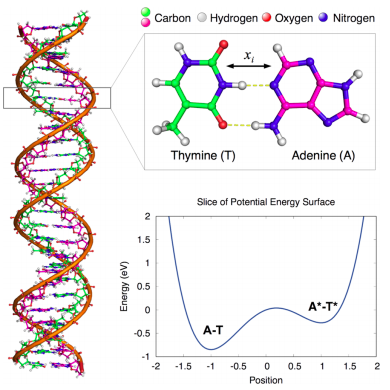

**Figure 1:** DNA chain (left) of D = 50 hydrogen bonds corresponding to 25 hydrogen-bonded adenine−thymine base pairs (inset, top right), with hydrogen bonds shown as dashed yellow lines. Each hydrogen bonded proton attaches to either base, with energy represented by the
double-well potential (bottom right).

In [ ]:
# Sum of quartic double wells
def V(x):
  nevals, D = x.shape
  out = np.zeros((nevals,))
  for i in range(nevals):
    for k in range(D):
      out[i] += 0.429*x[i,k]-1.126*x[i,k]**2-0.143*x[i,k]**3+0.563*x[i,k]**4
  return out 

In [ ]:
def rh(x): # uniform distribution
  nevals, dim = x.shape
  out = np.ones((nevals,))
  return(out)

In [ ]:
# Generate list of coordinates in d-domensional TT-format
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

In [ ]:
def ora(x): 
  return np.exp(-10*V(x))

In [ ]:
%matplotlib inline

In [ ]:
# Simulation
rma=3  # maximum rank
eps = 1e-14   # norm error
nsteps = 3 # number of IPA steps

# grid of 2**d points for each dimension
N=50; d=5
ns = 2**d; xmax=2
dx=2*xmax/ns
x=(np.linspace(0,1,ns)-0.5)*2*xmax

# qtt from x
xx=tt.tensor(np.reshape(x, [2]*d),eps)   
# identity with the same qtt format
ttone=tt.ones(2, d)       

# multidimensional space
tt_x = xx
tt_one=ttone
for i in range(N-1):
  tt_x = tt.kron(tt_x,xx)
  tt_one = tt.kron(tt_one,ttone)
# list of individual coordinates in multidimensional format
tx = [gen_1d(xx,ttone,i,N) for i in range(N)] 
# initial state
tt_rh=tt.multifuncrs2(tx, rh, eps,verb=0,rmax=rma)
# oracle
tt_ora=tt.multifuncrs2(tx, ora, eps,verb=0,rmax=rma)
# potential
#tt_V=tt.multifuncrs2(tx, V, eps,verb=0,rmax=rma)

# IPA 
tt_rho=tt_rh
for j in range(nsteps):
  tt_rh=tt_ora*tt_rh
  tt_rh=tt_rh.round(eps,rma)
  tt_rh=tt_rh*(1.0/tt_rh.norm())

# Expectation value
for j in range(N):
  print("xm[",j,"]=",tt.dot(tt_rh,tx[j])/tt.dot(tt_rh,tt_one))

# Plot inital and final distributions
if N == 1 :
  xn=np.reshape(tt_x.full(),[2**(d*N)])
  rhon=np.reshape(tt_rho.full(),[2**(d*N)])
  rhn=np.reshape(tt_rh.full(),[2**(d*N)])
  #Vn=np.reshape(tt_V.full(),[2**(d*N)])
  plt.plot(xn,rhon)
  # plt.plot(xn,Vn)
  plt.plot(xn,rhn)
  plt.ylim([-2,3])

if N == 2 :
  rx, ry = np.meshgrid(x, x)
  ax= plt.subplot(2,1,2, projection='3d')
  rhn=np.reshape(tt_rh.full(),[ns, ns])
 #  Vn=np.reshape(tt_V.full(),[ns,ns])
 #  ax.plot_surface(rx, ry, Vn, cmap=cm.coolwarm, antialiased=False)
  ax.plot_surface(rx, ry, rhn, cmap=cm.coolwarm, antialiased=False)
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  plt.show()

##### **8.2. Example 2: Clustering by Maximization of Modularity**

We introduce the concept of modularity as applied to the following graph:

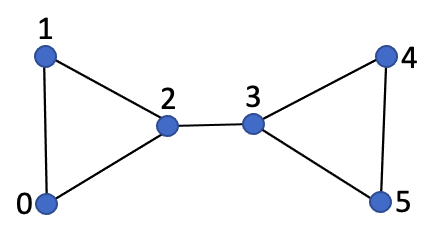

where nodes (blue circles) are linked by edges (lines), according to the following adjacency matrix: 

\begin{equation}
A = \left(\begin{array}{cc} 0 & 1 & 1 & 0 & 0 & 0 \\ 1 & 0 & 1 & 0 & 0 & 0 \\ 1 & 1 & 0 & 1 & 0 & 0  \\ 0 & 0 & 1 & 0 & 1 & 1 \\ 0 & 0 & 0 & 1 & 0 & 1 \\ 0 & 0 & 0 & 1 & 1 & 0   \end{array}\right)
\end{equation}

with entries $A_{jk}=1$, only when nodes $j$ and $k$ are linked.  

Labeling the nodes with $1$ or $-1$ we classify them into two communities. For example, $s^T=(1,-1,1,-1,1,1)$ defines a specific classification a state vector in the space of possible classifications. 

Given a state vector, we can estimate the quality of the classification by computing the **modularity** 
\begin{equation}
Q=\frac{1}{4 m} s^T \cdot B \cdot s
\end{equation}
defined as the expectation value of the modularity matrix
\begin{equation}
B_{i,j} = A_{i,j} - \frac{1}{2 m} k_i k_j
\end{equation}
with $k_i = \sum_{j=1}^N A_{i,j}$, and $2 m=\sum_{j=1}^N k_j$.

Q measures the degree to which the nodes can be clustered into separate communities where nodes are more among themselves than with nodes of other communities.

Here, we focus on the modularity generalized for partition of a network into c communities,  as follows:

$Q=\frac{1}{2m} \sum_{v w}\left[ A_{vw} - \frac{k_v k_w}{2m} \right] \delta(c_v,c_w)$

as discussed by [Moore](https://arxiv.org/abs/cond-mat/0408187) and summarized in [wikipedia](https://en.wikipedia.org/wiki/Modularity_(networks)).

Note that the fraction $P$ of edges linking nodes that belong to the same cluster can be computed, as follows:

$P=\frac{1}{2m} \sum_{v w} A_{vw} \delta(c_v,c_w)$

which is maximum for the trivial case where all the nodes belong to the same cluster, while $Q$ is that fraction relative to the randomized graph (i.e., a graph with the same number of edges and the same degree for each node although with the a random definition of edges) since
the probability of having an edge linking nodes $v$ and $w$ in a randomized graph is $\frac{k_v k_w}{2m}$.



##### **8.3. Modularity Calculation: Step by step definition of functions**

In [ ]:
import networkx as nx
A=[[0,1,1,0,0,0],[1,0,1,0,0,0],[1,1,0,1,0,0],[0,0,1,0,1,1],[0,0,0,1,0,1],[0,0,0,1,1,0]]
s=[1,1,1,-1,-1,-1] # Initial Assignment 

In [ ]:
G = nx.from_numpy_matrix(np.array(A))  
pos=nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color = s) 


In [ ]:
def QQ(A,s):
  # definition of modularity with delta(cj,ci)
  N=np.shape(A)[0]
  kk=np.sum(A,axis=0)
  out=0
  for i in range(N):
    for j in range(N):
      if(s[i] == s[j]):       
        out += A[i][j]-kk[i]*kk[j]/np.sum(kk)
  return out/np.sum(A)

In [ ]:
A=[[0,1,1,0,0,0],[1,0,1,0,0,0],[1,1,0,1,0,0],[0,0,1,0,1,1],[0,0,0,1,0,1],[0,0,0,1,1,0]]
s=[1,1,1,-1,-1,-1] # Initial Assignment 
print("QQ=", QQ(A,s))

Define a spin-1/2 tensor train corresponding to the entries of **s** 

In [ ]:
def s2tts(s):
  N=np.shape(s)[0]
  sup=tt.tensor(np.array([1,0]))
  sdow=tt.tensor(np.array([0,1]))
  tts=sup
  if s[0] == -1:
    tts=sdow
  for i in range(1,N):
    ss=sup
    if s[i] == -1:
      ss=sdow
    tts=tt.kron(tts,ss)
  return tts

Tensor train matrix of the modularity 
$H_B = \sum_{j=1}^N \sum_{k=1}^N B_{j,k} \hat{\sigma}_z(j) \hat{\sigma}_z(k)$ based on the modularity matrix $B_{j,k}$.

In [ ]:
def HB(A):
  MNC=2 # maximum number of clusters
  N=np.shape(A)[0]
  kk=np.sum(A,axis=0)
  # B matrix
  B = np.zeros((N,N))
  for i in range(N):
     for j in range(N):
       B[i][j] = A[i][j]-kk[i]*kk[j]/np.sum(kk)
  tt_H=tt.ones(MNC,N)*0
  for k in range(N):
    tt_H=tt_H+B[k][k]*tt.ones(MNC,N)
    for j in range(k+1,N):
      for i in range(MNC):
        z=np.zeros(MNC)
        z[i]=1
        tt_z=tt.tensor(z)
        zkj=tt_z
        if k > 0:
          zkj=tt.kron(tt.ones(MNC,k),zkj)        
        if (j-k) > 1:
          zkj=tt.kron(zkj,tt.ones(MNC,j-k-1))
        zkj=tt.kron(zkj,tt_z)
        if j < (N-1):
          zkj=tt.kron(zkj,tt.ones(MNC,N-1-j))
        tt_H=tt_H+(B[j][k]+B[k][j])*zkj
    tt_H=tt_H.round(1e-14)
  return tt_H

In [ ]:
def Q(tQ,ts):
  # modularity computed with
  return tt.dot(ts,tt.matvec(tQ,ts))

In [ ]:
A=[[0,1,1,0,0,0],[1,0,1,0,0,0],[1,1,0,1,0,0],[0,0,1,0,1,1],[0,0,0,1,0,1],[0,0,0,1,1,0]]
#A=np.array([[0,1,1,0,0,0],[1,0,0,0,0,0],[1,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
s=np.array([1,1,1,-1,-1,-1]) # Initial Assignment 
MNC=2 # max number of clusters
tts=s2tts(s)
ttQ=HB(A)*(1.0/np.sum(A))
ttQ=tt.diag(ttQ)

In [ ]:
print("Q=",Q(ttQ,tts))

In [ ]:
# Taylor's expansion of exp(A): scaling and squaring algorithm
# A TT-matrix
def expA(NM,A,eps,dim):
  rmax=5 # maximum rank
  N=10 # number of terms in Taylor's expansion
  w0=A*(1.0/2**N)
  e=tt.eye(NM,dim)
  e=tt.matrix(e)
  tm=e
  k=N-1
  while k > 0:
      tm=e+tm*w0*(1.0/k)
      tm=tm.round(eps,rmax)
      k=k-1
  while k < N:
      tm=tm*tm
      tm=tm.round(eps,rmax)
      k=k+1
  return tm

Exponential of ttQ*20 to maximize the modularity

In [ ]:
ettQ=expA(2,ttQ*20,eps=1e-14,dim=ttQ.d)

Define a uniform initial density

In [ ]:
def rho(tt):
  nevals, dim = tt.shape
  out = np.ones((nevals,))
  return(out)

Indices for coord entries

In [ ]:
def rind(r):
  nevals, dim = r.shape
  out = np.zeros((nevals,))
  NM=2 # max number of clusters
  for ii in range(nevals):
    for k in range(dim):
      out[ii] = out[ii]+r[ii,k]*NM**k
  return out

Ramp function for resolving degeneracies

In [ ]:
def ramp(r):
  return np.exp(-rind(r)*.1)

Define the grid space for node states

In [ ]:
N=2 # max number of clusters
#Lx= np.array([-1,1])
#Lx= np.array([0,1])
Lx=np.linspace(0, N-1, num=N) #  N: max number of clusters
TTgrid=tt.vector(Lx)
dim=np.shape(A)[0]

def genlist(e, i,dim,xone):
    # generator of tt list of coordinates
    if i > 0:
        w = xone
        for j in range(dim-1-i):
            w = tt.kron(w,e)
        for j in range(i):
            w = tt.kron(e,w)
    else:
        w = xone
        for j in range(dim-1):
            w=tt.kron(w,e)
    return w

rones=tt.ones(N,1)
tt_x = [genlist(rones,i,dim,TTgrid) for i in range(dim)]
tt_rho=tt.multifuncrs(tt_x,rho)
tt_rho=tt_rho*(1.0/tt_rho.norm())

In [ ]:
tt_rho.norm()

IPA: Amplify the amplitude of states with maximum Q

In [ ]:
tt_rho=tt.matvec(ettQ,tt_rho)
tt_rho=tt_rho*(1.0/tt_rho.norm())

Expectation value of Q

In [ ]:
tt.dot(tt_rho,tt.matvec(ttQ,tt_rho))

Note that the whole amplitude is localized at the global optima [111000] and [000111]

In [ ]:
tt_rho[1,1,1,0,0,0]**2+tt_rho[0,0,0,1,1,1]**2

In [ ]:
tt_rho.norm()

For visualization, generate ramp function and state indices

In [ ]:
tt_ramp=tt.multifuncrs2(tt_x, ramp, eps=1e-14,verb=0,rmax=5)

In [ ]:
tt_rind=tt.multifuncrs2(tt_x, rind, eps=1e-14,verb=0,rmax=5)

Note that the indices range from 0-63. The last element with all nodes in state 1 is

In [ ]:
tt_rind[1,1,1,1,1,1]

Visualize the state with amplitudes amplified at the global optima, and ramp function necessary to resolve the degeneracy

In [ ]:
plt.plot(np.reshape(tt_rind.full(),N**dim),np.reshape(tt_rho.full(),N**dim),'o')
plt.plot(np.reshape(tt_rind.full(),N**dim),np.reshape(tt_ramp.full(),N**dim),'*')

Amplify the solution with lower index while suppressing the other

In [ ]:
tt_rhon=tt_ramp*tt_rho
tt_rhon=tt_rhon*(1.0/tt_rhon.norm())

In [ ]:
plt.plot(np.reshape(tt_rind.full(),N**dim),np.reshape(tt_rhon.full(),N**dim),'o')

Note that the amplitude of the second solution is supressed

In [ ]:
tt_rhon[0,0,0,1,1,1]

while the amplitude of the first one is enhanced

In [ ]:
tt_rhon[1,1,1,0,0,0]

Compute the expectation value of x to obtain the global optimum state

In [ ]:
def point(f,x):
  ind=np.zeros(f.d)
  for j in range(f.d):
    ind[j]=tt.dot(f,f*x[j])*(1.0/f.norm())
  return ind

Assignment from expectation values

In [ ]:
point = np.zeros(dim)
for j in range(dim):
  expv=tt.dot(tt_rhon,tt_rhon*tt_x[j])
  point[j]=expv

In [ ]:
nx.draw(G, pos, with_labels=True, node_color = point) 

##### **8.4. Summary: Binary Clusters with Degenerate Solutions**

###### 8.4.1. Functions for clustering

In [ ]:
def denoise(f):
  tol=0.1
  nevals, dim = f.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
    if f[ii] > tol:
      out[ii] = f[ii]
  return out

In [ ]:
def point(f,x):
  ind=np.zeros(f.d)
  for j in range(f.d):
    ind[j]=tt.dot(f,f*x[j])*(1.0/f.norm())    
  return ind

In [ ]:
def ramp(r):
  return np.exp(-rind(r)*.1)

In [ ]:
def genlist(e, i,dim,xone):
    # generator of tt list of coordinates
    if i > 0:
        w = xone
        for j in range(dim-1-i):
            w = tt.kron(w,e)
        for j in range(i):
            w = tt.kron(e,w)
    else:
        w = xone
        for j in range(dim-1):
            w=tt.kron(w,e)
    return w

In [ ]:
# Taylor's expansion of exp(A): scaling and squaring algorithm
def expA(NM,A,eps,dim):
  rmax=5 # maximum rank
  N=10 # number of terms in Taylor's expansion
  w0=A*(1.0/2**N)
  e=tt.eye(NM,dim)
  e=tt.matrix(e)
  tm=e
  k=N-1
  while k > 0:
      tm=e+tm*w0*(1.0/k)
      tm=tm.round(eps,rmax)
      k=k-1
  while k < N:
      tm=tm*tm
      tm=tm.round(eps,rmax)
      k=k+1
  return tm

In [ ]:
def rind(r):
  nevals, dim = r.shape
  out = np.zeros((nevals,))
  NM=3   # max number of clusters
  for ii in range(nevals):
    for k in range(dim):
      out[ii] = out[ii]+r[ii,k]*NM**k
  return out

In [ ]:
def rho(tt):
  nevals, dim = tt.shape
  out = np.ones((nevals,))
  return(out)

In [ ]:
def initialize(A,N):
  Lx=np.linspace(0, N-1, num=N) #  N: max number of clusters
  TTgrid=tt.vector(Lx)
  dim=np.shape(A)[0]
  rones=tt.ones(N,1)
  x = [genlist(rones,i,dim,TTgrid) for i in range(dim)]
  f=tt.multifuncrs(x,rho,verb=0)
  return x, f

In [ ]:
def HB(A,MNC):
#  MNC=2 # maximum number of clusters
  N=np.shape(A)[0]
  kk=np.sum(A,axis=0)
  # B matrix
  B = np.zeros((N,N))
  for i in range(N):
     for j in range(N):
       B[i][j] = A[i][j]-kk[i]*kk[j]/np.sum(kk)
  tt_H=tt.ones(MNC,N)*0
  for k in range(N):
    tt_H=tt_H+B[k][k]*tt.ones(MNC,N)
    for j in range(k+1,N):
      for i in range(MNC):
        z=np.zeros(MNC)
        z[i]=1
        tt_z=tt.tensor(z)
        zkj=tt_z
        if k > 0:
          zkj=tt.kron(tt.ones(MNC,k),zkj)        
        if (j-k) > 1:
          zkj=tt.kron(zkj,tt.ones(MNC,j-k-1))
        zkj=tt.kron(zkj,tt_z)
        if j < (N-1):
          zkj=tt.kron(zkj,tt.ones(MNC,N-1-j))
        tt_H=tt_H+(B[j][k]+B[k][j])*zkj
    tt_H=tt_H.round(1e-14)
  return tt_H

In [ ]:
def ipa_sol(A,NM):
  x,f=initialize(A,NM)
  tt_ramp=tt.multifuncrs2(x, ramp, rmax=3, verb=0)
  ttQ=HB(A,NM)*(1.0/np.sum(A))
  ttQ=tt.diag(ttQ)
  QQ=expA(NM,ttQ*20,eps=1e-14,dim=ttQ.d)
  f=tt.matvec(QQ,f) # IPA
  f=f*(1.0/f.norm())  # degenerate solution
  sol=[]
  while (f.norm() > 0.2):
   g=tt_ramp*f
   g=g*(1.0/g.norm())
   sol.append(point(g,x))
   f=f-g*tt.dot(g,f) 
   f=tt.multifuncrs2([f],denoise,verb=0)
  return sol

###### 8.4.2. Example

In [ ]:
A=np.array([[0,1,1,0,0,0],[1,0,1,0,0,0],[1,1,0,1,0,0],[0,0,1,0,1,1],[0,0,0,1,0,1],[0,0,0,1,1,0]])
G = nx.from_numpy_matrix(A)
pos=nx.spring_layout(G)
NM=3 # maximum number of clusters
sol=ipa_sol(A,NM)

print("Number of degenerate solutions:", np.shape(sol)[0])
for j in range(np.shape(sol)[0]):
  print(1, sol[j][:].tolist())  
nx.draw(G, pos, with_labels=True, node_color = sol[0].tolist()) 

In [ ]:
nx.draw(G, pos, with_labels=True, node_color = sol[1].tolist()) 

##### **8.5. [Ningyi] Example 3:** Zachary's Karate network

[Ningyi]The following example uses the IPA algorithm to find the optimized social network of the famous Zachary's Karate club by maximizing modularity. The definition of modularity is the same as in the previous case, where N=34. The adjacency matrix is given below: http://konect.cc/networks/ucidata-zachary/, and
dataset can be downloaded from: http://konect.cc/files/download.tsv.ucidata-zachary.tar.bz2

In [ ]:
#import numpy as np
#import tt
#import tt.ksl
#Parameters for the adjacency matrix
dim=34
Adjmat=np.zeros((dim,dim))
Adjlist=([[ 1,  2],
       [ 1,  3],
       [ 2,  3],
       [ 1,  4],
       [ 2,  4],
       [ 3,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 5,  7],
       [ 6,  7],
       [ 1,  8],
       [ 2,  8],
       [ 3,  8],
       [ 4,  8],
       [ 1,  9],
       [ 3,  9],
       [ 3, 10],
       [ 1, 11],
       [ 5, 11],
       [ 6, 11],
       [ 1, 12],
       [ 1, 13],
       [ 4, 13],
       [ 1, 14],
       [ 2, 14],
       [ 3, 14],
       [ 4, 14],
       [ 6, 17],
       [ 7, 17],
       [ 1, 18],
       [ 2, 18],
       [ 1, 20],
       [ 2, 20],
       [ 1, 22],
       [ 2, 22],
       [24, 26],
       [25, 26],
       [ 3, 28],
       [24, 28],
       [25, 28],
       [ 3, 29],
       [24, 30],
       [27, 30],
       [ 2, 31],
       [ 9, 31],
       [ 1, 32],
       [25, 32],
       [26, 32],
       [29, 32],
       [ 3, 33],
       [ 9, 33],
       [15, 33],
       [16, 33],
       [19, 33],
       [21, 33],
       [23, 33],
       [24, 33],
       [30, 33],
       [31, 33],
       [32, 33],
       [ 9, 34],
       [10, 34],
       [14, 34],
       [15, 34],
       [16, 34],
       [19, 34],
       [20, 34],
       [21, 34],
       [23, 34],
       [24, 34],
       [27, 34],
       [28, 34],
       [29, 34],
       [30, 34],
       [31, 34],
       [32, 34],
       [33, 34]])
#Build adjacency matrix
for i in range(dim):
    for j in range(dim):
        for k in range(78):
            if [i+1,j+1]==Adjlist[k]:
                Adjmat[i,j]=1
            elif [j+1,i+1]==Adjlist[k]:
                Adjmat[i,j]=1

The degree of a vertex, $k_i$, is defined as the summation over the $i^{th}$ row of the adjacency matrix:

In [ ]:
#Build list of degrees of vertices
k=[]
for j in range(dim):
    out=np.sum(Adjmat[j])                
    k.append(out)

A N-dimensional tensor train grid with each dimension being a 2D array: [-1,1], is constructed as follows: 

In [ ]:
#Build TT grid with [-1,1] on every dimension
Lx=np.array([-1.,1.])
TTgrid=tt.vector(Lx)

def genlist(e, i,dim,xone):
    # generator of tt list of coordinates
    if i > 0:
        w = xone
        for j in range(dim-1-i):
            w = tt.kron(w,e)
        for j in range(i):
            w = tt.kron(e,w)
    else:
        w = xone
        for j in range(dim-1):
            w=tt.kron(w,e)
    return w

rones=tt.ones(2,1)
#for i in range(dim):
#    if i==0:
#        tmp=TTgrid
#    else:
#        tmp=tt.kron(tmp,TTgrid)
tt_x = [genlist(rones,i,dim,TTgrid) for i in range(dim)]

On this TT-grid, the modularity that corresponds to each grid point is defined and cross-approximated. Note that the overall sign of tt_mod is flipped, enables the use of IPA, a global minimization method, to treat the modularity maximization problem. 

In [ ]:
#mass
m=0.5*np.sum(k)       
#negative modularity
def mod(r):
    out=0
    for i in range(dim):
        for j in range(dim):
            out+=(k[i]*k[j]/2/m-Adjmat[i,j])*r[:,i]*r[:,j]/4/m
    return out
#TT-Potential energy (flipped modularity) surface
tt_mod=tt.multifuncrs(tt_x,mod, rmax=5, kickrank=1)

In [ ]:
tt_mod.r

In [ ]:
from tt.optimize import tt_min
val, point = tt_min.min_tens( tt_mod, rmax=10, nswp=30)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.from_numpy_matrix(np.array(Adjmat))  
pos=nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color = point) 


IPA is carried out with the dynamical low-rank approximation method, TT-KSL. The final global minimum position is obtained by taking the expectation value $\langle x \rangle$ on every dimension.

In [ ]:
#Propagation parameters
nsc=20
tau=10
#IPA
H=-tt.diag(tt_mod)
#Initiate TT matrix
tt_psi0=tt.ones(2,dim)
tt_norm0=tt_psi0.norm()
tt_psi0=tt_psi0*tt_norm0**(-1)
y0=tt_psi0
#Increase rank
radd = 2 
if ( radd > 0 ):
    tt_rand=tt.rand(y0.n,y0.d,radd)
    tt_rand=tt_rand*tt_rand.norm()**(-1) #Hack, better by initialization
    y0 = y0+tt_rand*1e-10
#Initiate expectation value array
expectx=np.zeros((nsc,dim))
#Propagation loop
for ii in range(nsc):
    y0=tt.ksl.ksl(H,y0,tau)
    y0norm=y0.norm()
    y0=y0*y0norm**(-1)
    for i in range(dim):
        ttxpsi=tt_x[i]*y0
        expectx[ii,i]=tt.dot(y0,ttxpsi)

The final assignment is printed below, where 1 and -1 mark the two split clubs for each of the 34 members. The result is in perfect match with that collected by Zachary in fieldwork: see Table 3 of Zachary, W. W. J. Anthropol. Res. 1977, 33, 452-473.

In [ ]:
assignment=expectx[nsc-1]
for i in range(dim):
  if assignment[i]>0:
    assignment[i]=1
  else:
    assignment[i]=-1
print('Club after split as predicted by KSL/IPA:',assignment)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.from_numpy_matrix(np.array(Adjmat))  
nx.draw(G, pos, with_labels=True, node_color = assignment)

The Karate Club is an example of clustering into two groups. It is possible to generalize the definition of modularity to n groups and perform the same optimization procedure to solve n-group clustering problems. Equation 4 of the following PRE paper provides the definition of n-group modularity: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.70.066111
Using KSL/IPA algorithm and the modularity defined above, global minimum is found for a very simple 3-group clustering problem (10 members, 12 interactions; see section "Example of multiple community detection" of this wiki page: https://en.wikipedia.org/wiki/Modularity_(networks)). 


##### **Example 4:** Multiple clusters

To partitioning a network into c communities, we generalize the definition of modularity, as follows:

$Q=\frac{1}{2m} \sum_{v w}\left[ A_{vw} - \frac{k_v k_w}{2m} \right] \delta(c_v,c_w)$

As an example, we consider an undirected network with 10 nodes and 12 edges and the following [adjacency matrix](https://en.wikipedia.org/wiki/Modularity_(networks)).

In [ ]:
import numpy as np
dim=10
A=np.zeros((dim,dim))
Adjlist=([[ 1,  2],
       [ 1,  3],
       [ 1,  10],
       [ 2,  1],
       [ 2,  3],
       [ 3,  1],
       [ 3,  2],
       [ 4,  5],
       [ 4,  6],
       [ 4,  10],
       [ 5,  4],
       [ 5,  6],
       [ 6,  4],
       [ 6,  5],
       [ 7,  8],
       [ 7,  9],
       [ 7,  10],
       [ 8, 7],
       [ 8, 9],
       [ 9, 7],
       [ 9, 8],
       [ 10, 1],
       [ 10, 4],
       [ 10, 7]])
#Build adjacency matrix
for j in range(np.shape(Adjlist)[0]):
  A[Adjlist[j][0]-1,Adjlist[j][1]-1]=1

In [ ]:
def mQ(r):
    N=np.shape(A)[0]
    nevals, dim = r.shape
    out = np.zeros((nevals,))
    for ii in range(nevals):
      out[ii]=0
      for i in range(N):
        for j in range(N):
          if(r[ii,i] == r[ii,j]):
            out[ii] = out[ii] + A[i][j] - np.sum(A[i][:])*np.sum(A[:][j])/np.sum(A) 
    return -out/np.sum(A)

In [ ]:
N=6 # max number of clusters
Lx= np.linspace(0, N-1, N)
TTgrid=tt.vector(Lx)

def genlist(e, i,dim,xone):
    # generator of tt list of coordinates
    if i > 0:
        w = xone
        for j in range(dim-1-i):
            w = tt.kron(w,e)
        for j in range(i):
            w = tt.kron(e,w)
    else:
        w = xone
        for j in range(dim-1):
            w=tt.kron(w,e)
    return w

rones=tt.ones(N,1)
tt_x = [genlist(rones,i,dim,TTgrid) for i in range(dim)]

In [ ]:
tt_mod=tt.multifuncrs(tt_x,mQ, rmax=10)

In [ ]:
from tt.optimize import tt_min
val, point = tt_min.min_tens(tt_mod, rmax=10, nswp=30)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.from_numpy_matrix(np.array(A))  
nx.draw(G, with_labels=True, node_color = point) 


In [ ]:
#Mount your google drive as follows:
from google.colab import drive
drive.mount('/content/mydir')

In [ ]:
# Query name of current folder
import os
folder_name=os.getcwd()
print(folder_name)

In [ ]:
# Goto the Colab folder
os.chdir('/content/mydir/MyDrive/Victor/notebooks')
folder_name=os.getcwd()
print(folder_name)

In [ ]:
ls 

[Ningyi] The following example describes the 3-group clustering problem of Amazon best-seller books about politices. Interaction between members (elements of the adjacency matrix) is 1 when two books are frequently purchased by the same buyer. In this model, N=105, and there are 441 unsymmetric interactions (882 symmetric interactions). The following code defines the N-group modularity and performs KSL/IPA integration.  

In [ ]:
pip install ttpy

In [ ]:
import networkx as nx
import numpy as np
import tt
import tt.ksl
dim=105
initdat=nx.read_gml("polbooks.gml")
initam=nx.to_numpy_array(initdat)
adjmat=np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        adjmat[i,j]=initam[i,j]
#Adjmat=np.array([[0,1,1,0,0,0,0,0,0,1],[1,0,1,0,0,0,0,0,0,0],[1,1,0,0,0,0,0,0,0,0],[0,0,0,0,1,1,0,0,0,1],[0,0,0,1,0,1,0,0,0,0],[0,0,0,1,1,0,0,0,0,0],[0,0,0,0,0,0,0,1,1,1],[0,0,0,0,0,0,1,0,1,0],[0,0,0,0,0,0,1,1,0,0],[1,0,0,1,0,0,1,0,0,0]])
#Parameters
Lx=np.array([0.,1.,2.])
nsc=200
tau=50
numx=np.shape(Lx)[0]
#Build list of degrees of vertices 
k=[]
for j in range(dim):
    out=np.sum(adjmat[j])                
    k.append(out)
#Build TT grid with [-1,1] on every dimension
TTgrid=tt.vector(Lx)
def genlist(e, i,dim,xone):
    # generator of tt list of coordinates
    if i > 0:
        w = xone
        for j in range(dim-1-i):
            w = tt.kron(w,e)
        for j in range(i):
            w = tt.kron(e,w)
    else:
        w = xone
        for j in range(dim-1):
            w=tt.kron(w,e)
    return w
rones=tt.ones(Lx.shape[0],1)
for i in range(dim):
    if i==0:
        tmp=TTgrid
    else:
        tmp=tt.kron(tmp,TTgrid)
tt_x = [genlist(rones,i,dim,TTgrid) for i in range(dim)]
#mass
m=0.5*np.sum(k)       

In [ ]:

def HB(A):
    global numx
    N=np.shape(A)[0]
    # B matrix
    B = -A 
    for i in range(N):
      for j in range(N):
        B[i][j] += np.sum(A[i][:])*np.sum(A[:][j])/np.sum(A)
    # HB matrix tensor train
    vectorprep=[]
    for i in range(numx):
        vectorprep.append(np.zeros(numx))
        vectorprep[i][i]=1
        vectorprep[i]=tt.vector(vectorprep[i])

    tt_H=0*tt.ones(numx,N)
    for k in range(N):
        tt_H=tt_H+B[k][k]*tt.ones(numx,N) # Z*Z = I
        for j in range(k+1,N):
            for l in range(numx):
                zkj=vectorprep[l]
                if k > 0:
                    zkj=tt.kron(tt.ones(numx,k),zkj)        
                if (j-k) > 1:
                    zkj=tt.kron(zkj,tt.ones(numx,j-k-1))
                zkj=tt.kron(zkj,vectorprep[l])
                if j < (N-1):
                    zkj=tt.kron(zkj,tt.ones(numx,N-1-j))
                tt_H=tt_H+(B[j][k]+B[k][j])*zkj
                tt_H=tt_H.round(1e-6)
        print(k,tt_H.r)
    tt_H=tt_H*(1./(np.sum(A)))
    tt_H=tt.diag(tt_H)
    return tt_H

In [ ]:
#TT-Potential energy (flipped modularity) surface
tt_mod=HB(adjmat)

#IPA
H=-tt_mod
#Initiate TT matrix
tt_psi0=tt.ones(Lx.shape[0],dim)
tt_norm0=tt_psi0.norm()
tt_psi0=tt_psi0*tt_norm0**(-1)
y0=tt_psi0
#Increase rank
radd = 2 
if ( radd > 0 ):
    tt_rand=tt.rand(y0.n,y0.d,radd)
    tt_rand=tt_rand*tt_rand.norm()**(-1) #Hack, better by initialization
    y0 = y0+tt_rand*1e-10
#Initiate expectation value array
expectx=np.zeros((nsc,dim))
#Propagation loop
for ii in range(nsc):
    y0=tt.ksl.ksl(H,y0,tau)
    y0norm=y0.norm()
    y0=y0*y0norm**(-1)
    for i in range(dim):
        ttxpsi=tt_x[i]*y0
        expectx[ii,i]=tt.dot(y0,ttxpsi)

In [ ]:
assignment=[]
for i in range(dim):
    if np.abs(expectx[nsc-1][i]-0.)<0.5:
        assignment.append(0)
    elif np.abs(expectx[nsc-1][i]-1.)<0.5:
        assignment.append(1)
    elif np.abs(expectx[nsc-1][i]-2.)<0.5:
        assignment.append(2)
    else:
        print('error')

G = nx.from_numpy_matrix(np.array(adjmat,dtype=float))
pos=nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color = assignment) 



In [ ]:
def modularity(r,A):
    N=np.shape(r)[0]
    # B matrix
    B = A 
    out=0
    for i in range(N):
      for j in range(N):
        B[i][j] -= np.sum(A[i][:])*np.sum(A[:][j])/np.sum(A)
    for i in range(N):
        for j in range(N):
            if r[i]==r[j]:
                out=out+B[i][j]
    out=out/np.sum(A)/2
    return out

In [ ]:
dim=105
initdat=nx.read_gml("polbooks.gml")
initam=nx.to_numpy_array(initdat)
adjmat=np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        adjmat[i,j]=initam[i,j]
modularity(assignment,adjmat)

###### **Karate**

In [ ]:
def mQ(r):
    A=Adjmat
    N=np.shape(A)[0]
    nevals, dim = r.shape
    out = np.zeros((nevals,))
    for ii in range(nevals):
      out[ii]=0
      for i in range(N):
        for j in range(N):
          if(r[ii,i] == r[ii,j]):
            out[ii] = out[ii] + A[i][j] - np.sum(A[i][:])*np.sum(A[:][j])/np.sum(A) 
    return -out/np.sum(A)

In [ ]:
N=4 # max number of clusters
Lx= np.linspace(0, N-1, N)
TTgrid=tt.vector(Lx)
dim=np.shape(Adjmat[0])[0]

def genlist(e, i,dim,xone):
    # generator of tt list of coordinates
    if i > 0:
        w = xone
        for j in range(dim-1-i):
            w = tt.kron(w,e)
        for j in range(i):
            w = tt.kron(e,w)
    else:
        w = xone
        for j in range(dim-1):
            w=tt.kron(w,e)
    return w

#tt_xx=TTgrid
#for j in range(dim):
#  tt_xx = tt.kron(tt_xx,TTgrid)

rones=tt.ones(N,1)
tt_x = [genlist(rones,i,dim,TTgrid) for i in range(dim)]

In [ ]:
tt_mod=tt.multifuncrs(tt_x,mQ, rmax=10,kickrank=1,nswp=10)

In [ ]:
from tt.optimize import tt_min
val, point = tt_min.min_tens(tt_mod, rmax=10, nswp=30)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.from_numpy_matrix(np.array(Adjmat))  
nx.draw(G, pos, with_labels=True, node_color = point) 

##### **Example 5: Global Minimum of Functions of Modes** 

 

Given a primary sequence of $N$ residues, each of which has one of the 4 possible secondary structures ($\alpha$-helix, $\beta$-sheet, coil, turn). Define a loss function that penalizes for a sequence according to the number of nearest neighbors that have different secondary structures. Apply IPA to reveal the sequences with minumum loss corresponding to all residues with the same secondary strucure.

We start by building an N-dimensional quantics tensor train **x** = ($x_1$,$x_2$,...,$n_N$), where $N$ is the number of residues and $x_j$ defines the secondary structure in the range of $2^d$ (d=2) possible values $x_j(1)$, ... , $x_j(2^d)$.

In [ ]:
def xcoord(tt):
  nevals, dim = tt.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
    for k in range(dim):
      out[ii] = out[ii]+tt[ii,k]*4**k
  return out

In [ ]:
def gate(tt): 
  return np.exp(-loss(tt))

In [ ]:
def loss(tt):
  nevals, dim = tt.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
    for k in range(dim-1):
        for kp in range(k+1,dim):
          if(tt[ii,k] !=  tt[ii,kp]):
            out[ii] += 1 
  return out

In [ ]:
def rho(tt):
  nevals, dim = tt.shape
  out = np.ones((nevals,))
  return(out)

In [ ]:
N=6
d=2
ns = 2**d
x=np.linspace(0,ns-1,ns)   
xx=np.reshape(x, [2]*d)   
ttone=tt.ones(2, d)       

rma=5  
eps = 1e-14
xx = tt.tensor(xx,eps)
#ttx = xx
#for i in range(N-1):
#  ttx = tt.kron(ttx,xx)

Generate a list of tensor trains $tx_j = i_1 \otimes  \cdots i_{j-1} \otimes x_j \otimes i_{j+1} \otimes i_N$ for each dimension $j=1, \cdots N$

In [ ]:
# Generate list of coordinates in d-domensional TT-format
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

In [ ]:
tx = [gen_1d(xx,ttone,i,N) for i in range(N)] 

Generate a tensor train tind(**x**) = $\sum_{j=0}^{N-1} x_j 4^j$ 

In [ ]:
tind=tt.multifuncrs2(tx, xcoord, eps,verb=0,rmax=rma)

Generate a tensor train loss(**x**)=$\sum_{j=0}^{N-2} (x_j != x_{j+1})$

In [ ]:
ttloss=tt.multifuncrs2(tx, loss, eps,verb=0,rmax=rma)

Generate a tensor train of the gate(**x**)=$e^{-loss(x)}$

In [ ]:
ttgate=tt.multifuncrs2(tx, gate, eps,verb=0,rmax=rma)

Generate a tensor train density with constant uniform distribution $\rho(x)=1$

In [ ]:
ttrho=tt.multifuncrs2(tx, rho, eps,verb=0,rmax=rma)

Update density distribution, as follows: $\rho(x) \rightarrow gate(x) \rho(x)$ 

In [ ]:
ttrho1=ttgate*ttrho

In [ ]:
ttrho1=ttrho1.round(eps)
ttrho1=ttrho1*(1.0/ttrho1.norm())

In [ ]:
tt.dot(tx[2],ttrho1)

Visualize results

In [ ]:
xn=np.reshape(tind.full(),[2**(d*N)])
lossn=np.reshape(ttloss.full(),[2**(d*N)])
rhosn=np.reshape(ttrho.full(),[2**(d*N)])
rhosn1=np.reshape(ttrho1.full(),[2**(d*N)])
plt.plot(xn,lossn,label='loss')
plt.plot(xn,rhosn,label='rho0')
plt.plot(xn,rhosn1,label='rho')
plt.legend()

##### **Modularity Maximization of the HNH Domain** 

 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
wt_adjmat = np.loadtxt('drive/MyDrive/Brandon/HNH-Filtered-GCC/HNH-WT-GCC-filtered.txt')

In [ ]:
wt_adjmat.shape

In [ ]:
import networkx as nx
import numpy as np
import tt
import tt.ksl
dim=141
#Adjmat=np.array([[0,1,1,0,0,0,0,0,0,1],[1,0,1,0,0,0,0,0,0,0],[1,1,0,0,0,0,0,0,0,0],[0,0,0,0,1,1,0,0,0,1],[0,0,0,1,0,1,0,0,0,0],[0,0,0,1,1,0,0,0,0,0],[0,0,0,0,0,0,0,1,1,1],[0,0,0,0,0,0,1,0,1,0],[0,0,0,0,0,0,1,1,0,0],[1,0,0,1,0,0,1,0,0,0]])
#Parameters
adjmat = wt_adjmat
Lx=np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.])
nsc=200
tau=50
numx=np.shape(Lx)[0]
#Build list of degrees of vertices 
k=[]
for j in range(dim):
    out=np.sum(adjmat[j])                
    k.append(out)
#Build TT grid with [-1,1] on every dimension
TTgrid=tt.vector(Lx)
def genlist(e, i,dim,xone):
    # generator of tt list of coordinates
    if i > 0:
        w = xone
        for j in range(dim-1-i):
            w = tt.kron(w,e)
        for j in range(i):
            w = tt.kron(e,w)
    else:
        w = xone
        for j in range(dim-1):
            w=tt.kron(w,e)
    return w
rones=tt.ones(Lx.shape[0],1)
for i in range(dim):
    if i==0:
        tmp=TTgrid
    else:
        tmp=tt.kron(tmp,TTgrid)
tt_x = [genlist(rones,i,dim,TTgrid) for i in range(dim)]
#mass
m=0.5*np.sum(k)       

def HB(A):
    global numx
    N=np.shape(A)[0]
    # B matrix
    B = -A 
    for i in range(N):
      for j in range(N):
        B[i][j] += np.sum(A[i][:])*np.sum(A[:][j])/np.sum(A)
    # HB matrix tensor train
    vectorprep=[]
    for i in range(numx):
        vectorprep.append(np.zeros(numx))
        vectorprep[i][i]=1
        vectorprep[i]=tt.vector(vectorprep[i])

    tt_H=0*tt.ones(numx,N)
    for k in range(N):
        tt_H=tt_H+B[k][k]*tt.ones(numx,N) # Z*Z = I
        for j in range(k+1,N):
            for l in range(numx):
                zkj=vectorprep[l]
                if k > 0:
                    zkj=tt.kron(tt.ones(numx,k),zkj)        
                if (j-k) > 1:
                    zkj=tt.kron(zkj,tt.ones(numx,j-k-1))
                zkj=tt.kron(zkj,vectorprep[l])
                if j < (N-1):
                    zkj=tt.kron(zkj,tt.ones(numx,N-1-j))
                tt_H=tt_H+(B[j][k]+B[k][j])*zkj
                tt_H=tt_H.round(1e-6)
        print(k,tt_H.r)
    tt_H=tt_H*(1./(np.sum(A)))
    tt_H=tt.diag(tt_H)
    return tt_H

#TT-Potential energy (flipped modularity) surface
tt_mod=HB(adjmat)

#IPA
H=-tt_mod
#Initiate TT matrix
tt_psi0=tt.ones(Lx.shape[0],dim)
tt_norm0=tt_psi0.norm()
tt_psi0=tt_psi0*tt_norm0**(-1)
y0=tt_psi0
#Increase rank
radd = 2 
if ( radd > 0 ):
    tt_rand=tt.rand(y0.n,y0.d,radd)
    tt_rand=tt_rand*tt_rand.norm()**(-1) #Hack, better by initialization
    y0 = y0+tt_rand*1e-10
#Initiate expectation value array
expectx=np.zeros((nsc,dim))
#Propagation loop
for ii in range(nsc):
    y0=tt.ksl.ksl(H,y0,tau)
    y0norm=y0.norm()
    y0=y0*y0norm**(-1)
    for i in range(dim):
        ttxpsi=tt_x[i]*y0
        expectx[ii,i]=tt.dot(y0,ttxpsi)

assignment=[]
for i in range(dim):
    if np.abs(expectx[nsc-1][i]-0.)<0.5:
        assignment.append(0)
    elif np.abs(expectx[nsc-1][i]-1.)<0.5:
        assignment.append(1)
    elif np.abs(expectx[nsc-1][i]-2.)<0.5:
        assignment.append(2)
    else:
        print('error')

G = nx.from_numpy_matrix(np.array(adjmat,dtype=float))
pos=nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color = assignment) 



#### **9. Tensor Completion**

##### **Functions for tensor completion**

[Tensor completion](http://sma.epfl.ch/~anchpcommon/students/steinlechner_phd.pdf) aims to reconstruct a high-dimensional data set ${\bf A} \in R^{n_1 \times n_2 \times \cdots \times n_d}$ for which many of the entries are unknown, in terms of a low-rank TT approximation ${\bf x}$. The assumption of low-rank structure in the underlying original data allows us to cast the completion problem into the minimization of the functional $J({\bf x}) = \|\hat{P} {\bf x} - \hat{P} {\bf A} \|^2$, where $\hat{P}$ is the projection operator onto the sampling set $\Omega$ of indices of the known entries of ${\bf A}$ (i.e., the index subspace of known elements). So, $\hat{P}{\bf x} = x(i_1,i_2, \dots, i_d)$, if $(i_1,i_2, \dots, i_d) \in \Omega$. Otherwise, $\hat{P}{\bf x} = 0$. When $d=2$, tensor completion reduces to the extensively
studied [matrix completion problem](https://people.eecs.berkeley.edu/~yima/matrix-rank/home.html) for which convergence theory and efficient algorithms have been derived in the last years 


In [ ]:
try:
    xrange
except NameError:
    xrange = range
#import numpy as np
#import tt
import time
import copy

def reshape(x, shape):
    '''                                                                         
    Reshape given numpy.array into new shape with Fortran-ordering              
                                                                                
    Parameters:                                                                 
        :np.array: x                                                            
            given numpy array                                                   
        :list, tuple, np.array: shape                                           
            new shape                                                           
    '''
    return np.reshape(x, shape, order = 'F')

def getRow(leftU, rightV, jVec):
    '''                                                                         
    Compute X_{\geq \mu}^T \otimes X_{leq \mu}                                  
    X_{\geq \mu} = V_{\mu+1}(j_{\mu}) \ldots V_{d} (j_{d}) [left interface matrix]                                                                             
    X_{\leq \mu} = U_{1} (j_{1}) \ldots U_{\mu-1}(j_{\mu-1}) [right interface matrix]                                                                          
                                                                                
    Parameters:                                                                 
        :list of numpy.arrays: leftU                                            
            left-orthogonal cores from 1 to \mu-1                               
        :list of numpy.arrays: rightV                                           
            right-orthogonal cores from \mu+1 to d                              
        :list, tuple, np.array: jVec                                            
            indices for each dimension n[k]                                     
    Returns:                                                                    
        :numpy.array: result                                                    
            Kronecker product between left and right interface                  
            matrices. Left matrix is transposed.                                
    '''
    jLeft = None
    jRight = None
    if len(leftU) > 0:
        jLeft = jVec[:len(leftU)]
    if len(rightV) > 0:
        jRight = jVec[-len(rightV):]

    multU = np.ones([1,1])
    for k in xrange(len(leftU)):
        multU = np.dot(multU, leftU[k][:, jLeft[k], :])
    multV= np.ones([1,1])
    for k in xrange(len(rightV)-1, -1, -1):
        multV = np.dot(rightV[k][:, jRight[k], :], multV)

    result = np.kron(multV.T, multU)
    return result

def orthLRFull(coreList, mu, splitResult = True):
    '''                                                                         
    Orthogonalize list of TT-cores.                                             
                                                                                
    Parameters:                                                                 
        :list: coreList                                                         
            list of TT-cores (stored as numpy arrays)                           
        :int: mu                                                                
            separating index for left and right orthogonalization.              
            Output cores will be left-orthogonal for dimensions from 1 to \mu-1
            and right-orthogonal for dimensions from \mu+1 to d                 
        :boolean: splitResult = True                                            
            Controls whether outut should be splitted into left-, non-, right-orthogonal                                                                       
            parts or not.                                                       
                                                                                
    Returns:                                                                    
        :list: resultU                                                          
            left-orthogonal cores with indices from 1 to \mu-1                  
        :np.array: W                                                            
            \mu-th core                                                         
        :list: reultV                                                           
            right-orthogonal cores with indices from \mu+1 to d                 
    OR
        :list: resultU + [W] + resultV                                          
            concatenated list of cores                                          
    '''
    d = len(coreList)
    assert (mu >= 0) and (mu <= d)
    resultU = []
    for k in xrange(mu):
        core = coreList[k].copy()
        if k > 0:
            core = np.einsum('ijk,li->ljk', core, R)
        [r1, n, r2] = core.shape
        if (k < mu-1):
            core = reshape(core, [r1*n, r2])
            Q, R = np.linalg.qr(core)
            rnew = Q.shape[1]
            core = reshape(Q, [r1, n, rnew])
            resultU = resultU + [core]
    if mu > 0:
        W = core.copy()
    resultV = []
    for k in xrange(d-1, mu, -1):
        core = coreList[k].copy()
        if (k < d-1):
            core = np.einsum('ijk,lk->ijl', core, R)
        [r1, n, r2] = core.shape
        if (k > mu+1):
            core = reshape(core, [r1, n*r2])
            Q, R = np.linalg.qr(core.T)
            rnew = Q.shape[1]
            core = reshape(Q.T, [rnew, n, r2])
        resultV = [core] + resultV
    if mu < d-1:
        if mu > 0:
            W = np.einsum('ijk,lk->ijl', W, R)
        else:
            W = np.einsum('ijk,lk->ijl', coreList[0], R)
    if splitResult:
        return resultU, W, resultV
    return resultU + [W] + resultV

def computeFunctional(x, cooP):
    '''                                                                         
    Compute value of functional J(X) = ||PX - PA||^2_F,                         
    where P is projector into index subspace of known elements,                 
          X is our approximation,                                               
          A is original tensor.                                                 
                                                                                
    Parameters:                                                                 
        :tt.vector: x                                                           
            current approximation [X]                                           
        :dict: cooP                                                             
            dictionary with two records                                         
                - 'indices': numpy.array of P x d shape,                        
                contains index subspace of P known elements;                    
                each string is an index of one element.                         
                - 'values': numpy array of size P,                              
                contains P known values.                                        
                                                                                
    Returns:                                                                    
        :float: result                                                          
            value of functional                                                 
    '''
    indices = cooP['indices']
    values = cooP['values']

    [P, d] = indices.shape
    assert P == len(values)

    result = 0
    for p in xrange(P):
        index = tuple(indices[p, :])
        result += (x[index] - values[p])**2
    result *= 0.5
    return result


def ttSparseALS(cooP, shape, x0=None, ttRank=1, tol=1e-5, maxnsweeps=20, verbose=True, alpha=1e-2):
    '''                                                                         
    TT completion via Alternating Least Squares algorithm.                      
                                                                                
    Parameters:                                                                 
        :dict: cooP
            dictionary with two records                                         
                - 'indices': numpy.array of P x d shape,                        
                contains index subspace of P known elements;                    
                each string is an index of one element.                         
                - 'values': numpy array of size P,                              
                contains P known values.                                        
        :list, numpy.array: shape                                               
            full-format shape of tensor to be completed [dimensions]            
        :tt.vector: x0 = None                                                   
            initial approximation of completed tensor                           
            If it is specified, parameters 'shape' and 'ttRank' will be ignored
        :int, numpy.array: ttRank = 1                                           
            assumed rank of completed tensor                                    
        :float: tol = 1e-5                                                      
            tolerance for functional value                                      
        :int: maxnsweeps = 20                                                   
            maximal number of sweeps [sequential optimization of all d cores    
            in right or left direction]                                         
        :boolean: verbose = True                                                
            switcher of messages from function
        :float: alpha: = 1e-2                                                   
            regularizer of least squares problem for each slice of current TT c\
ore.                                                                            
            [rcond parameter for np.linalg.lstsq]                               
                                                                                
    Returns:                                                                    
        :tt.vector: xNew                                                        
            completed TT vector                                                 
        :list: fit                                                              
            list of functional values at each sweep                             
    '''
    indices = cooP['indices']
    values = cooP['values']

    [P, d] = indices.shape
    print(indices)
    assert P == len(values)

    timeVal = time.clock()
    if x0 is None:
        x = tt.rand(shape, r = ttRank)
        x = x.round(0.)
        x = (1./x.norm())*x
    else:
        x = copy.deepcopy(x0)
    assert d == x.d
    # TODO: also check if cooP indices are aligned with shape                   
    normP = np.linalg.norm(values)
    values /= normP
    fitList = []
    sweepTimeList = []
    initTime = time.clock() - timeVal

    timeVal = time.clock()
    coreList = tt.vector.to_list(x)
    #coreList = orthLRFull(coreList, mu = d, splitResult = False)               
    # orthTime = time.clock() - timeVal                                         

    if verbose:
        print("Initialization time: %.3f seconds (proc.time)" % (initTime))
        # print "Orthogonalizing time: %.3f seconds (proc.time)" % (orthTime)   

    for sweep in xrange(maxnsweeps):
        sweepStart = time.clock()
        # list left + right                                                     
        [kStart, kEnd, kStep] = [0, d, 1]
        # select direction of sweep                                             
        '''                                                                     
        if sweep % 2 == 0: # left to rigth                                      
            [kStart, kEnd, kStep] = [0, d, 1]                                   
        else: # right to left                                                   
            [kStart, kEnd, kStep] = [d-1, -1, -1]                               
        '''
        # fix k-th core to update                                               
        for k in xrange(kStart, kEnd, kStep):
            [r1, n, r2] = coreList[k].shape
            core = np.zeros([r1, n, r2])
            leftU = []
            rightV = []
            if k > 0:
                leftU = coreList[:k]
            if k < d-1:
                rightV = coreList[k+1:]
            for i in xrange(n):
                thetaI = np.where(indices[:, k] == i)[0]
                if len(thetaI) > 0:
                    A = np.zeros([len(thetaI), r1*r2])
                    for j in xrange(len(thetaI)):
                        tmp = getRow(leftU, rightV, indices[thetaI[j], :])
                        A[j:j+1, :] += tmp   # .flatten(order = 'F')            
                    vecCoreSlice, _, _, _ = np.linalg.lstsq(A, values[thetaI])#, rcond = alpha)                                                                
                    # 0.5*np.linalg.norm(np.dot(A, vecCoreSlice) - values[thetaI])**2.                                                                         
                    core[:, i, :] += reshape(vecCoreSlice, [r1, r2]) ####       
            '''                                                                 
            if k < (d-1):                                                       
                core = reshape(core, [r1*n, r2])                                
                Q, R = np.linalg.qr(core)                                       
                rnew = Q.shape[1]                                               
                core = reshape(Q, [r1, n, rnew])                                
                coreList[k+1] = np.einsum('ijk,li->ljk', coreList[k+1], R)      
            '''
            coreList[k] = core.copy()
            '''                                                                 
            else:                                                               
                if (k > 0):                                                     
                    core = reshape(core, [r1, n*r2])                            
                    Q, R = np.linalg.qr(core.T)                                 
                    rnew = Q.shape[1]                                           
                    core = reshape(Q.T, [rnew, n, r2])                          
                    coreList[k-1] = np.einsum('ijk,lk->ijl', coreList[k-1], R)  
            '''

        xNew = tt.vector.from_list(coreList)
        fit = computeFunctional(xNew, cooP)
        fitList.append(fit)
        if fit < tol:
            break
        if sweep > 0:
            if abs(fit - fitList[-2]) < tol:
                break
        sweepTimeList.append(time.clock() - sweepStart)
        if verbose:
            print("sweep %d/%d\t fit value: %.5e\t time: %.3f seconds (proc.time)" % (sweep+1, maxnsweeps, fit, sweepTimeList[-1]))
    if verbose:
        print("Total sweep time: %.3f seconds (proc.time)\t Total time: %.3f seconds (proc.time)" % (sum(sweepTimeList), sum(sweepTimeList) + initTime))# + orthTime)                                                                         
    info = {'fit': fitList, 'initTime': initTime,  'sweepTime': sweepTimeList} # 'orthTime': orthTime,                                                         
    xNew *= normP
    values *= normP

    return xNew, info

import tt, tt.cross
from tt.cross.rectcross import cross
# fascilitating reshape                                                         
def reshape(x, shape):
    return np.reshape(x, shape, order = 'F')
# import visualization tools                                                    
import matplotlib.pyplot as plt
from matplotlib import gridspec

##### **Example 1:** Tensor completion of a 3-d function

Here, we implement the tensor completion method based on ALS tpo build an approximation to the following d-dimensional tensor: 
\begin{equation}
f({\bf x})=\sqrt{\sum_{j=1}^d \frac{1}{(1+(x_j-\frac{n}{2})^2)}} 
\end{equation}
with $d=3$ from a given set of known entries values.

In [ ]:
def demo_completion():
    d = 3
    n=20
    crossR=18
    shape = np.array([n]*d)
    def func(X):
        return 1./(1+(X - n/2)**2).sum(axis = 1)**0.5

    # tt-approximation built via cross approximation                                            
    x0 = tt.rand(np.array([n]*d), r = crossR)
    tta = cross(func, x0)
    print("TT-cross ranks: ", tta.r)

    R = 10
    gamma = 0.25
    P = int(np.floor(gamma*d*n*(R**2))) # size of sampling set
    print ("# of sampled entries =", P, ",  total =", n**d )
    Pb = 100

    # random choice                                                                             
    indices = np.random.choice(n, [P, d])  # random indices for P entries
    print("indices=",indices)
    indicesB = np.random.choice(n, [Pb, d])
    # making list of tupled stings [indices]                                                    
    indices = [tuple(indices[k, :]) for k in xrange(indices.shape[0])]
    print("indices tupled=",indices)
    indicesB = [tuple(indicesB[k, :]) for k in xrange(indicesB.shape[0])]

    # set() naturally filters input to be unique, weeding out repeated points                                                  
    indices = set(indices)
    print("filtered indices=",indices)
    indicesB = set(indicesB)
    # convert it into list                                                                      
    indices = list(indices)
    print("list of filtered indices=",indices)
    indicesB = list(indicesB)
    # return into numpy.array form                                                              
    indices = np.array(indices)
    print("numpy array of list of filtered indices=",indices)
    indicesB = np.array(indicesB)

    print("Unique sample points: %d/%d (%d)" % (indices.shape[0], P, n**d))

    vals = func(indices)
    cooP = {'values': vals, 'indices': indices} # sampling set
    cooPb = {'values': func(indicesB), 'indices': indicesB}


    x0 = tt.rand(shape, r=1)
    x0 = x0 * (1./ x0.norm())
    x0 = x0.round(0.)
                                                                
    vb = True # verbose
    maxR = 5 # maximum rank of approximation
    X1, f = ttSparseALS(
                        cooP,
                        shape,
                        x0=None,
                        ttRank=maxR,
                        maxnsweeps=50,
                        verbose=vb,
                        tol=1e-8,
                        alpha = 1e-3
    )

    # Only for visualization purposes:
    # restore original, initial and approximation into full-format (do not try it in higher dimensions!)
    xf1 = X1.full() # approximation ALS                                                         
    a = tta.full() # original                                                                   
    b = np.zeros([n]*d) # initial                                                               
    for p in xrange(indices.shape[0]):
        b[tuple(indices[p,:])] += vals[p]

    # Visualize slices of original, completed and initial tensors. Colormap is standartized.    
    plt.clf()
    M = [a, xf1, b]
    titles = ['Original', 'Completed (ALS)', 'Initial']
    nRow = n
    nCol = 3
    fig = plt.figure(figsize=(5*nCol, nRow*5))
    gs = gridspec.GridSpec(nRow, nCol, wspace=0., hspace=1e-2, right=1-0.5/nCol)#top=1 - 0.5/nRow,                                                                                             
        #bottom=0.5/nRow, left=0.5/nCol, right=1 - 0.5/nCol)                                    

    for k in xrange(nRow):
        vmin = [x[k, :, :].min() for x in M]
        vmax = [x[k, :, :].max() for x in M]
        vmin = min( vmin)
        vmax = max( vmax)
        for l in xrange(nCol):
            ax = plt.subplot(gs[k, l])
            im = ax.imshow(M[l][k, :, :].T, vmin=vmin, vmax=vmax, interpolation='none')
            ax.set_axis_off()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            if k == 0:
                ax.set_title(titles[l], fontsize=20)
            if l == (nCol-1):
                box = ax.get_position()
                ax.set_position([box.x0*1.05, box.y0, box.width, box.height])
                axColor = plt.axes([box.x0*1.05 + box.width * 1.05, box.y0, 0.01, box.height])
                fig.colorbar(im, cax = axColor)


    #fig.subplots_adjust(right = 0.5)                                                           
    #cbar_ax = fig.add_axes([0.55, 0.45, 0.005, 0.11])                                          
    #fig.colorbar(im, cax=cbar_ax)
    #fig.subplots_adjust(wspace=0., hspace=0.)                                                  
    plt.savefig('demo_completion_gridplot.pdf', dpi=300)
    #fig.show()                                                                                 
    # plot functional curves                                                                    

    #plt.clf()
    fig = plt.figure()
    plt.semilogy(f['fit'], label='ALS')
    plt.xlabel('It.num.')
    plt.ylabel('ln( Fit )')
    plt.grid(True)
    plt.legend()
    plt.title('Funval ALS')
    plt.savefig('demo_completion_fitplot.pdf', dpi=300) 
    

In [ ]:
demo_completion()

##### **Example 2:** Complete a fake-RefDB based on 4 nearest neighbours (2 on each side)

Average chemical shifts of individual residues

In [ ]:
def fo(x):
  return(60+x/20+np.sin(x*2*np.pi*3/13)*np.cos(x*2*np.pi*1/20))

In [ ]:
n=20
x=np.linspace(0,n-1,n)
plt.plot(x,fo(x))

In [ ]:
def fake_refDB_completion():
    d = 5            # 2 nearest neighbours on each side
    n=20             # aa types
    crossR=18
    shape = np.array([n]*d)

    def fo(x):
      return(60*0+x/20+np.sin(x*2*np.pi*3/13)*np.cos(x*2*np.pi*1/20))

    def fake_refDB(x):
      nevals, dim = x.shape
      out = np.zeros((nevals,))
      for ii in range(nevals):
        out[ii] = fo(x[ii,1])+(fo(x[ii,0])+fo(x[ii,2]))*0.25+(fo(x[ii,0])+fo(x[ii,4]))*0.1
      return out
  
    x0=tt.tensor(np.linspace(0,n-1,n))
    ttx=x0
    for j in range(d-1):
      ttx=tt.kron(ttx,x0)
    x0=ttx
    #    x0 = tt.rand(np.array([n]*d), r = crossR)

    # tt-approximation built via cross approximation
    tta = cross(fake_refDB, x0)
    print("TT-cross ranks: ", tta.r)

    R = 10
    gamma = 0.25
    P = int(n**d*0.015) # size of sampling set
    print ("# of sampled entries =", P, ",  total =", n**d )
    Pb = 100

    # random choice                                                                             
    indices = np.random.choice(n, [P, d])  # random indices for P entries
    print("indices=",indices)
    indicesB = np.random.choice(n, [Pb, d])
    # making list of tupled stings [indices]                                                    
    indices = [tuple(indices[k, :]) for k in xrange(indices.shape[0])]
    print("indices tupled=",indices)
    indicesB = [tuple(indicesB[k, :]) for k in xrange(indicesB.shape[0])]

    # set() naturally filters input to be unique, weeding out repeated points                                                  
    indices = set(indices)
    print("filtered indices=",indices)
    indicesB = set(indicesB)
    # convert it into list                                                                      
    indices = list(indices)
    print("list of filtered indices=",indices)
    indicesB = list(indicesB)
    # return into numpy.array form                                                              
    indices = np.array(indices)
    print("numpy array of list of filtered indices=",indices)
    indicesB = np.array(indicesB)
    print(indices.shape)
    print("Unique sample points: %d/%d (%d)" % (indices.shape[0], P, n**d))

    vals = fake_refDB(indices)
    cooP = {'values': vals, 'indices': indices} # sampling set
    cooPb = {'values': fake_refDB(indicesB), 'indices': indicesB}


    x0 = tt.rand(shape, r=1)
    x0 = x0 * (1./ x0.norm())
    x0 = x0.round(0.)
                                                                
    vb = True # verbose
    maxR = 5 # maximum rank of approximation
    X1, f = ttSparseALS(
                        cooP,
                        shape,
                        x0=None,
                        ttRank=maxR,
                        maxnsweeps=30,
                        verbose=vb,
                        tol=1e-8,
                        alpha = 1e-3
    )

    # Only for visualization purposes:
    # restore original, initial and approximation into full-format (do not try it in higher dimensions!)
    xf1 = X1.full() # approximation ALS                                                         
    a = tta.full() # original                                                                   
    b = np.zeros([n]*d) # initial                                                               
    for p in xrange(indices.shape[0]):
        b[tuple(indices[p,:])] += vals[p]

    # Visualize slices of original, completed and initial tensors. Colormap is standartized.    
    plt.clf()
    M = [a, xf1, b]
    titles = ['Original', 'Completed (ALS)', 'Initial']
    nRow = n
    nCol = 3
    fig = plt.figure(figsize=(5*nCol, nRow*5))
    gs = gridspec.GridSpec(nRow, nCol, wspace=0.05, hspace=1e-2, right=1-0.5/nCol)#top=1 - 0.5/nRow,                                                                                             
        #bottom=0.5/nRow, left=0.5/nCol, right=1 - 0.5/nCol)                                    

    for k in xrange(nRow):
        vmin = [x[k, :, :, 0, 0].min() for x in M]
        vmax = [x[k, :, :, 0, 0].max() for x in M]
        vmin = min( vmin)
        vmax = max( vmax)
        for l in xrange(nCol):
            ax = plt.subplot(gs[k, l])
            im = ax.imshow(M[l][k, :, :, 0, 0].T, vmin=vmin, vmax=vmax, interpolation='none')
            ax.set_axis_off()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            if k == 0:
                ax.set_title(titles[l], fontsize=20)
            if l == (nCol-1):
                box = ax.get_position()
                ax.set_position([box.x0*1.0, box.y0, box.width, box.height])
                axColor = plt.axes([box.x0*1.0 + box.width * 1.05, box.y0, 0.01, box.height])
                fig.colorbar(im, cax = axColor)
                                               
    plt.savefig('demo_completion_gridplot.pdf', dpi=300)

    # plot functional curves                                                                    
    #plt.clf()
    fig = plt.figure()
    plt.semilogy(f['fit'], label='ALS')
    plt.xlabel('It.num.')
    plt.ylabel('ln( Fit )')
    plt.grid(True)
    plt.legend()
    plt.title('Funval ALS')
    plt.savefig('demo_completion_fitplot.pdf', dpi=300) 

In [ ]:
fake_refDB_completion()

##### **Example 3:** Complete a real-RefDB based on 4 nearest neighbours (2 on each side)

In [ ]:
# Load the Data, format explained below:
# real_data[0] contains the base20 indices
# real_data[1] contains the experimental chemical shifts
# b20_index contains an array of 5mers
real_data  = np.loadtxt('/content/drive/My Drive/Brandon/Datasets/ReducedRefDB-5mers-coop.txt')
b20_index  = np.loadtxt('/content/drive/My Drive/Brandon/Datasets/ReducedRefDB-5mers-coop-NON-BASE20.txt')

In [ ]:
real_data[1]

In [ ]:
real_data.shape

In [ ]:
# test_indices = list(map(np.unique, indices))

In [ ]:
# Cell to Execute TT Completion using all Shifts/Proteins from our RefDB Dataset.
indices = real_data[0]
shifts = real_data[1]
indices_to_keep = np.unique(indices, return_index=True)[-1]
indices = b20_index[indices_to_keep]
shifts = shifts[indices_to_keep]

# set() naturally filters input to be unique, weeding out repeated points                                                  
# indices = set(indices) 
indices = np.asarray(list(indices))

def real_refDB_completion():
    d = 5            # 2 nearest neighbours on each side
    n = 20             # aa types
    crossR=18
    shape = np.array([n]*d)
  
    P = len(shifts)
    print ("# of sampled entries =", P, ",  total =", n**d )
    cooP = {'values': shifts, 'indices': indices} # sampling set

    x0 = tt.rand(shape, r=1)
    x0 = x0 * (1./ x0.norm())
    x0 = x0.round(0.)
                                                                
    vb = True # verbose
    maxR = 15 # maximum rank of approximation
    X1, f = ttSparseALS(
                        cooP,
                        shape,
                        x0=None, # Initial Guess
                        ttRank=maxR,
                        maxnsweeps=50,
                        verbose=vb,
                        tol=1e-8,
                        alpha = 1e-3
    )
    return X1,shifts,indices,f
out_X1,out_vals,out_indices,out_f=real_refDB_completion()

In [ ]:
# Evaluate the Performance: 
from tqdm.notebook import tqdm
mod_perf = []
for i in tqdm(range(len(shifts))):
  a, b, c, d, e = indices[i]
  mod_perf.append(out_X1[a, b, c, d, e])
mod_perf = np.array(mod_perf)
rmse = np.sqrt(np.mean((shifts-mod_perf)**2))
print('RMSE: \t', rmse)

In [ ]:
# max_rank = 15, n_sweeps = 10, RMSE: 	 1.7330734181995116

In [ ]:
plt.figure(figsize=(4.5, 4.5), dpi=150)
plt.scatter(shifts, mod_perf, s=0.5)
plt.axis([40, 70, 40, 70])
plt.xlabel('Actual Shift')
plt.ylabel('Predicted Shift')
plt.plot([40, 75], [40, 75], 'k')

**Plotting the Results**

In [ ]:
 def plotpics(X1,vals,indices,f,naa):
    d = 5            # 2 nearest neighbours on each side
    n=20
    xf1 = X1.full() # approximation ALS                                                         
    # a = tta.full() # original                                                                   
    b = np.zeros([n]*d) # initial                                                               
    for p in xrange(indices.shape[0]):
        b[tuple(indices[p,:])] += vals[p]

    # Visualize slices of original, completed and initial tensors. Colormap is standartized.    
    plt.clf()
    # M = [a, xf1, b]
    M = [xf1, b]
    titles = ['Completed (ALS)', 'Initial']
    nRow = n
    nCol = 2
    fig = plt.figure(figsize=(5*nCol, nRow*5))
    gs = gridspec.GridSpec(nRow, nCol, wspace=0.05, hspace=1e-2, right=1-0.5/nCol)#top=1 - 0.5/nRow,                                                                                             
        #bottom=0.5/nRow, left=0.5/nCol, right=1 - 0.5/nCol)                                    

    for k in xrange(nRow-5):
        vmin = [x[k, :naa, :naa, 0, 0].min() for x in M]
        vmax = [x[k, :naa, :naa, 0, 0].max() for x in M]
        vmin = min( vmin)
        vmax = max( vmax)
        for l in xrange(nCol):
            ax = plt.subplot(gs[k, l])
            im = ax.imshow(M[l][k, :naa, :naa, 0, 0].T, vmin=vmin, vmax=vmax, interpolation='none')
            ax.set_axis_off()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            if k == 0:
                ax.set_title(titles[l], fontsize=20)
            if l == (nCol-1):
                box = ax.get_position()
                ax.set_position([box.x0*1.0, box.y0, box.width, box.height])
                axColor = plt.axes([box.x0*1.0 + box.width * 1.05, box.y0, 0.01, box.height])
                fig.colorbar(im, cax = axColor)
              #plt.savefig('demo_completion_gridplot.pdf', dpi=300)

    # plot functional curves                                                                    
    #plt.clf()
    fig = plt.figure()
    plt.semilogy(f['fit'], label='ALS')
    plt.xlabel('It.num.')
    plt.ylabel('ln( Fit )')
    plt.grid(True)
    plt.legend()
    plt.title('Funval ALS')
    plt.savefig('demo_completion_fitplot.pdf', dpi=300)

In [ ]:
plotpics(out_X1,out_vals,out_indices,out_f,20)

###### Taking a More Complex Approach

In [ ]:
import random
from tqdm.notebook import tqdm

def alt_real_refDB_completion(shift_values, index_values, guesstimate=None, string_length=5, max_rank=3, n_sweeps=10):
    ''' 
    This is an alternative version of real_refDB_completion(), which runs tensor completion on a series of n-mer protein sequences (index_values) and corresponding 
    chemical shifts (shift_values) extracted from the RefDB. It allows for convenient tuning of the following parameters of the ttSparseALS routine:

      - shift_values:  Input chemical shift data from RefDB.
      - index_values:  Array of n-mer protein sequences, uniquely mapped to integers corresponding to the indices of the BLOSUM62 Matrix.
      - guesstimate:   Initial guess to provide to the ttSparseALS routine. (Default: None)
      - string_length: Length of the n-mer protein sequences. (Default: 5)
      - max_rank:      Maximum rank to use for the tensor approximation. (Default: 3)
      - n_sweeps:      Number of sweeps for the ttSparseALS routine to use. (Default: 10)
    '''
    d = string_length     # 2 nearest neighbours on each side
    n = 20                # aa types
    crossR=18
    shape = np.array([n]*d)
  
    P = len(shift_values)
    print ("# of sampled entries =", P, ",  total =", n**d )
    cooP = {'values': shift_values, 'indices': index_values} # sampling set

    x0 = tt.rand(shape, r=1)
    x0 = x0 * (1./ x0.norm())
    x0 = x0.round(0.)
                                                                
    vb = True # verbose
    maxR = max_rank # maximum rank of approximation
    out_X1, out_f = ttSparseALS(
                        cooP,
                        shape,
                        x0=guesstimate, # Initial Guess
                        ttRank=maxR,
                        maxnsweeps=n_sweeps,
                        verbose=vb,
                        tol=1e-8,
                        alpha = 1e-3
    )
    return (out_X1,shift_values,index_values,out_f)

def shuffle_data(dummy_indices, dummy_shifts, testset_fraction=10):
    ''' 
    This is a function to generate an array (with adjustable length) of unique random samples from a given set of input data. 
    This function takes the following parameters: 
      - dummy_indices: A Numpy array of n-mer sequences.
      - dummy_shifts:  A Numpy array of dummy_shifts corresponding to the sequences in dummy_indices. (They share the same indices.)
      - testset_fraction: Determines the size of the output 'testset data'. Note that testset length will be equal to floor(len(dummy_shifts)/testset_fraction).
    '''
    dummy_indices = np.array(dummy_indices)
    dummy_shifts = np.array(dummy_shifts)

    original_index = np.array(range(0, len(dummy_shifts)))     # Array corresponding to indices of the original input data.
    test_len = math.floor(len(dummy_shifts)/testset_fraction) # Number of pentamers to include in testset
    # Now we randomly generate an array of unique dummy_indices with which to extract the testing set from the input data.
    uniq_rand_dummy_indices = set()
    while len(uniq_rand_dummy_indices) < test_len:
        uniq_rand_dummy_indices.add(random.randint(0, len(dummy_shifts)-1))
    # Convert the set to a sorted array for quick/easy indexing.
    sample_dummy_indices = np.sort(np.asarray(list(uniq_rand_dummy_indices)))
    # Get the values unique to only the original index (i.e., exclude our testset indices from the original index to extract our training set).
    train_sample = np.setxor1d(original_index, sample_dummy_indices)
    
    # Slice the original data with our index arrays
    trainset_idx = dummy_indices[train_sample]
    trainset_data = dummy_shifts[train_sample]
    testset_idx = dummy_indices[sample_dummy_indices]
    testset_data = dummy_shifts[sample_dummy_indices]

    return (trainset_idx, trainset_data, testset_idx, testset_data)


def evaluate_model_performance(ttrain_shifts, ttrain_indices, ttest_shifts, ttest_indices, ttALS_resultvector):

    # Train Set Performance
    train_perf = []
    for i in tqdm(range(len(ttrain_shifts))):
      a, b, c, d, e = ttrain_indices[i]
      train_perf.append(ttALS_resultvector[a, b, c, d, e])
    train_perf = np.array(train_perf)
    train_rmse = np.sqrt(np.mean((ttrain_shifts-train_perf)**2))
    print('Train Set RMSE: \t', train_rmse)

    # Test Set Performance
    testset_perf = []
    for i in tqdm(range(len(ttest_shifts))):
      a, b, c, d, e = ttest_indices[i]
      testset_perf.append(ttALS_resultvector[a, b, c, d, e])
    testset_perf = np.array(testset_perf)
    real_test_rmse = np.sqrt(np.mean((ttest_shifts-testset_perf)**2))
    print('Test Set RMSE: \t', real_test_rmse)

    return (train_rmse, real_test_rmse)

In [ ]:


# Cell to initialize data in partitioned way
real_data = np.loadtxt('/content/drive/My Drive/Brandon/Datasets/ReducedRefDB-5mers-coop.txt')
b20_index  = np.loadtxt('/content/drive/My Drive/Brandon/Datasets/ReducedRefDB-5mers-coop-NON-BASE20.txt')
indices = real_data[0]
shifts = real_data[1]
indices_to_keep = np.unique(indices, return_index=True)[-1]
b20_index = b20_index.astype(int)
test_size = math.floor(len(b20_index)/10)

indices = b20_index[indices_to_keep]
shifts = shifts[indices_to_keep]

indices = np.array(indices.tolist())

train_indices = indices[:-test_size]
train_shifts = shifts[:-test_size]
real_train_indices = train_indices.tolist()
real_train_shifts = train_shifts.tolist()

test_indices = indices[-test_size:]
test_shifts = shifts[-test_size:]
real_test_indices = test_indices.tolist()
real_test_shifts = test_shifts.tolist()



In [ ]:

# Cell to attempt Bootstrapping.

max_rank_param = 2
n_iterations = 3
n_sweep_param = 3

results_list = []
rmse_list = []

# Randomly sample testset_fraction from the training_data

train_indices, train_shifts, test_indices, test_shifts = shuffle_data(real_train_indices, real_train_shifts, testset_fraction=10)
# Run initial pass at tensor completion to feed into following iterations.
out_X1, out_vals, out_indices, out_f = alt_real_refDB_completion(train_shifts, train_indices, guesstimate=None, max_rank=max_rank_param, n_sweeps=n_sweep_param)
results_list.append([out_X1,out_vals,out_indices,out_f])
perf_rmse = evaluate_model_performance(test_shifts, test_indices, real_test_shifts, real_test_indices, out_X1)
rmse_list.append(perf_rmse)

for i in range(n_iterations-1):
    train_indices, train_shifts, test_indices, test_shifts = shuffle_data(real_train_indices, real_train_shifts, testset_fraction=10)
    out_X1, out_vals, out_indices, out_f = alt_real_refDB_completion(train_indices, train_shifts, guesstimate=out_X1, max_rank=max_rank_param, n_sweeps=n_sweep_param)
    results_list.append([out_X1,out_vals,out_indices,out_f])
    perf_rmse = evaluate_model_performance(test_shifts, test_indices, real_test_shifts, real_test_indices, out_X1)
    rmse_list.append(perf_rmse)

In [ ]:
out_f

In [ ]:
# plt.figure(figsize=(6, 6), dpi=150)
# plt.scatter(test_shifts, train_preds, s=0.5)
# plt.scatter(real_test_shifts, testset_pred, c='r', s=0.5)
# plt.axis([40, 75, 40, 75])
# plt.xlabel('Actual Shift')
# plt.ylabel('Predicted Shift')
# plt.plot([40, 75], [40, 75], 'k')
# # plt.savefig('./drive/MyDrive/Brandon/Datasets/TT-Completion_Correlation.png', dpi=150)

In [ ]:
print(shifts.shape)
plt.hist(shifts)

In [ ]:
plotpics(out_X1,out_vals,out_indices,out_f,20)

# Scratch

In [ ]:
def Vpot(x):
  out = x**2
  return out

In [ ]:
def expA(A,eps):
    rmax=4
    N=10
    w0=A*(1.0/2**N)
#    e=tt.eye(2,A.d)                                                            
    e=tt.eye(2,6)
    e=tt.matrix(e)
    tm=e
    k=N-1
    while k > 0:
        tm=e+tm*w0*(1.0/k)
        tm=tm.round(eps,rmax)
        k=k-1
    while k < N:
        tm=tm*tm
        tm=tm.round(eps,rmax)
        k=k+1
    return tm

In [ ]:
def spins(N,yr):
    z = np.array([[1,0],[0,-1]])
    for j in range(N):
      tt_z=tt.matrix(z)
      if j > 0:
        tt_z =tt.kron(tt.eye(2,j),tt_z)
      if j < (N-1):
        tt_z=tt.kron(tt_z,tt.eye(2,N-1-j))
      tt_z=tt.matvec(tt.kron(tt_z,tt.eye(2,N-1-j)),yr)
      print("spin ",j,"=",tt.dot(yr,tt_z)/yr.norm())
    return

In [ ]:
def modularity(N,yr):
    Q=tt.matvec(adj(N),yr)
    return tt.dot(yr,Q)

In [ ]:
if __name__ == "__main__":
    N = 6
    su = np.array([1,0])
    sd = np.array([0,1])
    tau=3
    tfin=25
    nsteps=3
    eps=1e-14

    ss=(su+sd)*(1.0/np.sqrt(2.0))
    y0=tt.tensor(ss, eps)
    for j in range(N-1):
      if j > 0:
        ss=ss
      y0=tt.kron(y0,tt.tensor(ss, eps))
      

In [ ]:
    spins(N,y0)
    print("Norm=",y0.norm())
    print("Q=",modularity(N,y0))

In [ ]:
    A = adj(N)   #*1j complex(0.0,1.0)                                              
    Atau=A*tau
    eA= expA(Atau,eps)

In [ ]:
    t= np.arange(0,tau*(nsteps),tau)
    p = np.empty_like(t)
    pr = np.empty_like(t)

    radd = 3 #Modify this to increase the rank                                  
    if ( radd > 0 ):
        y0 = y0 + 0e-5*tt.rand(y0.n, y0.d, radd) #Hack, better by initialization                                                                              

    y0 = y0.round(1e-14)
    y0=y0*(1.0/y0.norm())
    y = y0.copy()
    y_mv = y0.copy()

In [ ]:
    spins(N,y0)
    print("Norm=",y0.norm())
    print("Q=",modularity(N,y0))

In [ ]:
    for k in range(nsteps):
        if k > -1:
            y = tt.ksl.ksl(A, y, tau);
            y_mv = tt.matvec(eA, y_mv)
            if True==1:
              y=y*(1.0/y.norm())
              y_mv=y_mv*(1.0/y_mv.norm())
            y_mv=y_mv.round(eps,radd)
        p[k] = modularity(N,y)
        pr[k] = modularity(N,y_mv)
    plt.plot(t,p,'b',label='ksl')
    plt.plot(t,pr,'-',label='mv')
    plt.legend()
    plt.show()

In [ ]:
    print("spins_ksl=")
    spins(N,y)

    print("spins_mv=")
    spins(N,y_mv)

In [ ]:
print(y.norm())
print("Q(y_ksl)=",modularity(N,y))

In [ ]:
print(y_mv.norm())
print("Q(y_mv)=",modularity(N,y_mv))

In [ ]:
spins(N,y0)

###**pyexpokit**
Python port of Expokit library by R. B. Sidje, based on the paper: 

[R. B. Sidje, ACM Trans. Math. Softw. 24, 130-156 (1998)](https://dl.acm.org/doi/10.1145/285861.285868).

Link to the original implementation of [Expokit](https://www.maths.uq.edu.au/expokit/).

In [ ]:
# Expokit: A Python implementation of expm from Expokit

import numpy as np
from numpy.linalg import norm

from scipy.sparse.linalg import norm as spnorm
from scipy.linalg import expm

def expmv(t, A, v, tol=1e-7, krylov_dim=30):
    """
        Evaluates exp(t * A) @ v efficiently using Krylov subspace projection
        techniques and matrix-vector product operations.
    This function implements the expv function of the Expokit library
    (https://www.maths.uq.edu.au/expokit). It is in particular suitable for
    large sparse matrices.
    Args:
    t (float): real or complex time-like parameter
    A (array or sparse): an numpy.array or scipy.sparse square matrix
    v (array): a vector with size compatible with A
    tol (real): the required tolerance (default 1e-7)
    krylov_dim (int): dimension of the Krylov subspace
                      (typically a number between 15 and 50, default 30)
    expmv(t, A, v) returns:
    The array w(t) = exp(t * A) @ v.
    """
    assert A.shape[1] == A.shape[0], "A must be square"
    assert A.shape[1] == v.shape[0], "v and A must have compatible shapes"

    n = A.shape[0]
    m = min(krylov_dim, n)

#    anorm = spnorm(A, ord=np.inf)
    anorm = norm(A, ord=np.inf)

    out_type = np.result_type(type(t), A.dtype, v.dtype)

    # safety factors
    gamma = 0.9
    delta = 1.2

    btol = 1e-7     # tolerance for "happy-breakdown"
    maxiter = 10    # max number of time-step refinements

    rndoff = anorm*np.spacing(1)

    # estimate first time-step and round to two significant digits
    beta = norm(v)
    r = 1/m
    fact = (((m+1)/np.exp(1.0)) ** (m+1))*np.sqrt(2.0*np.pi*(m+1))
    tau = (1.0/anorm) * ((fact*tol)/(4.0*beta*anorm)) ** r

    outvec = np.zeros(v.shape, dtype=out_type)

    # storage for Krylov subspace vectors
    v_m = np.zeros((m + 1, len(v)), dtype=out_type)
    # for i in range(1, m + 2):
    #     vm.append(np.empty_like(outvec))
    h_m = np.zeros((m+2, m+2), dtype=outvec.dtype)

    t_f = np.abs(t)

    # For some reason numpy.sign has a different definition than Julia or MATLAB
    if isinstance(t, complex):
        tsgn = t / np.abs(t)
    else:
        tsgn = np.sign(t)

    t_k = 0. * t_f
    w = np.array(v, dtype=out_type)
    p = np.empty_like(w)

    m_x = m
    while t_k < t_f:
        tau = min(t_f - t_k, tau)
        # Arnoldi procedure
        v_m[0] = w / beta
        m_x = m

        for j in range(m):
            p = A.dot(v_m[j])

            h_m[:j+1, j] = v_m[:j+1, :].conj() @ p
            tmp = h_m[:j+1, j][:, np.newaxis] * v_m[:j+1]
            p -= np.sum(tmp, axis=0)

            s = norm(p)
            if s < btol: # happy-breakdown
                tau = t_f - t_k
                err_loc = btol

                f_m = expm(tsgn * tau * h_m[:j+1, :j+1])

                tmp = beta * f_m[:j+1, 0][:, np.newaxis] * v_m[:j+1, :]
                w = np.sum(tmp, axis=0)

                m_x = j
                break

            h_m[j+1, j] = s
            v_m[j+1] = p / s

        h_m[m + 1, m] = 1.

        if m_x == m:
            avnorm = norm(A @ v_m[m])

        # propagate using adaptive step size
        i = 1
        while i < maxiter and m_x == m:
            f_m = expm(tsgn * tau * h_m)

            err1 = abs(beta * f_m[m, 0])
            err2 = abs(beta * f_m[m+1, 0] * avnorm)

            if err1 > 10*err2:	# err1 >> err2
                err_loc = err2
                r = 1/m
            elif err1 > err2:
                err_loc = (err1*err2)/(err1-err2)
                r = 1/m
            else:
                err_loc = err1
                r = 1/(m-1)

            # is time step sufficient?
            if err_loc <= delta * tau * (tau*tol/err_loc) ** r:
                tmp = beta * f_m[:m+1, 0][:, np.newaxis] * v_m[:m+1, :]
                w = np.sum(tmp, axis=0)
                break

            # estimate new time-step
            tau = gamma * tau * (tau * tol / err_loc) ** r
            i += 1

        if i == maxiter:
            raise(RuntimeError("Number of iteration exceeded maxiter. "
                               "Requested tolerance might be too high."))

        beta = norm(w)
        t_k += tau
        tau = gamma * tau * (tau * tol / err_loc) ** r # estimate new time-step
        err_loc = max(err_loc, rndoff)

        h_m.fill(0.)

    return w

In [ ]:
# Example
from scipy.linalg import expm # scaling and squaring
A=np.array([[1,5],[3,2]])
v=np.array([1,2])
t=0.1
print("expmv=", expmv(t, A, v),"expm=", np.matmul(expm(t*A),v))

#### **2. Clenshaw algorithm**

The Chebyshev expansion of $f(x)$ is defined, as follows:
\begin{equation}
f(x) = \frac{c_0}{2} + \sum_{j=1}^{\infty} c_j T_j(x),
\end{equation}
where 
\begin{equation}
c_j = \frac{2}{\pi} \int_0^{\pi} f(cos(\theta))~\text{cos}(j\theta) d\theta
\end{equation}

Discretizing the integral, we obtain:
\begin{equation}
c_j = \frac{2}{n} \sum_{k=0}^{n-1} f(cos((k+0.5)\frac{\pi}{n})~\text{cos}(j (k+0.5)\frac{\pi}{n})
\end{equation}
which corresponds to the expression in the cell above when $b=1$ and $a=-1$.


In the particular case of $f(x)=e^{i\omega x}$, we obtain:
\begin{equation}
c_j = \frac{2}{\pi} \int_0^{\pi} e^{\text{cos}\theta} \text{cos}(j\theta) d\theta=2~i^j J_j(\omega)
\end{equation}

**Clenshaw algorithm:**

Given
\begin{equation}
x=\frac{2}{(b-a)} \left(A-\frac{(a+b)}{2}I \right)
\end{equation}
initialize $d_{m+1}=d_{m}=0$ and recursively compute
\begin{equation}
d_k = c_k v + 2 x d_{k+1}- d_{k+2}~~\text{for}~~k=m-1,m-2, \dots, 0
\end{equation}
to obtain:
\begin{equation}
e^{-i A \tau} v \approx  \frac{c_0}{2} v + x d_{1}- d_{2}.
\end{equation}

In [ ]:
class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func

        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]
        #self.c = [2*(1j)**j * jv(j,-1j) for j in range(n)]

    def eval(self, x):
        a,b = self.a, self.b
        v = np.ones(x.shape)

        y = x * v * 2.0 / (b - a) - v * (a + b) * 1.0 / (b - a)
        y2 = 2.0 * y
        (d, dd) = (self.c[-1]*v, 0*v)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:                # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + v * cj, d)
        return y * d - dd + 0.5 * self.c[0]*v     # Last step is different

Alternatively, we can define the Chebyshev expansion of $f(x)$ with $\bar{c}_j = c_j/2$ as follows:
\begin{equation}
f(x) = \bar{c}_0 + 2 \sum_{j=1}^{\infty} \bar{c}_j T_j(x),
\end{equation}
where 
\begin{equation}
\bar{c}_j = \frac{1}{\pi} \int_0^{\pi} f(cos(\theta))~\text{cos}(j\theta) d\theta
\end{equation}

Discretizing the integral, we obtain:
\begin{equation}
\bar{c}_j = \frac{1}{n} \sum_{k=0}^{n-1} f(cos((k+0.5)\frac{\pi}{n})~\text{cos}(j (k+0.5)\frac{\pi}{n})
\end{equation}
which corresponds to the expression in the cell above when $b=1$ and $a=-1$.


In the particular case of $f(x)=e^{i\omega x}$, we obtain:
\begin{equation}
\bar{c}_j = \frac{1}{\pi} \int_0^{\pi} e^{\text{cos}\theta} \text{cos}(j\theta) d\theta=i^j J_j(\omega)
\end{equation}

**Clenshaw algorithm:**

Given
\begin{equation}
x=\frac{2}{(b-a)} \left(A-\frac{(a+b)}{2}I \right)
\end{equation}
initialize $d_{m+1}=d_{m}=0$ and recursively compute

\begin{equation}
d_k = \bar{c}_k v + 2 x d_{k+1}- d_{k+2}~~\text{for}~~k=m-1,m-2, \dots, 0
\end{equation}
to obtain:
\begin{equation}
e^{-i A \tau} v \approx d_0-d_2
\end{equation}

In [ ]:
# Returns the n-th order Chebyshev expansion of exp(-i*A*t)*v 
# The lower and upper limits of the interval [a,b],
def clen(t,A,v):
  a=-1;b=1;n=8
  Dp = a+b
  Dm = b-a
  d0=0*v
  d1=d0
  for j in range(n):
    d2=d1
    d1=d0
    k = n-1-j
    ck=(-1j)**(k)*jv(k,t)
    d0=ck*v+np.matmul(A,d1)*4/Dm-2*d1*Dp/Dm-d2
  return d0-d2

In [ ]:
# Example
ch = Chebyshev(-1, 1, 10, np.exp)
print("Chebyshev=", ch.eval(0.1), "Numpy=", np.exp(0.1))

In [ ]:
print("clen(t,A,v)=",clen(t,A*1j,v),"expmv=", expmv(t, A, v))
print("expmv=", expmv(t, A, v),"expm=", np.matmul(expm(t*A),v))

# Chebyshev Differentiation by FFT

In [ ]:
from numpy.fft import fft,ifft
import numpy as np
import matplotlib.pyplot as plt

def chebfft(v,x):
    N = len(v)-1;
    if N==0: return 0
    ii = np.arange(0,N); iir = np.arange(1-N,0); iii = np.array(ii,dtype=int)
    V = np.hstack((v,v[N-1:0:-1]))
    U = np.real(fft(V))
    W = np.real(ifft(1j*np.hstack((ii,[0.],iir))*U))
    w = np.zeros(N+1)
    w[1:N] = -W[1:N]/np.sqrt(1-x[1:N]**2)     
    w[0] = sum(iii**2*U[iii])/N + .5*N*U[N]     
    w[N] = sum((-1)**(iii+1)*ii**2*U[iii])/N + .5*(-1)**(N+1)*N*U[N]
    return w

N = 50
Xmin, Xmax = 0.0, 2.0*np.pi
Xc = 0.5*(Xmin + Xmax)

x = np.cos(np.pi*np.arange(0,N+1)/N)
X = 0.5*(Xmax - Xmin)*x + Xc
u = X * np.sin(X)
uder = np.sin(X) + X * np.cos(X)
udercheb = chebfft(u,x)*2.0/(Xmax - Xmin)
err_ft = udercheb - uder
print ("L2 norm:",np.linalg.norm(err_ft))
plt.plot(X,uder,X,udercheb,'o')
plt.legend(('Exact','Chebyshev'))
plt.show()

In [ ]:
a = np.array([[2,3,4],[6,7,8]])
print(a)

In [ ]:
n=5; dim=6

In [ ]:
# convert n into a binary tuple
def bi(n,dim):
    b=[]
    while(n>0):
        d=n%2
        b.append(d)
        n=n//2
    for j in range(dim-np.size(b)):
        b.append(0)
    b=tuple(b)
    return(b)

In [ ]:
print((bi(n,dim)))

In [ ]:
import numpy as np

In [ ]:
n=[10,1]; dix=5; dip=4; dim=[dix,dip]

In [ ]:
# convert integer array n into a binary tuple
def bi(n,dim):
    bb=[]
    print(np.size(dim))
    for j in range(np.size(dim)):
#    for j in reversed(range(np.size(dim))):
        b=[]
        while(n[j]>0):
            d=n[j]%2
            b.append(d)
            n[j]=n[j]//2
        nz=dim[j]-np.size(b)
        for j in range(nz):
            b.append(0)
        for j in b:
            bb.append(j)
    bb=tuple(bb)
    return(bb)
#    return(bb[::-1])

In [ ]:
print((bi(n,dim)))

# **wave_train**

A Python package for numerical quantum mechanics of chain-like systems based on tensor trains https://github.com/PGelss/wave_train

Other packages at https://github.com/topics/quantum-dynamics?o=desc&s=

In [ ]:
!pip install git+https://github.com/PGelss/wave_train

# **Example of how to save tensor train into a file and re-upload it** 

In [ ]:
#Mount your google drive as follows:
from google.colab import drive
drive.mount('/content/mydir')
# Query name of current folder
import os
folder_name=os.getcwd()
print(folder_name)
# Goto the Colab folder
os.chdir('/content/mydir/MyDrive/Victor/notebooks')
folder_name=os.getcwd()
print(folder_name)

In [ ]:
y = np.array([[1,2], [3,4]])
tt_v1=tt.tensor(y,eps=1e-14); print("tty=",tty)
# save 
ttv1save=tt_v1.to_list(tt_v1)
np.save('testnp.npy',ttv1save)
#reupload
ttv1out=np.load('testnp.npy',allow_pickle=True)
tt_v1out=tt_v1.from_list(ttv1out)
print('error of saving and loading=',tt.dot(tt_v1out-tt_v1,tt_v1out-tt_v1))